Code to investigate the predictive models


In [122]:
#Read in the packages to use
import numpy as np
import pandas as pd
import math
import datetime
import os
import pathlib
import matplotlib.pyplot as plt
import earthpy as et
import pandas as pd
import pickle
#for displaying the cities on map
import cartopy
import cartopy.crs as ccrs

#models
from sklearn.linear_model import LinearRegression 
import statsmodels.api as sm                                          #stats models to get linear reg p-values
from statsmodels.tools.eval_measures import rmse                      #calc rmse from stats models
import itertools                                                      #for calculating possible combinations of variables
from sklearn.preprocessing import PolynomialFeatures                  #for polynomial regression
from sklearn.pipeline import make_pipeline                            #pipeline to create polynomial regression
from sklearn.linear_model import Ridge
from sklearn.ensemble import RandomForestRegressor
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import RBF                      #import the kernels for GPR
from sklearn.gaussian_process.kernels import DotProduct
from sklearn.gaussian_process.kernels import Matern
#use grid search to find hyperparameters (pg 73 Geron) RFR
from sklearn.model_selection import GridSearchCV                      #for cross validation
from sklearn.feature_selection import RFE                             #for selecting features for the linear reg
from sklearn.model_selection import cross_val_score                   #for cross validation
from sklearn.model_selection import KFold                            
from sklearn.model_selection import GridSearchCV 
from sklearn.preprocessing import StandardScaler                      #for normalising the data
from sklearn.metrics import r2_score                                  #metrics for assessing model
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error

#for plotting
from matplotlib import ticker 
from matplotlib.ticker import MaxNLocator                             #to keep whole numbers on the x-axis
from matplotlib.lines import Line2D                                   #for manual legend creation
from sklearn.inspection import PartialDependenceDisplay               #for the partial dependence plots
from alibi.explainers import ALE, plot_ale                            #for the ALE plots

#Read in the data
#read in the city info table
os.chdir(os.path.join(et.io.HOME, 'Documents', 'Python_Scripts', 'PROJECT'))
CITY_COUNTRY_lat_lon = pd.read_excel('CITY_COUNTRY_lat_lon.xlsx', index_col=None)

#remove cities with area of less than 10km2
CITY_COUNTRY_lat_lon = CITY_COUNTRY_lat_lon[CITY_COUNTRY_lat_lon['Area_2002']>9].reset_index()

#read the table with all variables in as pickle
os.chdir(os.path.join(et.io.HOME, 'Documents', 'Python_Scripts', 'PROJECT','UHI_Project_Pickle_Files','All_cities'))   
with open('aqua_all_monthly_data_df2.pkl', 'rb') as f:
    all_monthly_data_df = pickle.load(f)

# remove years after 2015 until have sorted the area data for 2016-2020
all_monthly_data_df = all_monthly_data_df[all_monthly_data_df.year <= 2015]

#remove nans
#all_monthly_data_df = all_monthly_data_df[(~np.isnan(all_monthly_data_df['rur_mean_evi'])
#                    ) & (~np.isnan(all_monthly_data_df['urb_mean_evi'])
#                    ) & (~np.isnan(all_monthly_data_df['a0']))].copy()

# URBAN - RURAL differences
# add evi difference variable
all_monthly_data_df['evi_diff'] = all_monthly_data_df['urb_mean_evi'] - all_monthly_data_df['rur_mean_evi'] 
# add in climate difference variables
all_monthly_data_df['evap_fract_diff'] = all_monthly_data_df['urban_evap_fract'] - all_monthly_data_df['rural_evap_fract'] 
all_monthly_data_df['rh_diff'] = all_monthly_data_df['urban_rh'] - all_monthly_data_df['rural_rh']
all_monthly_data_df['tp_diff'] = all_monthly_data_df['urban_tp'] - all_monthly_data_df['rural_tp']
all_monthly_data_df['ssr_diff'] = all_monthly_data_df['urban_ssr'] - all_monthly_data_df['rural_ssr']

# add in the log_area_x_ef variable 
# Define the ef function
def logarea_ef(x_ef, threshold_ef, m, c):
    x, ef = x_ef
    y = m*(x * (ef - threshold_ef)) + c
    return y
# set values of the area function parameters
threshold_ef = 0.498 
m = 6.622
c = 2.797
x_ef = np.log10(all_monthly_data_df.Area.values.astype(float)), all_monthly_data_df.annual_rural_ef

all_monthly_data_df['log_area_x_rur_ef'] = logarea_ef(x_ef, threshold_ef, m, c)

#split into training and test data
#take the test data as 4 cities, the training as 14?
#or test as 3 cities, training as 15

#define the test cities to remove
test_cities = ['Sikasso', 'Anapolis', 'Campo_Grande', 'Bobo_Dioulasso', 'Diwaniyah', 'Al_Obeid', 'Akola', 'Potiskum','Cascavel']

#define the overpass time 
overpass_time = '13:30'

#define the predictor and target values for training and test data
#what predictors to use?
predictor_variables_all = ['evap_fract_diff', 'rural_evap_fract', 'rh_diff', 'rural_rh','tp_diff' ,'rural_tp', 
                           'rural_t2m','ssr_diff','rural_ssr','rur_mean_evi', 'evi_diff', 'log_area_x_rur_ef',
                           'Eccentricity']

# just ssr and ef
predictor_variables_1 = ['evap_fract_diff', 'rural_evap_fract','ssr_diff','rural_ssr','rur_mean_evi', 'evi_diff', 
                         'log_area_x_rur_ef', 'Eccentricity']

# rh instead of ef
predictor_variables_2 = ['rh_diff', 'rural_rh','ssr_diff','rural_ssr','rur_mean_evi', 'evi_diff', 
                         'log_area_x_rur_ef', 'Eccentricity']


predictor_variables = predictor_variables_1

target_variable = 'a0'
#target_variable = 'method_2_SUHI'
#target_variable = 'quantile_a0'

#clean the data - first remove columns which are not the target or predictor variables, then remove nans
variables = predictor_variables.copy()
variables.append(target_variable)
variables.append('City')
variables.append('Overpass')
all_monthly_data_df2 = all_monthly_data_df[variables]
all_monthly_data_df2 = all_monthly_data_df2.dropna()

#create training and test datasets
training_data = all_monthly_data_df2[((~all_monthly_data_df2['City'].isin(test_cities)) 
                                    & (all_monthly_data_df2['Overpass'] == overpass_time))].copy()
test_data = all_monthly_data_df2[((all_monthly_data_df2['City'].isin(test_cities))
                                  & (all_monthly_data_df2['Overpass'] == overpass_time))].copy()

print('Train_percent', 100* len(training_data)/len(all_monthly_data_df2[all_monthly_data_df2['Overpass'] == overpass_time]))
print('Test_percent', 100* len(test_data)/len(all_monthly_data_df2[all_monthly_data_df2['Overpass'] == overpass_time]))
print('Total Datapoints',len(all_monthly_data_df2[all_monthly_data_df2['Overpass'] == overpass_time]))

#split the data into training and test

X_train = training_data[predictor_variables]  #predictors
y_train = training_data[target_variable]      #target

X_test = test_data[predictor_variables]       #predictors
y_test = test_data[target_variable]           #target

#get the groups
groups_train = training_data.City
groups_test = test_data.City

#create normalised datasets
#the test dataset is normalised using the normalisation parameters from the training data
scaler = StandardScaler()
X_train_norm = pd.DataFrame(scaler.fit_transform(X_train), columns = X_train.columns) #fit and transform
X_test_norm = pd.DataFrame(scaler.transform(X_test), columns = X_test.columns) #transform only
y_train_norm = pd.DataFrame(scaler.fit_transform(y_train.values.reshape(-1,1)), columns = [target_variable]) #fit and transform
y_test_norm = pd.DataFrame(scaler.transform(y_test.values.reshape(-1, 1)), columns = [target_variable]) #transform only


Train_percent 78.53674870249456
Test_percent 21.46325129750544
Total Datapoints 5973


View Train and Test cities

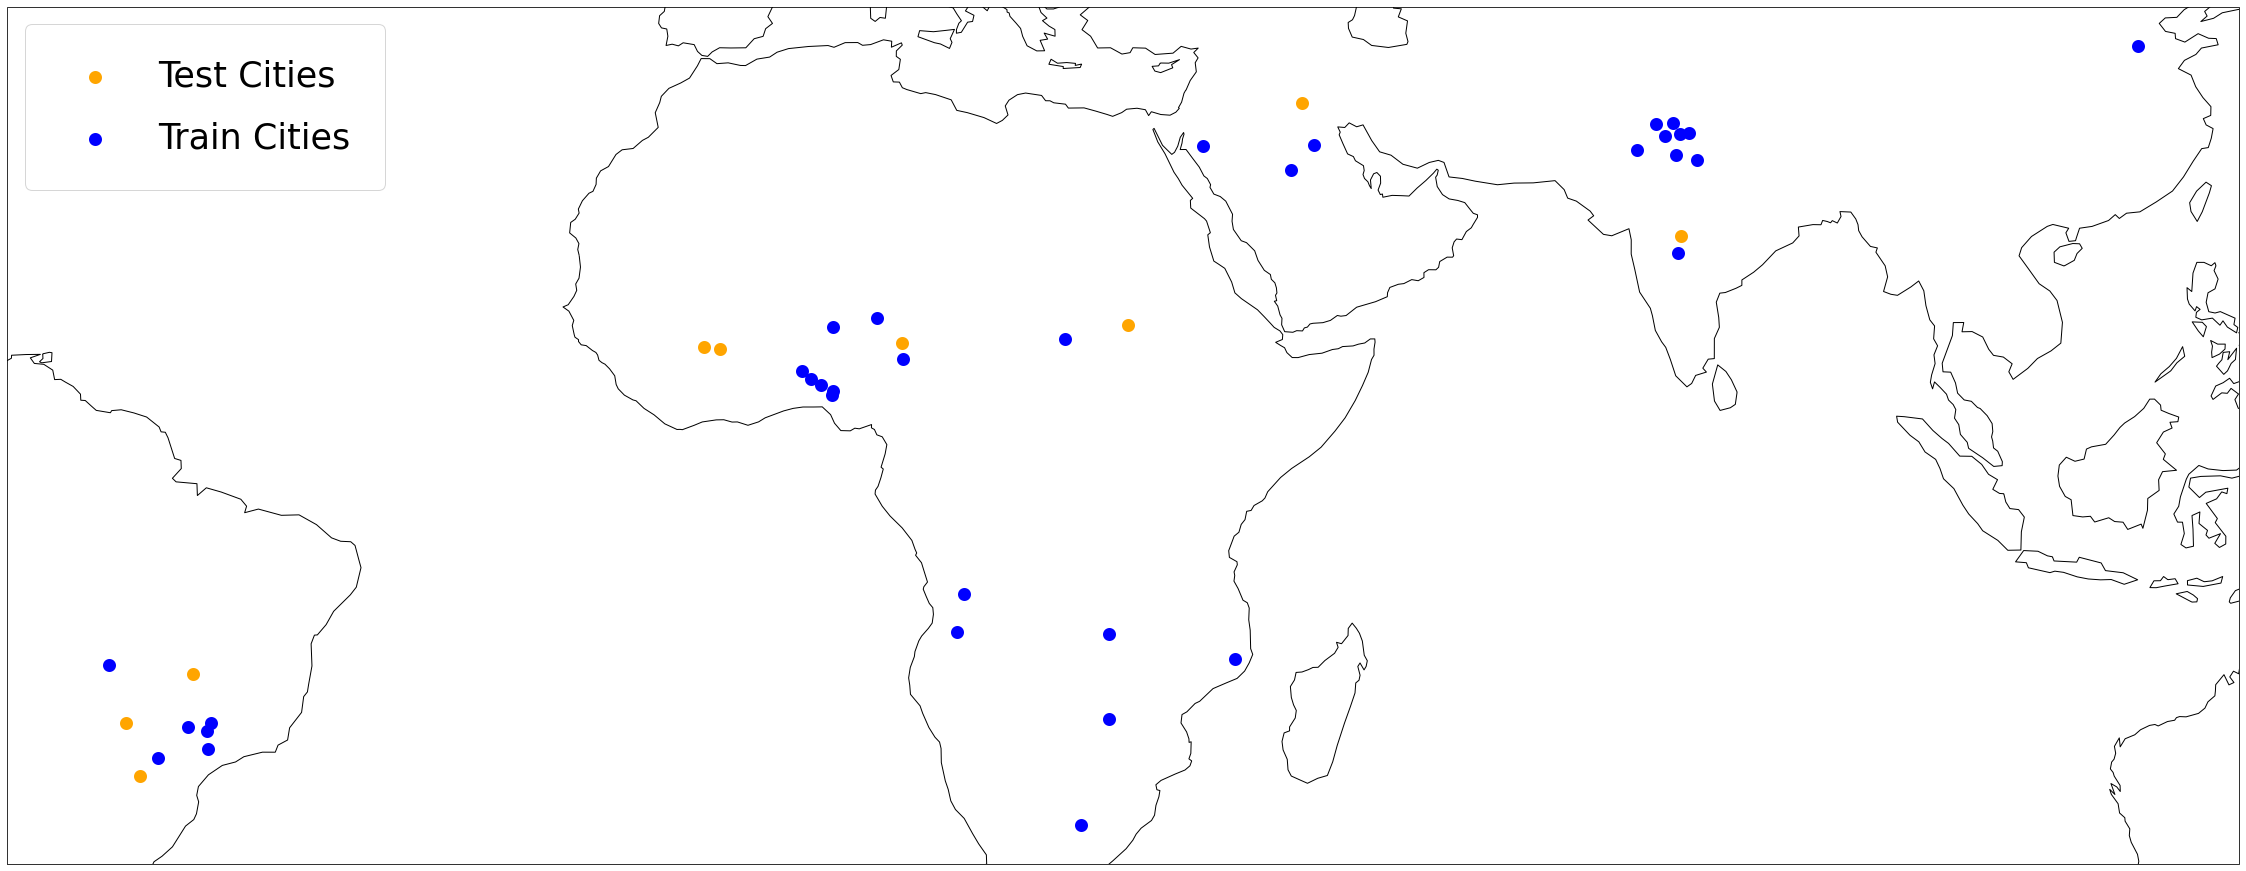

In [2]:
#Display train and test cities
#plot of where the test and training cities are located
fig = plt.figure(figsize=(40,35))

test_lats = CITY_COUNTRY_lat_lon[CITY_COUNTRY_lat_lon['City'].isin(test_cities)]['Lat']
test_lons = CITY_COUNTRY_lat_lon[CITY_COUNTRY_lat_lon['City'].isin(test_cities)]['Lon']

train_lats = CITY_COUNTRY_lat_lon[~CITY_COUNTRY_lat_lon['City'].isin(test_cities)]['Lat']
train_lons = CITY_COUNTRY_lat_lon[~CITY_COUNTRY_lat_lon['City'].isin(test_cities)]['Lon']

ax = plt.axes(projection=ccrs.PlateCarree())
ax.coastlines()

ax.scatter(test_lons, test_lats, zorder=5,color='orange', label='Test Cities', linewidths = 7.0, s =70)
ax.scatter(train_lons, train_lats, zorder=5,color='blue', label='Train Cities', linewidths = 7.0, s =70)

ax.legend(loc=2, borderpad = 1, fontsize = 35, labelspacing=0.8, fontsize = 45)

In [238]:
#create dictionary of the classifications at the correct level of detail (2 letters here)
koppen_dict = {'Aw': 'Tropical Savannah', 'BSh':'Arid Steppe' ,'BSk':'Arid Steppe', 
               'BWh':'Arid Desert', 'Cfa':'Temperate, no dry season', 'Cwa':'Temperate, dry winter', 
               'Cwb':'Temperate, dry winter'}
#create dictionary for the colors
color_dict = {'Tropical Savannah':'royalblue','Arid Steppe': 'saddlebrown', 'Arid Desert': 'orange', 
              'Temperate, no dry season':'forestgreen','Temperate, dry winter':'olive'}
#use the dictionary to create a new column containing the descriptions
CITY_COUNTRY_lat_lon['koppen_desc'] = CITY_COUNTRY_lat_lon.koppen_climate
CITY_COUNTRY_lat_lon = CITY_COUNTRY_lat_lon.replace({"koppen_desc": koppen_dict})

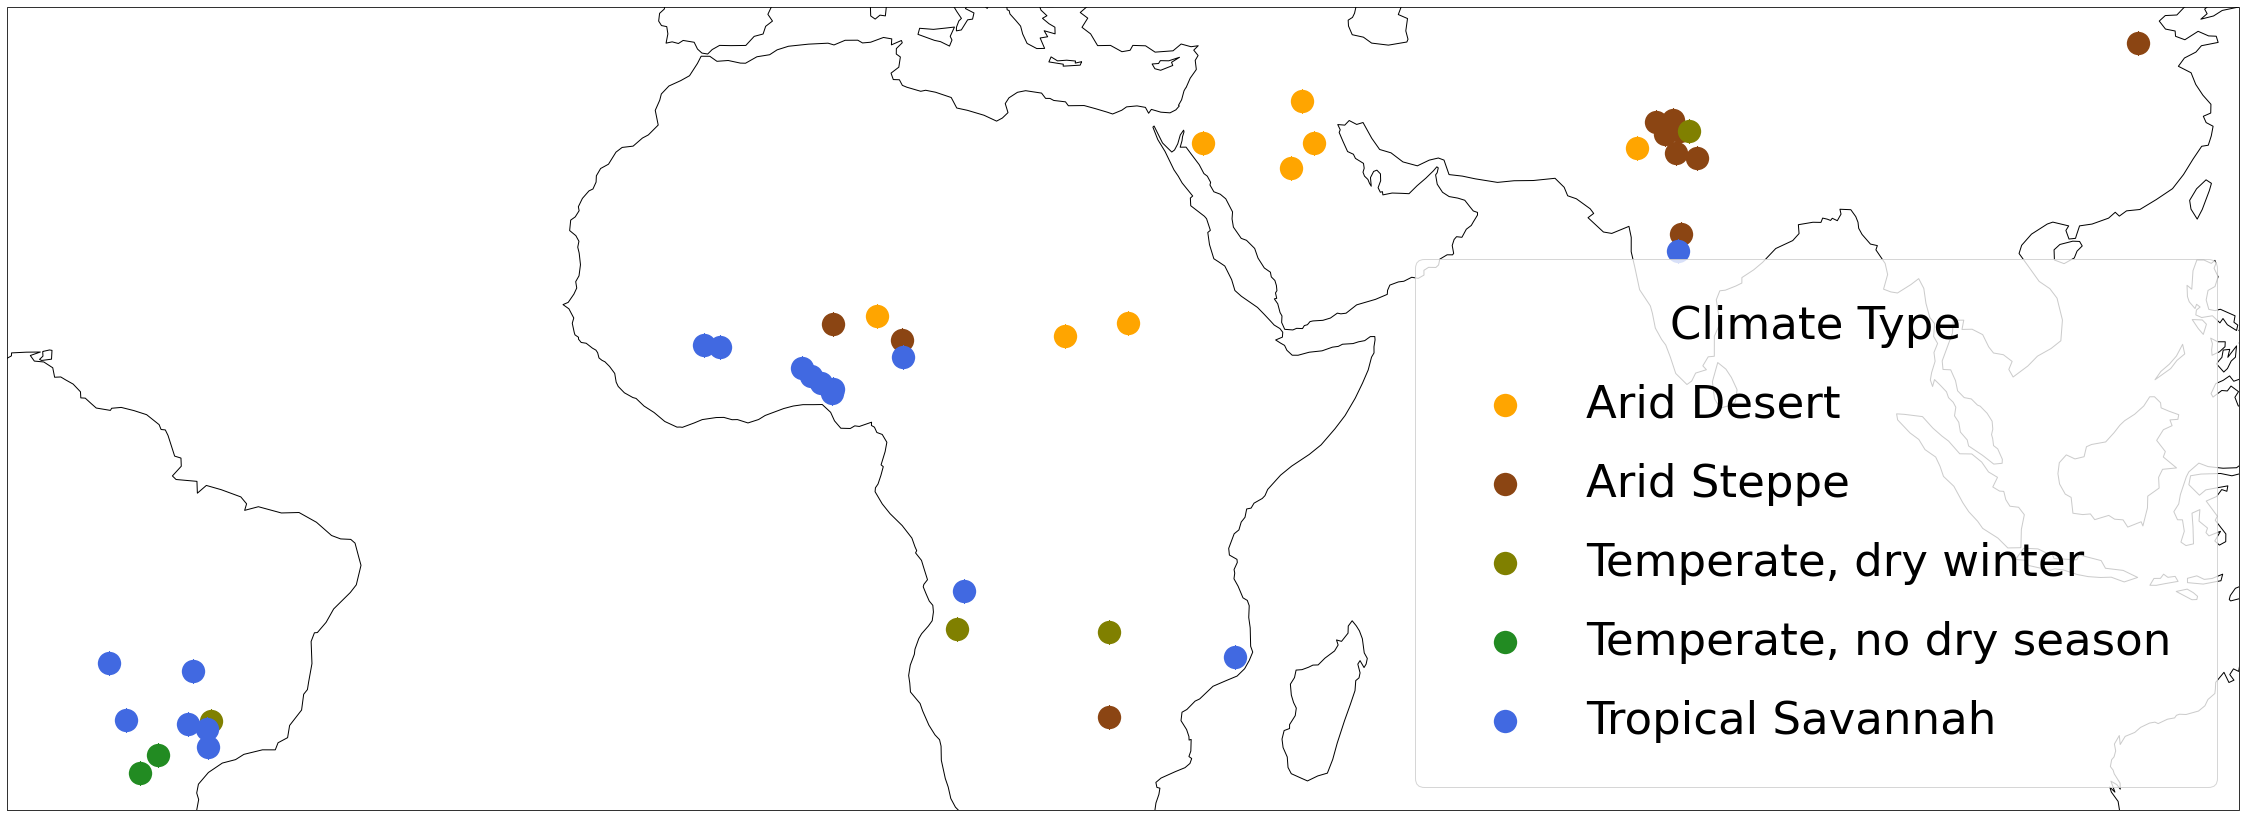

In [239]:
# View cities with the climate classification as the key
#change the legend title fontsize
plt.rcParams['legend.title_fontsize'] = 45

#create list of sorted definitions
desc_list = list(set(CITY_COUNTRY_lat_lon.koppen_desc))
desc_list.sort()

fig = plt.figure(figsize=(40,35))
ax = plt.axes(projection=ccrs.PlateCarree())
ax.coastlines()

for koppen_desc in desc_list:

    city_lats = CITY_COUNTRY_lat_lon[CITY_COUNTRY_lat_lon['koppen_desc']==koppen_desc]['Lat']
    city_lons = CITY_COUNTRY_lat_lon[CITY_COUNTRY_lat_lon['koppen_desc']==koppen_desc]['Lon']
    climate_color = color_dict[koppen_desc]
    
    ax.scatter(city_lons, city_lats, zorder=5, color=climate_color, label=koppen_desc, linewidths = 15.0, s =70)

ax.legend(title = 'Climate Type', loc=4, borderpad = 1, fontsize = 45, labelspacing=0.8)

#save figure as png
os.chdir(os.path.join(et.io.HOME, 'Documents', 'Python_Scripts', 'PROJECT','Graphs_outputs','pred_modelling'))   
plt.savefig('climate_class_map.png', bbox_inches = 'tight')

Muliple Linear Regression

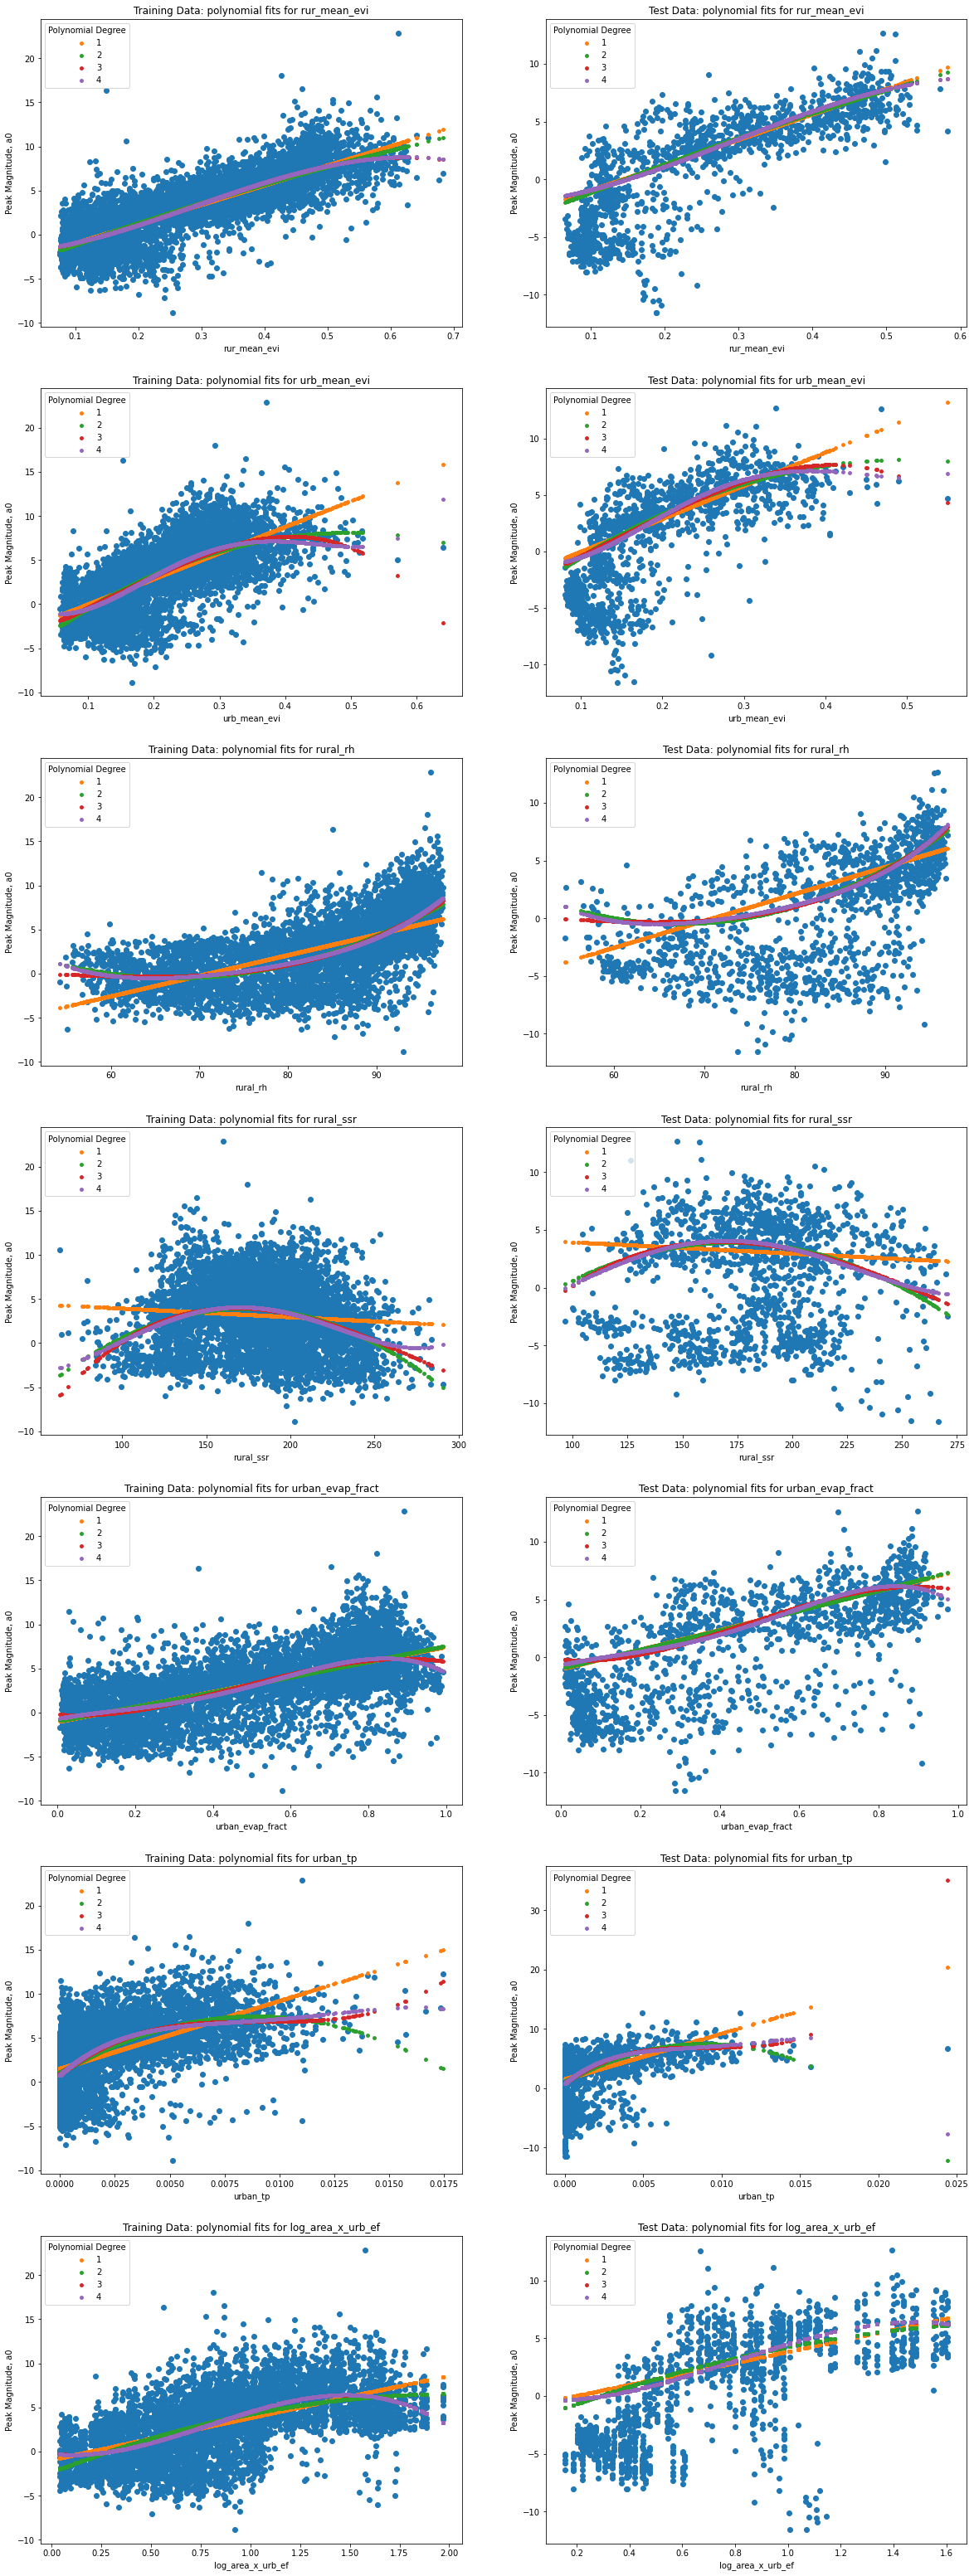

In [34]:
###### LINEAR REGRESSION ####################

#############################################
##### INPUT VARIABLES NOT NORMALISED ########
#############################################

#Linear Regression
#Looking at the individual variables 
#(includes polynomials but is linear in nature of the coefficients)
#create plots of each

#create the empty plots
num_cols = 2
num_rows = len(predictor_variables)

fig, axes = plt.subplots(num_rows,num_cols, figsize = (20, 8*num_rows))
#plt.subplots_adjust(hspace = 0.5)
#plt.subplots_adjust(wspace = 0.5)

#degrees of polynomial to fit
degrees = [1, 2,3,4]

for i1, predictor_variable in enumerate(predictor_variables):
    
    x_train = X_train[predictor_variable].values.reshape(-1, 1) #reshape due to required form
    x_test = X_test[predictor_variable].values.reshape(-1, 1)
    
    #plot the data
    #training data
    axes[i1,0].scatter(x_train, y_train)
    axes[i1,0].set(xlabel = predictor_variable, ylabel = 'Peak Magnitude, a0',
                   title = 'Training Data: polynomial fits for {}'.format(predictor_variable))
    #test data
    axes[i1,1].scatter(x_test, y_test)
    axes[i1,1].set(xlabel = predictor_variable, ylabel = 'Peak Magnitude, a0',
                   title = 'Test Data: polynomial fits for {}'.format(predictor_variable))   
    
    #create matrices to store the train and test predictions
    #each row is a data point, each column a prediction using a polynomial of some degree
    y_train_pred = np.zeros((len(x_train), len(degrees)))
    y_test_pred = np.zeros((len(x_test), len(degrees)))

    for i2, degree in enumerate(degrees):
    
        #make pipeline- create polynomial inputs, then feed them to lin reg model
        model = make_pipeline(PolynomialFeatures(degree), LinearRegression())
        model.fit(x_train, y_train)
    
        #predict on test and train data
        #store the predictions of each degree in the corresponding column
        y_train_pred[:, i2] = model.predict(x_train)
        y_test_pred[:, i2] = model.predict(x_test)
     
        #plot the polynomials
        axes[i1,0].scatter(x_train, y_train_pred[:, i2], s=15, label=str(degree))  #training data
        axes[i1,0].legend(loc='upper left', title = 'Polynomial Degree')
        axes[i1,1].scatter(x_test, y_test_pred[:, i2], s=15, label=str(degree))    #test data
        axes[i1,1].legend(loc='upper left', title = 'Polynomial Degree')


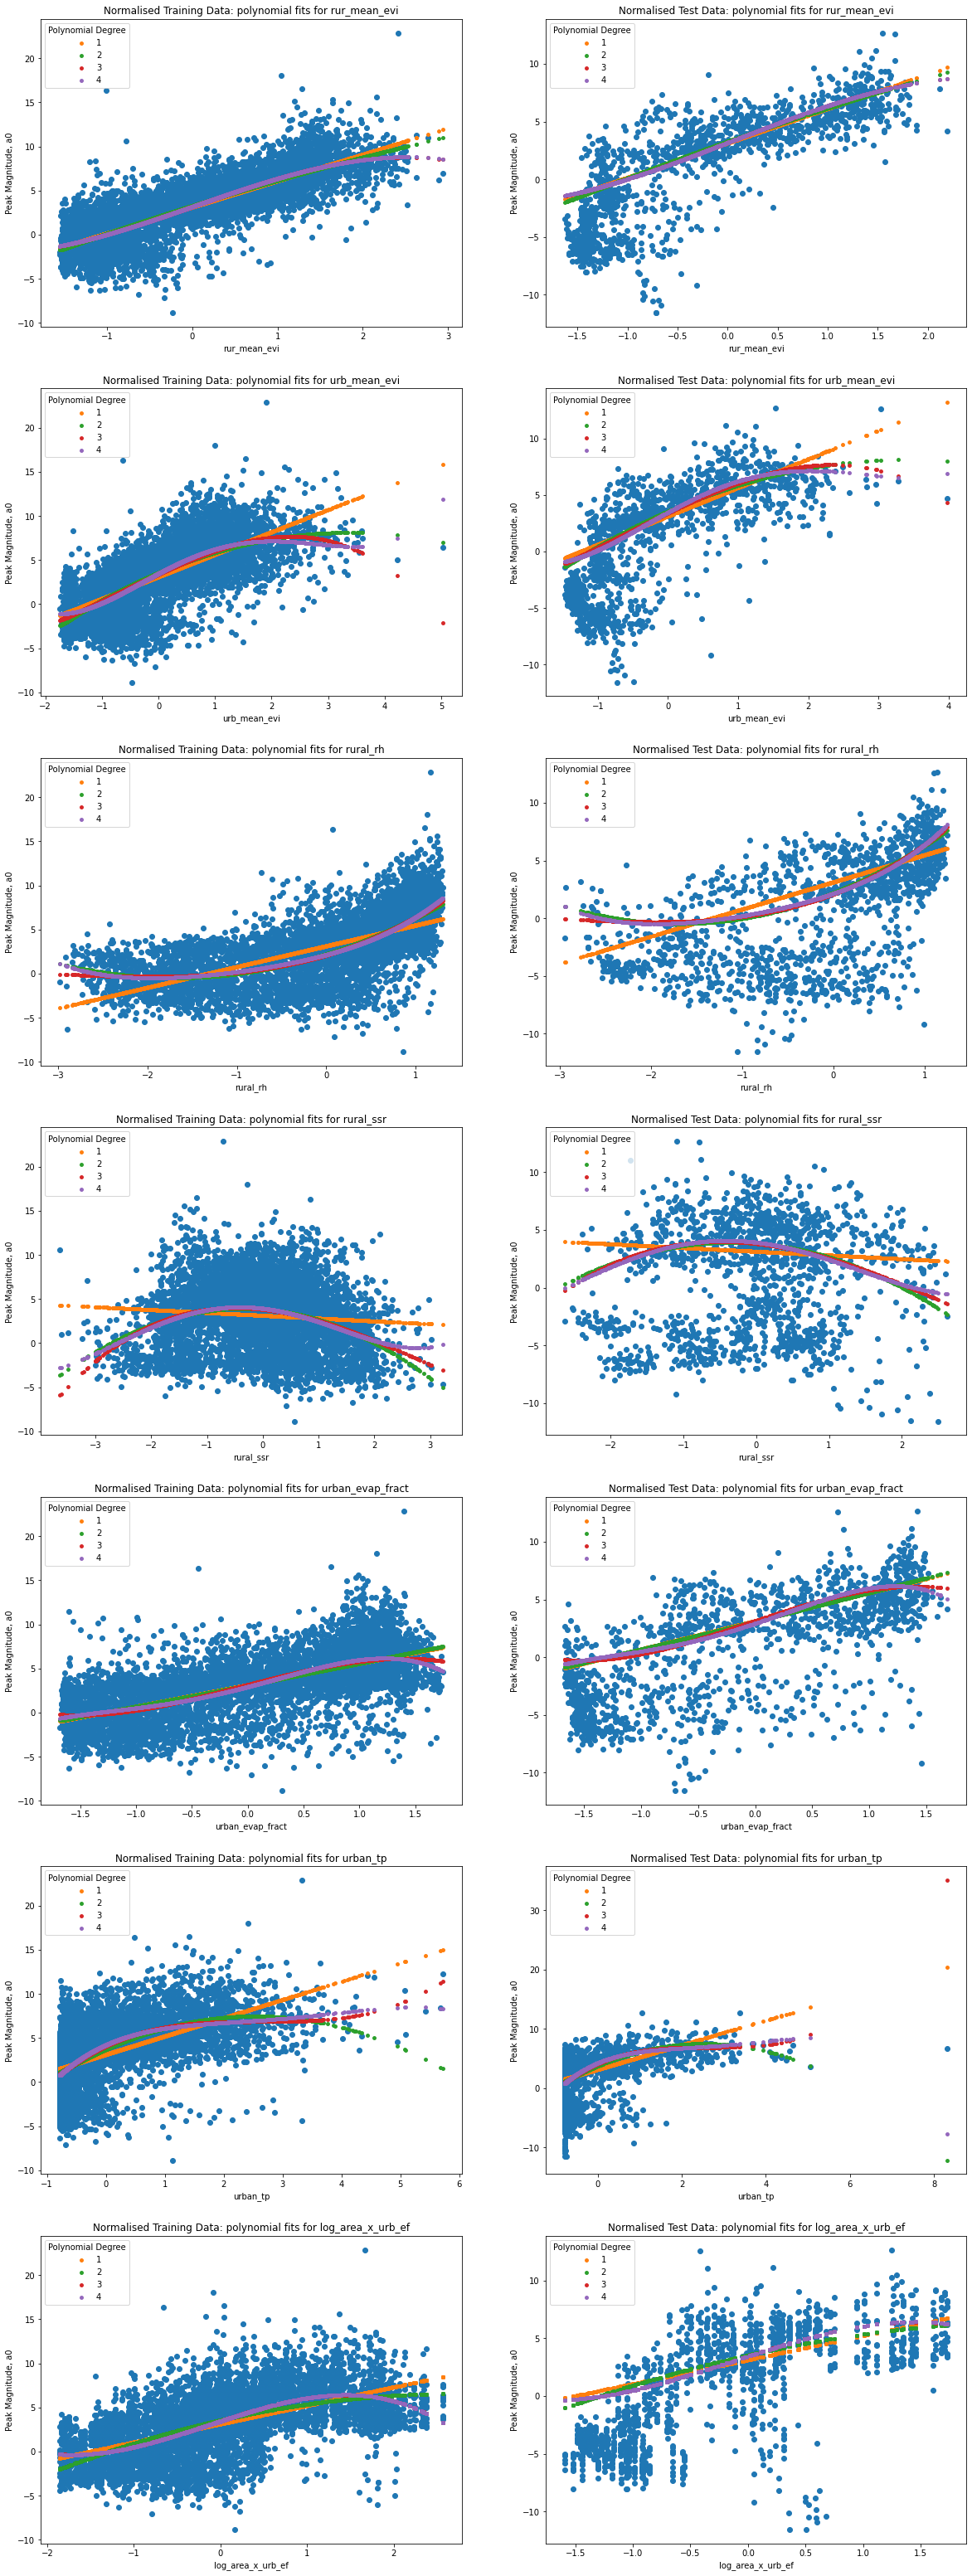

In [35]:
###### LINEAR REGRESSION ####################

#############################################
##### NORMALISED INPUT VARIABLES ############
#############################################

#Looking at the individual variables 
#(includes polynomials but is linear in nature of the coefficients)
#create plots of each

#create the empty plots
num_cols = 2
num_rows = len(predictor_variables)

fig, axes = plt.subplots(num_rows,num_cols, figsize = (20, 8*num_rows))
#plt.subplots_adjust(hspace = 0.5)
#plt.subplots_adjust(wspace = 0.5)

#degrees of polynomial to fit
degrees = [1, 2,3,4]

for i1, predictor_variable in enumerate(predictor_variables):
    
    x_train = X_train_norm[predictor_variable].values.reshape(-1, 1) #reshape due to required form
    x_test = X_test_norm[predictor_variable].values.reshape(-1, 1)
    
    #plot the data
    #training data
    axes[i1,0].scatter(x_train, y_train)
    axes[i1,0].set(xlabel = predictor_variable, ylabel = 'Peak Magnitude, a0',
                   title = 'Normalised Training Data: polynomial fits for {}'.format(predictor_variable))
    #test data
    axes[i1,1].scatter(x_test, y_test)
    axes[i1,1].set(xlabel = predictor_variable, ylabel = 'Peak Magnitude, a0',
                   title = 'Normalised Test Data: polynomial fits for {}'.format(predictor_variable))   
    
    #create matrices to store the train and test predictions
    #each row is a data point, each column a prediction using a polynomial of some degree
    y_train_pred = np.zeros((len(x_train), len(degrees)))
    y_test_pred = np.zeros((len(x_test), len(degrees)))

    for i2, degree in enumerate(degrees):
    
        #make pipeline- create polynomial inputs, then feed them to lin reg model
        model = make_pipeline(PolynomialFeatures(degree), LinearRegression())
        model.fit(x_train, y_train)
    
        #predict on test and train data
        #store the predictions of each degree in the corresponding column
        y_train_pred[:, i2] = model.predict(x_train)
        y_test_pred[:, i2] = model.predict(x_test)
     
        #plot the polynomials
        axes[i1,0].scatter(x_train, y_train_pred[:, i2], s=15, label=str(degree)) #training data
        axes[i1,0].legend(loc='upper left', title = 'Polynomial Degree')
        axes[i1,1].scatter(x_test, y_test_pred[:, i2], s=15, label=str(degree))   #test data
        axes[i1,1].legend(loc='upper left', title = 'Polynomial Degree')


In [122]:
#Multiple Linear Regression (MLR) (degree 1 (not polynomial))

##################################
####### Creating the model #######
##################################
#Create linear regression object
lin_reg = LinearRegression()

#fit the model
lin_reg.fit(X_train_norm, y_train)

#predict the training 
y_train_pred = lin_reg.predict(X_train_norm)
#predict the test
y_test_pred = lin_reg.predict(X_test_norm)

#intercept
lin_intercept = lin_reg.intercept_
print('Intercept -- ',lin_intercept)
#coefficients
lin_coef = lin_reg.coef_
print('Coefficients--')
for i in range(len(lin_coef)):
    print(predictor_variables[i],':', lin_coef[i])

######################################################
###### Performance Metrics for the training set ######
######################################################
#rmse
train_lin_mse = mean_squared_error(y_train, y_train_pred)
train_lin_rmse = np.sqrt(train_lin_mse)
#r-square
train_lin_r2 = r2_score(y_train, y_train_pred)
#mae
train_lin_mae = mean_absolute_error(y_train, y_train_pred)
print('Training Metrics--', 'RMSE:', train_lin_rmse, 'R-square:', train_lin_r2, 'MAE:', train_lin_mae)

#################################################
###### Performance Metrics for the test set #####
#################################################
#rmse
test_lin_mse = mean_squared_error(y_test, y_test_pred)
test_lin_rmse = np.sqrt(test_lin_mse)
#r-square
test_lin_r2 = r2_score(y_test, y_test_pred)
#mae
test_lin_mae = mean_absolute_error(y_test, y_test_pred)
print('Test Metrics--', 'RMSE:', test_lin_rmse, 'R-square:', test_lin_r2, 'MAE:', test_lin_mae)

Intercept --  2.828055484669451
Coefficients--
rh_diff : 0.015324029165534893
rural_rh : 0.38824344904914126
ssr_diff : -0.2863645491589477
rural_ssr : 0.5589036010317603
rur_mean_evi : 2.12555274004152
evi_diff : -0.7517651551158498
log_area_x_rur_ef : 0.5318404356439089
Eccentricity : -0.3087425476711367
Training Metrics-- RMSE: 2.269538893406325 R-square: 0.6979438024332775 MAE: 1.6874406802062591
Test Metrics-- RMSE: 1.8528821288609751 R-square: 0.6875377999396453 MAE: 1.402656799382621


In [123]:
#Multiple Linear Regression (MLR) (degree 1 (not polynomial))

##################################
##### SUMMARY STATISTICS #########
##################################
#Carried out again in stats models library to get the p-values (no function to calculate these in scikit learn)
X_train1 = X_train_norm.to_numpy()     #required form of X is an array
X_train2 = sm.add_constant(X_train1)   #add intercept to model
est = sm.OLS(y_train, X_train2)
est2 = est.fit()
print(est2.summary())

                            OLS Regression Results                            
Dep. Variable:                     a0   R-squared:                       0.698
Model:                            OLS   Adj. R-squared:                  0.697
Method:                 Least Squares   F-statistic:                     1357.
Date:                Mon, 07 Feb 2022   Prob (F-statistic):               0.00
Time:                        14:58:48   Log-Likelihood:                -10534.
No. Observations:                4706   AIC:                         2.109e+04
Df Residuals:                    4697   BIC:                         2.115e+04
Df Model:                           8                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          2.8281      0.033     85.401      0.0

In [132]:
############################################
########## R SQUARE PLOTS BY CITY ##########
############################################

######## LINEAR REGRESSION #################

######## MAKE SURE THE  LINEAR REGRESSION MODEL HAS BEEN FIT BEFORE RUNNING THIS ##############################

#loop through each city to generate a r-square value based on the model 
cities = CITY_COUNTRY_lat_lon[CITY_COUNTRY_lat_lon['City'] != 'Cascavel'].City.values
#cities = CITY_COUNTRY_lat_lon.City.values
r2_list = []

#set the transformer (transform based on all cities not just one)
X_train_norm = pd.DataFrame(scaler.fit_transform(X_train), columns = X_train.columns)         #fit and transform

for i, city in enumerate(cities):
    data_city = all_monthly_data_df2[((all_monthly_data_df2['City'] == city) 
                                    & (all_monthly_data_df2['Overpass'] == overpass_time))].copy()

    X_data_city = data_city[predictor_variables]                                                  #predictors
    X_data_city_norm = pd.DataFrame(scaler.transform(X_data_city), columns = X_data_city.columns) #transform only
    y_data_city = data_city[target_variable]                                                      #target
    
    y_city_pred = lin_reg.predict(X_data_city_norm)
    
    r2_score_city = r2_score(y_data_city, y_city_pred)                                            #predict the r2 score
    
    r2_list.append(r2_score_city)

#create dataframe
#kg = CITY_COUNTRY_lat_lon.koppen_climate.values

#r2_df = pd.DataFrame({'city': cities, 'r2':r2_list, 'Koppen_Geiger':kg})    
r2_df = pd.DataFrame({'city': cities, 'r2':r2_list})    

In [133]:
r2_df[r2_df['r2'] < 0]

city         r2
9            Akola  -0.201948
11        Parbhani  -0.175771
14        Bulawayo  -1.479657
21         Bikaner -15.478030
26       Diwaniyah  -0.101250
29          Zinder  -1.718736
31           Akure  -0.135600
37        Buraydah  -0.640633
38  Hafar_al_Batin  -0.053174
39           Tabuk  -0.366546
40        Al_Obeid  -0.704672

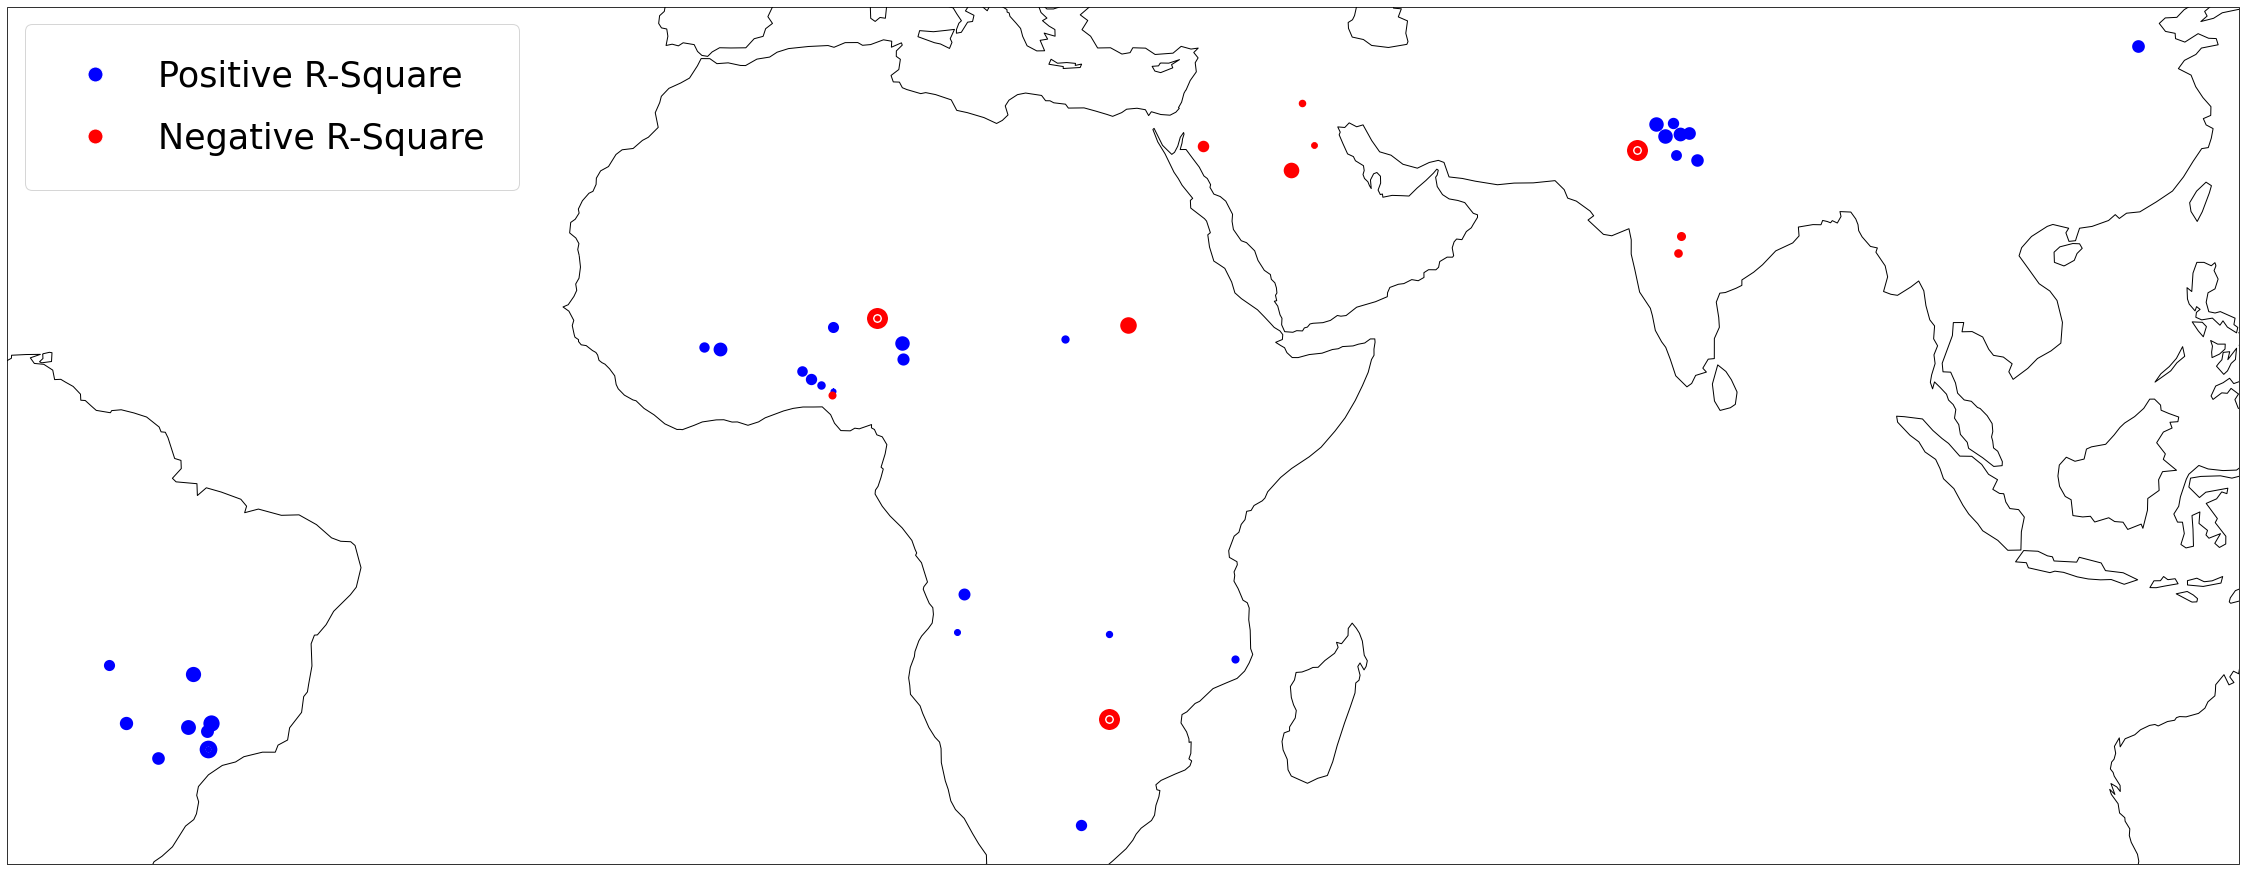

In [134]:
#Display cities with r2 proportional dot
#plot of where the test and training cities are located
fig = plt.figure(figsize=(40,35))
ax = plt.axes(projection=ccrs.PlateCarree())
ax.coastlines()

for i, city in enumerate(cities):

    lat = CITY_COUNTRY_lat_lon[CITY_COUNTRY_lat_lon['City'] == city]['Lat']
    lon = CITY_COUNTRY_lat_lon[CITY_COUNTRY_lat_lon['City'] == city]['Lon']
    r2 = r2_df.iloc[i].r2
        
    if r2 > -1:
        point_size = 15*abs(r2)
    else:
        point_size = 15
    
    if r2 < 0:
        point_col = 'red'
    else:
        point_col = 'blue'
    
    ax.scatter(lon, lat, zorder=5,color= point_col, linewidths = point_size)

    
    
legend_elements = [Line2D([0],[0],marker='o', color = 'w', markerfacecolor='blue', label = 'Positive R-Square'
                          , markersize=15),Line2D([0],[0],marker='o', color = 'w', markerfacecolor='red'
                          , label = 'Negative R-Square' , markersize=15)]
ax.legend(handles = legend_elements, loc=2, borderpad = 1, fontsize = 35, labelspacing=0.8)                          

In [104]:
############################################
#### PERMUTATIONS OF LINEAR REGRESSIONS ####
############################################

#linear regression to test all permutations of predictor variables
#create a dataframe to fill
n = len(predictor_variables)
whole_grid = np.ones((1, n), dtype=int) #start with the case where all variables are included

for i in range(n-1):
    m = i+1
    which = np.array(list(itertools.combinations(range(n), m)))
    grid = np.zeros((len(which), n), dtype="int8")

    #add the combinations into the grid
    grid[np.arange(len(which))[None].T, which] = 1

    whole_grid = np.vstack((whole_grid, grid))
    
all_models = pd.DataFrame(data = whole_grid, columns = predictor_variables) #create a dataframe with all the combinations
all_models['AIC'] = np.nan           #add in the test statistics
all_models['Ftest_pvalue']= np.nan
all_models['rmse'] = np.nan
all_models['rsquared'] = np.nan
all_models['test_rmse'] = np.nan
all_models['test_rsquared'] = np.nan

#go through the table and calculate test statistics for models including combinations of pred variables
for i in range(len(all_models)):
    row = all_models.iloc[i] #take the row
    variable_list = []
    for p, predictor in enumerate(predictor_variables):
        if row[p] == 1:
            variable_list.append(predictor)         #create list of the variables which are used in the row
    
    X_train_temp = X_train_norm[variable_list]      #select the train variables to be used
    X_test_temp = X_test_norm[variable_list]
    #not using test data for model validation/ selection as it must remain untouched
    #carry out the linear regression
    X_train_temp1 = X_train_temp.to_numpy()         #required form of X is an array
    X_train_temp2 = sm.add_constant(X_train_temp1)  #add intercept to model
    
    est = sm.OLS(y_train, X_train_temp2)
    est2 = est.fit()
    y_train_pred = est2.predict(X_train_temp2)
    
    #calculate the y test prediction
    
    X_test_temp1 = X_test_temp.to_numpy()                     #required form of X is an array
    X_test_temp2 = sm.add_constant(X_test_temp1)              #add intercept to model
    y_test_pred = est2.predict(X_test_temp2)                  #predict the test dataset
    
    #add in the test statistics
    all_models.loc[i,'AIC'] =  est2.aic                                 #AIC
    all_models.loc[i,'Ftest_pvalue']= est2.f_pvalue                     #f statistic p value
    all_models.loc[i,'rmse'] = rmse(y_train, y_train_pred)              #train rmse
    all_models.loc[i,'rsquared'] =est2.rsquared                         #train r square
    all_models.loc[i,'test_rmse'] = rmse(y_test, y_test_pred)           #test rmse
    all_models.loc[i,'test_rsquared'] = r2_score(y_test, y_test_pred)   #test r square
    
    
#save the table as a pickle
os.chdir(os.path.join(et.io.HOME, 'Documents', 'Python_Scripts', 'PROJECT','UHI_Project_Pickle_Files','predictive_models')) 
with open('all_variables_lin_reg.pkl', 'wb') as f:
    pickle.dump(all_models, f)

#for each number of predictor variables, select the model with the best r-squared
#add in the number of variables used in each model
all_models['num_variables'] = all_models[predictor_variables].sum(axis = 1)

#create empty dataframe to be filled
best_models = pd.DataFrame()
#select the models for each variable which have the best r-square
#best_models 
for i in range(len(predictor_variables)):
    max_rsquare = max(all_models[all_models['num_variables'] == (i+1)].rsquared)
    rows = all_models[(all_models['rsquared'] == max_rsquare)& (all_models['num_variables'] == (i+1))]
    best_models = best_models.append(rows)

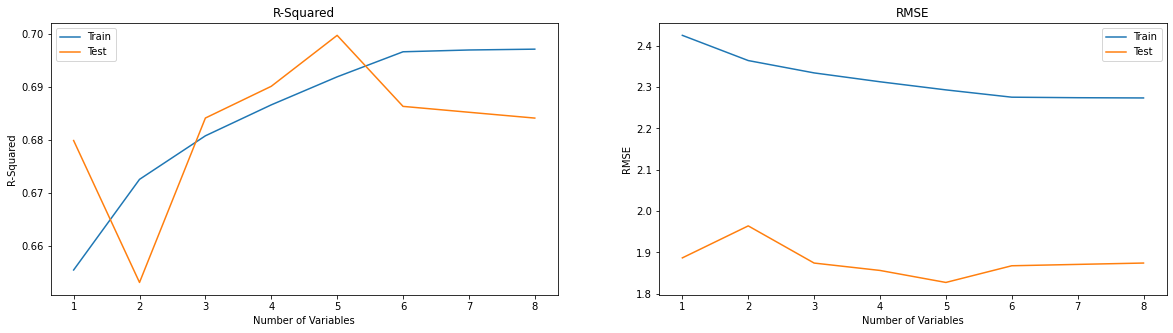

In [105]:
#plot the number of variables against the r-squared, AIC and rmse
fig, axes = plt.subplots(1,2, figsize = (20, 5))
axes[0].plot(best_models.num_variables, best_models.rsquared, label = 'Train')
axes[0].plot(best_models.num_variables, best_models.test_rsquared, label = 'Test')
axes[0].set(xlabel = 'Number of Variables', ylabel = 'R-Squared', title = 'R-Squared')
axes[0].legend()

axes[1].plot(best_models.num_variables, best_models.rmse, label = 'Train')
axes[1].plot(best_models.num_variables, best_models.test_rmse, label = 'Test')
axes[1].set(xlabel = 'Number of Variables', ylabel = 'RMSE', title = 'RMSE')
axes[1].legend()

xa = axes[0].get_xaxis()
xa.set_major_locator(MaxNLocator(integer=True))
xa = axes[1].get_xaxis()
xa.set_major_locator(MaxNLocator(integer=True))

In [108]:
best_models.iloc[5]

evap_fract_diff          0.000000
rural_evap_fract         0.000000
ssr_diff                 1.000000
rural_ssr                1.000000
rur_mean_evi             1.000000
evi_diff                 1.000000
log_area_x_rur_ef        1.000000
Eccentricity             1.000000
AIC                  21040.741145
Ftest_pvalue             0.000000
rmse                     2.275592
rsquared                 0.696624
test_rmse                1.867872
test_rsquared            0.686318
num_variables            6.000000
Name: 246, dtype: float64

In [461]:
#Using cross validation to determine the number of variables used (the hyperparameter in this case)
n = len(predictor_variables) 
#cross-validation scheme, 5 fold
folds = KFold(n_splits = 5, shuffle = True, random_state = 100)

#specify range of hyperparameters to tune
hyper_params = [{'n_features_to_select': list(range(1, n+1))}]

#perform grid search

lin_reg = LinearRegression()           #specify model
lin_reg.fit(X_train_norm, y_train)     #fit the model 
rfe = RFE(lin_reg)                     #feature selection

#Use cross validation
model_cv = GridSearchCV(estimator = rfe, 
                        param_grid = hyper_params, 
                        scoring= 'r2', 
                        cv = folds, 
                        verbose = 1,
                        return_train_score=True)      

# fit the model
model_cv.fit(X_train_norm, y_train)  

#cv results
cv_results = pd.DataFrame(model_cv.cv_results_)
cv_results


Fitting 5 folds for each of 5 candidates, totalling 25 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  25 out of  25 | elapsed:    0.1s finished


mean_fit_time  std_fit_time  mean_score_time  std_score_time  \
0       0.007189      0.002700         0.001595        0.000489   
1       0.005377      0.001188         0.001997        0.000898   
2       0.004787      0.000746         0.002194        0.000746   
3       0.002989      0.000004         0.001810        0.000757   
4       0.002584      0.000482         0.001397        0.000488   

  param_n_features_to_select                       params  split0_test_score  \
0                          1  {'n_features_to_select': 1}           0.595548   
1                          2  {'n_features_to_select': 2}           0.657208   
2                          3  {'n_features_to_select': 3}           0.729576   
3                          4  {'n_features_to_select': 4}           0.743096   
4                          5  {'n_features_to_select': 5}           0.746809   

   split1_test_score  split2_test_score  split3_test_score  ...  \
0           0.597881           0.594870           0.524084  ...   
1           0.650170           0.648522           0.600784  ...   
2           0.683184           0.703721           0.664467  ...   
3           0.683246           0.720789           0.671848  ...   
4           0.686207           0.726311           0.668576  ...   

   mean_test_score  std_test_score  rank_test_score  split0_train_score  \
0         0.572900        0.029781                5            0.569962   
1         0.631845        0.024822                4            0.627992   
2         0.681839        0.034448                3            0.673320   
3         0.693936        0.033494                2            0.685960   
4         0.695970        0.035465                1            0.688410   

   split1_train_score  split2_train_score  split3_train_score  \
0            0.569406            0.568987            0.586660   
1            0.629694            0.629229            0.641109   
2            0.684535            0.678444            0.688749   
3            0.700330            0.689914            0.702713   
4            0.702963            0.691571            0.706641   

   split4_train_score  mean_train_score  std_train_score  
0            0.580518          0.575107         0.007200  
1            0.641251          0.633855         0.006007  
2            0.697642          0.684538         0.008395  
3            0.707964          0.697376         0.008190  
4            0.710980          0.700113         0.008704  

[5 rows x 21 columns]

In [450]:
model_cv.best_params_

{'n_features_to_select': 5}

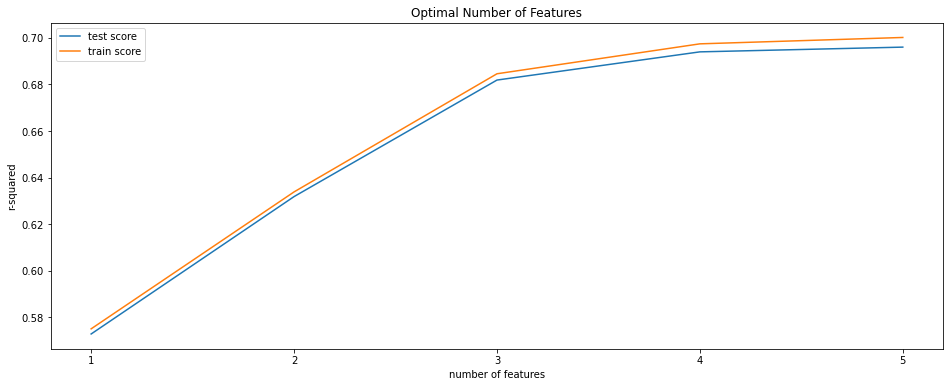

In [451]:
# plotting cv results
fig, axes = plt.subplots(1,1, figsize = (16, 6))

axes.plot(cv_results["param_n_features_to_select"], cv_results["mean_test_score"])
axes.plot(cv_results["param_n_features_to_select"], cv_results["mean_train_score"])
axes.set(xlabel= 'number of features', ylabel='r-squared', title = "Optimal Number of Features")
axes.legend(['test score', 'train score'], loc='upper left')
xa = axes.get_xaxis()
xa.set_major_locator(MaxNLocator(integer=True))

In [20]:
#Multiple Linear Regression (MLR) (degree 2 (polynomial))
##################################
####### Creating the model #######
##################################

#create polynomial inputs, 
poly_features = PolynomialFeatures(degree = 2)
X_poly = poly_features.fit_transform(X_train_norm)

#create the lin reg model
lin_reg = LinearRegression()

#then feed polynomials to lin reg model
lin_reg.fit(X_poly, y_train)
#predict the training 
y_train_pred = lin_reg.predict(X_poly)
#predict the test
X_poly_test = poly_features.fit_transform(X_test_norm)
y_test_pred = lin_reg.predict(X_poly_test)

#intercept
lin_intercept = lin_reg.intercept_
print('Intercept -- ',lin_intercept)
#coefficients
poly_predictor_vars = poly_features.get_feature_names(predictor_variables)
lin_coef = lin_reg.coef_
print('Coefficients--')
for i in range(len(lin_coef)):
    print(poly_predictor_vars[i],':',lin_coef[i])

######################################################
###### Performance Metrics for the training set ######
######################################################
#rmse
train_lin_mse = mean_squared_error(y_train, y_train_pred)
train_lin_rmse = np.sqrt(train_lin_mse)
#r-square
train_lin_r2 = r2_score(y_train, y_train_pred)
#mae
train_lin_mae = mean_absolute_error(y_train, y_train_pred)
print('Training Metrics--', 'RMSE:', train_lin_rmse, 'R-square:', train_lin_r2, 'MAE:', train_lin_mae)

#################################################
###### Performance Metrics for the test set #####
#################################################
#rmse
test_lin_mse = mean_squared_error(y_test, y_test_pred)
test_lin_rmse = np.sqrt(test_lin_mse)
#r-square
test_lin_r2 = r2_score(y_test, y_test_pred)
#mae
test_lin_mae = mean_absolute_error(y_test, y_test_pred)
print('Test Metrics--', 'RMSE:', test_lin_rmse, 'R-square:', test_lin_r2, 'MAE:', test_lin_mae)

Intercept --  3.789049122943683
Coefficients--
1 : 0.0
rur_mean_evi : 2.9412229946701993
urban_evap_fract : 0.04450023971265443
rural_ssr : 0.5081372754395473
rur_mean_evi^2 : -0.34103853754348923
rur_mean_evi urban_evap_fract : 0.5534391662946676
rur_mean_evi rural_ssr : 0.6414592204989376
urban_evap_fract^2 : -0.2605622600844957
urban_evap_fract rural_ssr : -0.13688406607500747
rural_ssr^2 : -0.12128474032171421
Training Metrics-- RMSE: 2.1694283864659467 R-square: 0.6568953148889736 MAE: 1.675189247430664
Test Metrics-- RMSE: 2.79741784278168 R-square: 0.45449809896627935 MAE: 1.9611765820015963


Ridge Regression

In [4]:
##########################
#### RIDGE REGRESSION ####
##########################

folds = 5    #define the number of folds (K)

#define regression model
ridge_reg = Ridge(fit_intercept=True)
#specify the hyperparameters to test
hyper_params = {'alpha':[1, 10, 50, 100, 400,500,600, 10000]}
#use cross validation to determine the hyperparameter value
model_cv = GridSearchCV(estimator = ridge_reg, 
                        param_grid = hyper_params, 
                        scoring= 'r2', 
                        cv = folds, 
                        verbose = 1,
                        return_train_score=True) 
#fit the model~
model_cv.fit(X_train_norm, y_train)  

#cv results
cv_results = pd.DataFrame(model_cv.cv_results_)
cv_results

Fitting 5 folds for each of 8 candidates, totalling 40 fits


mean_fit_time  std_fit_time  mean_score_time  std_score_time param_alpha  \
0       0.038087      0.074203         0.000201        0.000403           1   
1       0.002385      0.000481         0.001794        0.000397          10   
2       0.001804      0.000389         0.000990        0.000631          50   
3       0.003125      0.006249         0.000000        0.000000         100   
4       0.000000      0.000000         0.000000        0.000000         400   
5       0.003124      0.006249         0.000000        0.000000         500   
6       0.000000      0.000000         0.003124        0.006249         600   
7       0.003124      0.006248         0.000000        0.000000       10000   

             params  split0_test_score  split1_test_score  split2_test_score  \
0      {'alpha': 1}           0.535107           0.438392           0.651382   
1     {'alpha': 10}           0.538135           0.438835           0.650932   
2     {'alpha': 50}           0.548903           0.440410           0.648969   
3    {'alpha': 100}           0.557830           0.441719           0.646606   
4    {'alpha': 400}           0.568837           0.443383           0.634265   
5    {'alpha': 500}           0.566426           0.443005           0.630639   
6    {'alpha': 600}           0.562946           0.442434           0.627170   
7  {'alpha': 10000}           0.101402           0.350372           0.421035   

   split3_test_score  ...  mean_test_score  std_test_score  rank_test_score  \
0           0.509335  ...         0.545571        0.072686                7   
1           0.509605  ...         0.546919        0.072783                6   
2           0.510840  ...         0.551784        0.073348                5   
3           0.512475  ...         0.555998        0.074080                4   
4           0.522969  ...         0.563909        0.075636                2   
5           0.526206  ...         0.563942        0.075516                1   
6           0.529178  ...         0.563435        0.075290                3   
7           0.422859  ...         0.321182        0.117969                8   

   split0_train_score  split1_train_score  split2_train_score  \
0            0.667348            0.741818            0.694033   
1            0.667335            0.741809            0.694027   
2            0.667072            0.741625            0.693892   
3            0.666444            0.741173            0.693557   
4            0.661039            0.736918            0.690181   
5            0.659214            0.735363            0.688869   
6            0.657428            0.733798            0.687511   
7            0.499530            0.580163            0.533136   

   split3_train_score  split4_train_score  mean_train_score  std_train_score  
0            0.715729            0.662897          0.696365         0.029693  
1            0.715722            0.662879          0.696354         0.029696  
2            0.715589            0.662539          0.696143         0.029753  
3            0.715254            0.661745          0.695635         0.029878  
4            0.711681            0.655232          0.691010         0.030705  
5            0.710202            0.653052          0.689340         0.030913  
6            0.708635            0.650907          0.687656         0.031092  
7            0.536282            0.466245          0.523071         0.038259  

[8 rows x 21 columns]

In [5]:
#Performance stats for ridge regression
y_train_pred = model_cv.predict(X_train_norm)
y_test_pred = model_cv.predict(X_test_norm)

#####################################################
###### Performance Metrics for the training set ######
######################################################
#rmse
train_ridge_mse = mean_squared_error(y_train, y_train_pred)
train_ridge_rmse = np.sqrt(train_ridge_mse)
#r-square
train_ridge_r2 = r2_score(y_train, y_train_pred)
#mae
train_ridge_mae = mean_absolute_error(y_train, y_train_pred)
print('Training Metrics--', 'RMSE:', train_ridge_rmse, 'R-square:', train_ridge_r2, 'MAE:', train_ridge_mae)

#################################################
###### Performance Metrics for the test set #####
#################################################
#rmse
test_ridge_mse = mean_squared_error(y_test, y_test_pred)
test_ridge_rmse = np.sqrt(test_ridge_mse)
#r-square
test_ridge_r2 = r2_score(y_test, y_test_pred)
#mae
test_ridge_mae = mean_absolute_error(y_test, y_test_pred)
print('Test Metrics--', 'RMSE:', test_ridge_rmse, 'R-square:', test_ridge_r2, 'MAE:', test_ridge_mae)


Training Metrics-- RMSE: 2.2909988863361526 R-square: 0.6925021095398854 MAE: 1.7116891884012497
Test Metrics-- RMSE: 1.8978975056488545 R-square: 0.6761521887844413 MAE: 1.4502330933366425


In [6]:
model_cv.best_params_

{'alpha': 500}

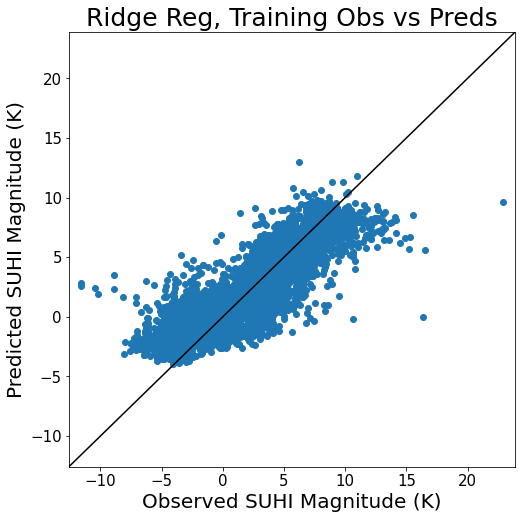

In [22]:
# PLOTS: obvs vs predictions

#plt.rc('font', size=15)          # controls default text sizes
plt.rc('axes', titlesize=25)     # fontsize of the axes title
plt.rc('axes', labelsize=20)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=15)    # fontsize of the tick labels
plt.rc('ytick', labelsize=15)    # fontsize of the tick labels
#plt.rc('legend', fontsize=20)    # legend fontsize
plt.rc('figure', titlesize=20)  # fontsize of the figure title

fig, axes = plt.subplots(1,1, figsize = (8, 8))

axes.scatter(y_train, y_train_pred)
axes.set(title = 'Ridge Reg, Training Obs vs Preds', 
         xlabel = 'Observed SUHI Magnitude (K)', ylabel = 'Predicted SUHI Magnitude (K)')
         #xlabel = 'Observed SUHI Mean (K)', ylabel = 'Predicted SUHI Mean (K)')

axesmin = min(min(y_train), min(y_train_pred)) - 1
axesmax = max(max(y_train), max(y_train_pred)) + 1

axes.set_xlim([axesmin, axesmax])
axes.set_ylim([axesmin, axesmax])

axes.plot([axesmin, axesmax],[axesmin, axesmax], color = 'k')

#save figure as png
os.chdir(os.path.join(et.io.HOME, 'Documents', 'Python_Scripts', 'PROJECT','Graphs_outputs','pred_modelling'))   
plt.savefig('ridger_training.png', bbox_inches = 'tight')

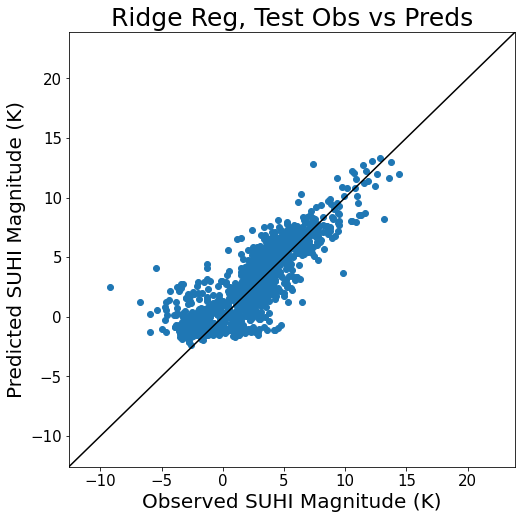

In [23]:
fig, axes = plt.subplots(1,1, figsize = (8, 8))

axes.scatter(y_test, y_test_pred)
axes.set(title = 'Ridge Reg, Test Obs vs Preds', 
         xlabel = 'Observed SUHI Magnitude (K)', ylabel = 'Predicted SUHI Magnitude (K)')
         #xlabel = 'Observed SUHI Mean (K)', ylabel = 'Predicted SUHI Mean (K)')

axesmin = min(min(y_train), min(y_train_pred)) - 1
axesmax = max(max(y_train), max(y_train_pred)) + 1

axes.set_xlim([axesmin, axesmax])
axes.set_ylim([axesmin, axesmax])

axes.plot([axesmin, axesmax],[axesmin, axesmax], color = 'k')

#save figure as png
os.chdir(os.path.join(et.io.HOME, 'Documents', 'Python_Scripts', 'PROJECT','Graphs_outputs','pred_modelling'))   
plt.savefig('ridger_test.png', bbox_inches = 'tight')

Random Forest regression (RFR)

In [150]:
##################################
#### RANDOM FOREST REGRESSION ####
##################################

forest_reg = RandomForestRegressor()                                  #define the model

#carry out cross validation
folds = 5                                                             #define the number of folds (K)
#specify the hyperparameters to test
#num_features_for_split = total_input_features/3
hyper_params = {'n_estimators':[5,10,20,40,60,80,100]                 #the number of trees
                ,'max_depth':[10,20,30,40,50,60,70,80,90,100,None]    #the tree depth
                ,'min_samples_leaf':[1,2,4,15]                        #min number of samples required at each leaf node
                ,'min_samples_split':[2,5,10,15] }                    #min number of samples required to split a node

#use cross validation to determine the hyperparameter value
model_cv = GridSearchCV(estimator = forest_reg, 
                        param_grid = hyper_params, 
                        #scoring= 'r2', 
                        cv = folds, 
                        verbose = 1,                                  #verbose- how detailed output is   
                        return_train_score=True) 
#fit the model
model_cv.fit(X_train_norm, y_train)  

#cv results
cv_results = pd.DataFrame(model_cv.cv_results_)
cv_results

Fitting 5 folds for each of 1232 candidates, totalling 6160 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 6160 out of 6160 | elapsed: 84.0min finished


mean_fit_time  std_fit_time  mean_score_time  std_score_time  \
0          0.086167      0.009367         0.003391        0.000489   
1          0.163163      0.004306         0.004189        0.000399   
2          0.290231      0.009836         0.006184        0.000978   
3          0.614156      0.033650         0.010373        0.001493   
4          0.934103      0.047986         0.016364        0.002238   
...             ...           ...              ...             ...   
1227       0.306779      0.021866         0.007181        0.001163   
1228       0.525396      0.030181         0.009774        0.001163   
1229       0.773436      0.017622         0.017952        0.012505   
1230       1.055387      0.065048         0.016357        0.001739   
1231       1.353181      0.064682         0.019948        0.001786   

     param_max_depth param_min_samples_leaf param_min_samples_split  \
0                 10                      1                       2   
1                 10                      1                       2   
2                 10                      1                       2   
3                 10                      1                       2   
4                 10                      1                       2   
...              ...                    ...                     ...   
1227            None                     15                      15   
1228            None                     15                      15   
1229            None                     15                      15   
1230            None                     15                      15   
1231            None                     15                      15   

     param_n_estimators                                             params  \
0                     5  {'max_depth': 10, 'min_samples_leaf': 1, 'min_...   
1                    10  {'max_depth': 10, 'min_samples_leaf': 1, 'min_...   
2                    20  {'max_depth': 10, 'min_samples_leaf': 1, 'min_...   
3                    40  {'max_depth': 10, 'min_samples_leaf': 1, 'min_...   
4                    60  {'max_depth': 10, 'min_samples_leaf': 1, 'min_...   
...                 ...                                                ...   
1227                 20  {'max_depth': None, 'min_samples_leaf': 15, 'm...   
1228                 40  {'max_depth': None, 'min_samples_leaf': 15, 'm...   
1229                 60  {'max_depth': None, 'min_samples_leaf': 15, 'm...   
1230                 80  {'max_depth': None, 'min_samples_leaf': 15, 'm...   
1231                100  {'max_depth': None, 'min_samples_leaf': 15, 'm...   

      split0_test_score  ...  mean_test_score  std_test_score  \
0              0.535051  ...         0.570209        0.091330   
1              0.538350  ...         0.593579        0.097970   
2              0.586956  ...         0.613822        0.089213   
3              0.575150  ...         0.609160        0.082464   
4              0.591951  ...         0.613348        0.091246   
...                 ...  ...              ...             ...   
1227           0.577314  ...         0.614174        0.100211   
1228           0.576315  ...         0.612686        0.094357   
1229           0.575031  ...         0.613299        0.094375   
1230           0.581967  ...         0.617758        0.090955   
1231           0.580154  ...         0.611730        0.089866   

      rank_test_score  split0_train_score  split1_train_score  \
0                1186            0.888380            0.914915   
1                1038            0.899695            0.922114   
2                 257            0.901625            0.924101   
3                 671            0.904700            0.927210   
4                 310            0.906074            0.927509   
...               ...                 ...                 ...   
1227              233            0.845864            0.884081   
1228              374            0.847822            0.884408   
1229     

In [151]:
cv_results[cv_results['rank_test_score'] < 10].sort_values(by = ['rank_test_score'])

mean_fit_time  std_fit_time  mean_score_time  std_score_time  \
16        0.277367      0.007224         0.005784        0.000745   
44        0.273269      0.011336         0.006184        0.000746   
52        0.547122      0.026949         0.009381        0.001189   
24        0.567476      0.025324         0.009774        0.000399   
25        0.814237      0.022420         0.013173        0.001944   
951       1.679909      0.139672         0.031515        0.011912   
277       0.953051      0.035292         0.015360        0.001493   
54        1.151920      0.050196         0.022747        0.012636   
727       2.233800      0.381580         0.042486        0.023207   

    param_max_depth param_min_samples_leaf param_min_samples_split  \
16               10                      1                      10   
44               10                      2                      10   
52               10                      2                      15   
24               10                      1                      15   
25               10                      1                      15   
951              90                      2                      15   
277              30                      2                      15   
54               10                      2                      15   
727              70                      2                      15   

    param_n_estimators                                             params  \
16                  20  {'max_depth': 10, 'min_samples_leaf': 1, 'min_...   
44                  20  {'max_depth': 10, 'min_samples_leaf': 2, 'min_...   
52                  40  {'max_depth': 10, 'min_samples_leaf': 2, 'min_...   
24                  40  {'max_depth': 10, 'min_samples_leaf': 1, 'min_...   
25                  60  {'max_depth': 10, 'min_samples_leaf': 1, 'min_...   
951                100  {'max_depth': 90, 'min_samples_leaf': 2, 'min_...   
277                 60  {'max_depth': 30, 'min_samples_leaf': 2, 'min_...   
54                  80  {'max_depth': 10, 'min_samples_leaf': 2, 'min_...   
727                100  {'max_depth': 70, 'min_samples_leaf': 2, 'min_...   

     split0_test_score  ...  mean_test_score  std_test_score  rank_test_score  \
16            0.579088  ...         0.627447        0.092723                1   
44            0.606412  ...         0.626510        0.086338                2   
52            0.598907  ...         0.624605        0.094325                3   
24            0.581650  ...         0.623010        0.086950                4   
25            0.592604  ...         0.622904        0.086347                5   
951           0.593237  ...         0.622617        0.084711                6   
277           0.592945  ...         0.622263        0.092520                7   
54            0.595432  ...         0.621993        0.088197                8   
727           0.603649  ...         0.621910        0.087126                9   

     split0_train_score  split1_train_score  split2_train_score  \
16             0.888139            0.915985            0.917303   
44             0.885432            0.914779            0.915739   
52             0.879225            0.907789            0.910129   
24             0.881722            0.909671            0.911393   
25             0.881285            0.910649            0.912558   
951            0.911756            0.931538            0.934819   
277            0.911060            0.931338            0.934535   
54             0.879931            0.908459            0.911178   
727            0.911750            0.931366            0.934912   

     split3_train_score  split4_train_score  mean_train_score  std_train_score  
16             0.908555            0.886707          0.903338         0.013340  
44             0.905581            0.885514          0.901409         0.013486  
52             0.901499            0.878862          0.895501         0.013731  
24             0.904251            0

In [41]:
#Performance stats for random forest regression
y_train_pred = model_cv.predict(X_train_norm)
y_test_pred = model_cv.predict(X_test_norm)

#####################################################
###### Performance Metrics for the training set ######
######################################################
#rmse
train_forest_mse = mean_squared_error(y_train, y_train_pred)
train_forest_rmse = np.sqrt(train_forest_mse)
#r-square
train_forest_r2 = r2_score(y_train, y_train_pred)
#mae
train_forest_mae = mean_absolute_error(y_train, y_train_pred)
print('Training Metrics--', 'RMSE:', train_forest_rmse, 'R-square:', train_forest_r2, 'MAE:', train_forest_mae)

#################################################
###### Performance Metrics for the test set #####
#################################################
#rmse
test_forest_mse = mean_squared_error(y_test, y_test_pred)
test_forest_rmse = np.sqrt(test_forest_mse)
#r-square
test_forest_r2 = r2_score(y_test, y_test_pred)
#mae
test_forest_mae = mean_absolute_error(y_test, y_test_pred)
print('Test Metrics--', 'RMSE:', test_forest_rmse, 'R-square:', test_forest_r2, 'MAE:', test_forest_mae)


NameError: name 'model_cv' is not defined

In [153]:
model_cv.best_params_

{'max_depth': 10,
 'min_samples_leaf': 1,
 'min_samples_split': 10,
 'n_estimators': 20}

In [154]:
##### FEATURE IMPORTANCE ####

model_n_estimators = model_cv.best_params_['n_estimators']
model_min_split= model_cv.best_params_['min_samples_split']
model_min_leaf = model_cv.best_params_['min_samples_leaf']
model_max_depth = model_cv.best_params_['max_depth']

model = RandomForestRegressor(n_estimators=model_n_estimators, min_samples_leaf=model_min_leaf, 
                              min_samples_split = model_min_split, max_depth = model_max_depth)
model.fit(X_train_norm, y_train)

for name, importance in zip(X_train.columns, model.feature_importances_):
    print (name, ':',importance)

rur_mean_evi : 0.8030330440883645
log_area_x_urb_ef : 0.08869980210249657
Eccentricity : 0.032037445303791774
urb_mean_evi : 0.03463804154194789
urban_t2m : 0.04159166696339911


Text(0.5, 0, 'Relative Importance')

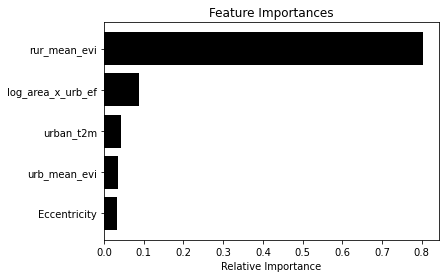

In [155]:
# plot the feature importance #
features = X_train.columns
importances = model.feature_importances_
indices = np.argsort(importances)

plt.title('Feature Importances')
plt.barh(range(len(indices)), importances[indices], color='k', align='center')
plt.yticks(range(len(indices)), [features[i] for i in indices])
plt.xlabel('Relative Importance')

Gaussian Process Regression

In [35]:
#############################################
######## GAUSSIAN PROCESS REGRESSION ########
#############################################

gpr = GaussianProcessRegressor()               # define the model

RBF_kernel = RBF()                             # define the kernels
Dot_Product_kernel = DotProduct()
Matern_kernel = Matern()
#carry out cross validation
folds = 5                                                                       #define the number of folds (K)
#specify the hyperparameters to test

hyper_params = [{'kernel':[RBF_kernel]                # using the RBF kernel
                ,'alpha':[1e-2, 1e-3, 1e-5, 1e-10]    # e-10 is the default alpha (value added to cov matrix diagonal)
                ,'n_restarts_optimizer':[0,20,50]          # number of restarts for the optimizer to find kernels parameters    
            } ,{'kernel':[Dot_Product_kernel]         # using the dot prod kernel
                ,'alpha':[1e-2, 1e-3, 1e-5, 1e-10]    
                ,'n_restarts_optimizer':[0,20,50] 
            }  ,{'kernel':[Matern_kernel]             # using the Matern kernel
                ,'alpha':[1e-2, 1e-3, 1e-5, 1e-10]    
                ,'n_restarts_optimizer':[0,20,50] 
            }]                 


#hyper_params = [{'kernel':[RBF_kernel]                # using the RBF kernel
#                ,'alpha':[1e-2, 1e-3, 1e-5, 1e-10]    # e-10 is the default alpha (value added to cov matrix diagonal)
#                ,'n_restarts_optimizer':[0,20,50]          # number of restarts for the optimizer to find kernels parameters    
#                }]   

#default value for max_iter = 1000
model_cv = GridSearchCV(estimator = gpr, 
                        param_grid = hyper_params, 
                        #scoring= 'r2',                        
                        cv = folds, 
                        verbose = 1,                                  #verbose- how detailed output is   
                        return_train_score=True) 

#fit the model
model_cv.fit(X_train_norm, y_train_norm)  

#cv results
cv_results = pd.DataFrame(model_cv.cv_results_)
cv_results

Fitting 5 folds for each of 36 candidates, totalling 180 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
C:\Anaconda3\envs\project_environment\lib\site-packages\sklearn\gaussian_process\_gpr.py:504: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  _check_optimize_result("lbfgs", opt_res)
C:\Anaconda3\envs\project_environment\lib\site-packages\sklearn\gaussian_process\_gpr.py:504: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  _check_optimize_result("lbfgs", opt_res)
C:\Anaconda3\envs\project_environment\lib\site-packages\sklearn\gaussian_process\_gpr.py:504: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Inc

C:\Anaconda3\envs\project_environment\lib\site-packages\sklearn\gaussian_process\_gpr.py:504: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  _check_optimize_result("lbfgs", opt_res)
C:\Anaconda3\envs\project_environment\lib\site-packages\sklearn\gaussian_process\_gpr.py:504: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  _check_optimize_result("lbfgs", opt_res)
C:\Anaconda3\envs\project_environment\lib\site-packages\sklearn\gaussian_process\_gpr.py:504: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    http

mean_fit_time  std_fit_time  mean_score_time  std_score_time param_alpha  \
0       16.568740      2.069867         0.518416        0.076434        0.01   
1      690.622517    227.953602         0.179719        0.037879        0.01   
2     1831.587606    615.856336         0.148211        0.013981        0.01   
3       14.242221      0.182526         0.561498        0.173564       0.001   
4     1148.715220    404.605857         0.197678        0.028703       0.001   
5     2699.574138    886.993134         0.183909        0.035231       0.001   
6       14.554470      0.235705         0.504461        0.101297     0.00001   
7      890.772754    280.503183         0.207048        0.023043     0.00001   
8     1761.578748    373.562897         0.172338        0.029250     0.00001   
9       12.107687      0.200121         0.388561        0.017668         0.0   
10     662.776939    183.456089         0.147797        0.018857         0.0   
11    1898.960938    161.524418         0.152593        0.019431         0.0   
12      62.757897     10.764737         0.051802        0.003370        0.01   
13    1414.378644    411.166496         0.057447        0.011945        0.01   
14    5387.791571   2863.859309         0.072350        0.022793        0.01   
15      92.611162     15.371400         0.070412        0.005300       0.001   
16    1335.847103    388.200169         0.084175        0.005592       0.001   
17    3968.474335   2183.567738         0.066622        0.003179       0.001   
18      64.868022     18.068864         0.062833        0.002442     0.00001   
19     811.977544    189.488738         0.062236        0.001850     0.00001   
20    1796.533725    505.747638         0.054256        0.008118     0.00001   
21      93.031979     63.013230         0.057646        0.006129         0.0   
22     594.921152    159.169966         0.055253        0.004618         0.0   
23    1734.571006    235.856686         0.051462        0.003656         0.0   
24      14.509114      0.321475         0.457587        0.010270        0.01   
25     864.733720    251.314907         0.240158        0.018663        0.01   
26    1710.731447    296.634512         0.232776        0.022941        0.01   
27      14.335267      0.216960         0.450197        0.014760       0.001   
28     805.500617    352.065204         0.251528        0.013056       0.001   
29    2060.505660    321.070260         0.231781        0.007637       0.001   
30      14.326577      0.089279         0.443816        0.022506     0.00001   
31     767.655979    105.687150         0.243212        0.022904     0.00001   
32    2140.220937    469.076881         0.271674        0.026050     0.00001   
33      14.488500      0.088656         0.458179        0.019129         0.0   
34     836.994494    149.842701         0.250133        0.018123         0.0   
35    1737.796659    223.948042         0.240358        0.023474         0.0   

                      param_kernel param_n_restarts_optimizer  \
0              RBF(length_scale=1)                          0   
1              RBF(length_scale=1)                         20   
2              RBF(length_scale=1)                         50   
3              RBF(length_scale=1)                          0   
4              RBF(length_scale=1)                         20   
5              RBF(length_scale=1)                         50   
6              RBF(length_scale=1)                          0   
7              RBF(length_scale=1)                         20   
8              RBF(length_scale=1)                         50   
9              RBF(length_scale=1)                          0   
10             RBF(length_scale=1)                         20   
11             RBF(length_scale=1)                         50   
12           DotProduct(sigma_0=1)                          0   
13           DotProduct(sigma_0=1)                         20   
14           DotProduct(sigma_0=1)                         50   
15 

In [36]:
model_cv.best_params_

{'alpha': 1e-05, 'kernel': DotProduct(sigma_0=1), 'n_restarts_optimizer': 20}

In [37]:
#Performance stats for gaussian porcess regression
y_train_pred = model_cv.predict(X_train_norm)
y_test_pred = model_cv.predict(X_test_norm)

#####################################################
###### Performance Metrics for the training set ######
######################################################
#rmse
train_gpr_mse = mean_squared_error(y_train_norm, y_train_pred)
train_gpr_rmse = np.sqrt(train_gpr_mse)
#r-square
train_gpr_r2 = r2_score(y_train_norm, y_train_pred)
#mae
train_gpr_mae = mean_absolute_error(y_train_norm, y_train_pred)
print('Training Metrics--', 'RMSE:', train_gpr_rmse, 'R-square:', train_gpr_r2, 'MAE:', train_gpr_mae)

#################################################
###### Performance Metrics for the test set #####
#################################################
#rmse
test_gpr_mse = mean_squared_error(y_test_norm, y_test_pred)
test_gpr_rmse = np.sqrt(test_gpr_mse)
#r-square
test_gpr_r2 = r2_score(y_test_norm, y_test_pred)
#mae
test_gpr_mae = mean_absolute_error(y_test_norm, y_test_pred)
print('Test Metrics--', 'RMSE:', test_gpr_rmse, 'R-square:', test_gpr_r2, 'MAE:', test_gpr_mae)


Training Metrics-- RMSE: 0.5671473930417582 R-square: 0.6783438345659376 MAE: 0.42822720407313924
Test Metrics-- RMSE: 0.46716504099644807 R-square: 0.6791592388534777 MAE: 0.3621576314401621


Generalised Additive Model

In [211]:
#generalised additive model (GAM) 
from pygam import LinearGAM, s, f     #import GAM for regression problems

# s are 2 spline terms, f is the linear function
#gam = LinearGAM(s(0) + s(1) + f(2)).fit(X_train_norm, y_train)

gam = LinearGAM().fit(X_train_norm, y_train)


In [212]:
gam.summary()

LinearGAM                                                                                                 
=============================================== ==========================================================
Distribution:                        NormalDist Effective DoF:                                    112.2367
Link Function:                     IdentityLink Log Likelihood:                                -11738.3119
Number of Samples:                         4691 AIC:                                            23703.0972
                                                AICc:                                             23708.75
                                                GCV:                                                4.5504
                                                Scale:                                              4.3549
                                                Pseudo R-Squared:                                    0.751
Feature Function                  Lam

C:\Anaconda3\envs\project_environment\lib\site-packages\ipykernel_launcher.py:1: UserWarning: KNOWN BUG: p-values computed in this summary are likely much smaller than they should be. 
 
Please do not make inferences based on these values! 

Collaborate on a solution, and stay up to date at: 
github.com/dswah/pyGAM/issues/163 

  """Entry point for launching an IPython kernel.


In [214]:
#Performance stats for GAM
y_train_pred = gam.predict(X_train_norm)
y_test_pred = gam.predict(X_test_norm)

#####################################################
###### Performance Metrics for the training set ######
######################################################
#rmse
gam_mse = mean_squared_error(y_train, y_train_pred)
gam_rmse = np.sqrt(gam_mse)
#r-square
gam_r2 = r2_score(y_train, y_train_pred)
#mae
gam_mae = mean_absolute_error(y_train, y_train_pred)
print('Training Metrics--', 'RMSE:', gam_rmse, 'R-square:', gam_r2, 'MAE:', gam_mae)

#################################################
###### Performance Metrics for the test set #####
#################################################
#rmse
test_gam_mse = mean_squared_error(y_test, y_test_pred)
test_gam_rmse = np.sqrt(test_gam_mse)
#r-square
test_gam_r2 = r2_score(y_test, y_test_pred)
#mae
test_gam_mae = mean_absolute_error(y_test, y_test_pred)
print('Test Metrics--', 'RMSE:', test_gam_rmse, 'R-square:', test_gam_r2, 'MAE:', test_gam_mae)


Training Metrics-- RMSE: 2.0617219622691523 R-square: 0.7509694779464747 MAE: 1.5267263869985257
Test Metrics-- RMSE: 2.1814383500529493 R-square: 0.5721600411819225 MAE: 1.695263093268475


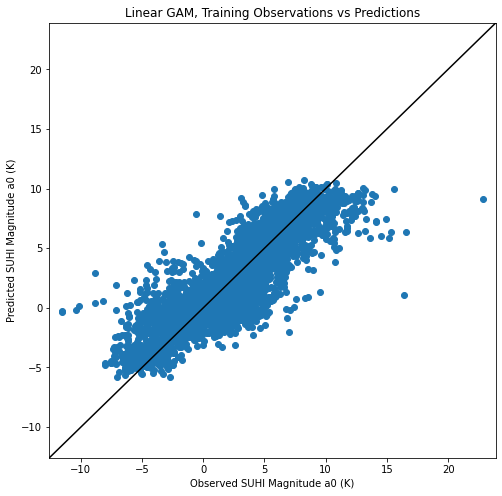

In [218]:
fig, axes = plt.subplots(1,1, figsize = (8, 8))

axes.scatter(y_train, y_train_pred)
axes.set(title = 'Linear GAM, Training Observations vs Predictions', 
         xlabel = 'Observed SUHI Magnitude a0 (K)', ylabel = 'Predicted SUHI Magnitude a0 (K)')
         #xlabel = 'Observed SUHI Mean (K)', ylabel = 'Predicted SUHI Mean (K)')

axesmin = min(min(y_train), min(y_train_pred)) - 1
axesmax = max(max(y_train), max(y_train_pred)) + 1

axes.set_xlim([axesmin, axesmax])
axes.set_ylim([axesmin, axesmax])

axes.plot([axesmin, axesmax],[axesmin, axesmax], color = 'k')

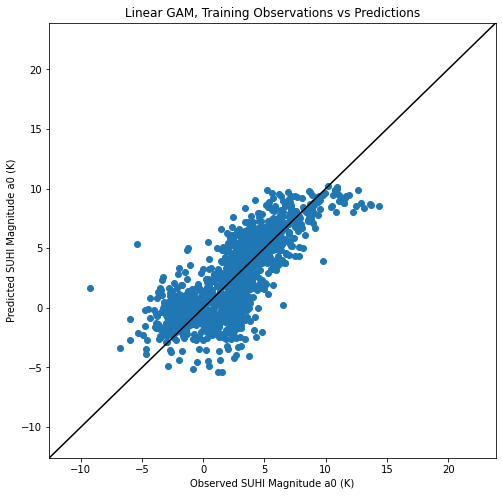

In [217]:
fig, axes = plt.subplots(1,1, figsize = (8, 8))

axes.scatter(y_test, y_test_pred)
axes.set(title = 'Linear GAM, Training Observations vs Predictions', 
         xlabel = 'Observed SUHI Magnitude a0 (K)', ylabel = 'Predicted SUHI Magnitude a0 (K)')
         #xlabel = 'Observed SUHI Mean (K)', ylabel = 'Predicted SUHI Mean (K)')

axesmin = min(min(y_train), min(y_train_pred)) - 1
axesmax = max(max(y_train), max(y_train_pred)) + 1

axes.set_xlim([axesmin, axesmax])
axes.set_ylim([axesmin, axesmax])

axes.plot([axesmin, axesmax],[axesmin, axesmax], color = 'k')

In [61]:
######################################
############ FINAL MODELS ############
######################################

# Parameters for the final models 

# MLR 
#predictor_variables = ['rur_mean_evi', 'urb_mean_evi','rural_ssr']
#target_variable = 'a0'

predictor_variables = predictor_variables_1 #['rur_mean_evi', 'urb_mean_evi','rural_ssr','log_area_x_urb_ef']
target_variable = 'a0'

#split the data into training and test

X_train = training_data[predictor_variables]  #predictors
y_train = training_data[target_variable]      #target

X_test = test_data[predictor_variables]       #predictors
y_test = test_data[target_variable]           #target

#create normalised datasets
#the test dataset is normalised using the normalisation parameters from the training data
scaler = StandardScaler()
X_train_norm = pd.DataFrame(scaler.fit_transform(X_train), columns = X_train.columns) #fit and transform
X_test_norm = pd.DataFrame(scaler.transform(X_test), columns = X_test.columns) #transform only
y_train_norm = pd.DataFrame(scaler.fit_transform(y_train.values.reshape(-1,1)), columns = [target_variable]) #fit and transform
y_test_norm = pd.DataFrame(scaler.transform(y_test.values.reshape(-1, 1)), columns = [target_variable]) #transform only

#Create linear regression object
lin_reg = LinearRegression()

#fit the model
lin_reg.fit(X_train_norm, y_train)

#predict the training 
y_train_pred = lin_reg.predict(X_train_norm)
#predict the test
y_test_pred = lin_reg.predict(X_test_norm)


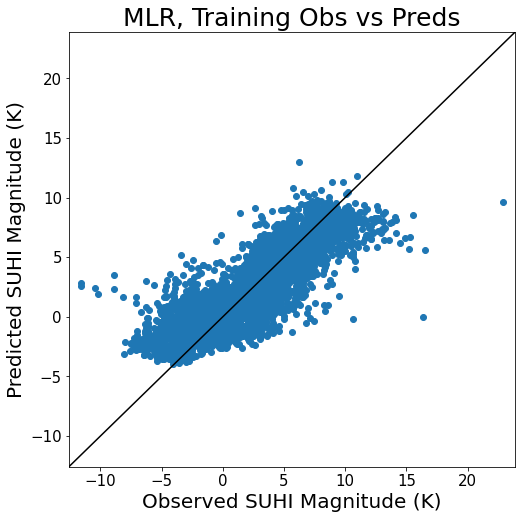

In [24]:
# Plotting 

#plt.rc('font', size=15)          # controls default text sizes
plt.rc('axes', titlesize=25)     # fontsize of the axes title
plt.rc('axes', labelsize=20)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=15)    # fontsize of the tick labels
plt.rc('ytick', labelsize=15)    # fontsize of the tick labels
#plt.rc('legend', fontsize=20)    # legend fontsize
plt.rc('figure', titlesize=20)  # fontsize of the figure title

fig, axes = plt.subplots(1,1, figsize = (8, 8))
axes.scatter(y_train, y_train_pred)
axes.set(title = 'MLR, Training Obs vs Preds', 
         xlabel = 'Observed SUHI Magnitude (K)', ylabel = 'Predicted SUHI Magnitude (K)')
         #xlabel = 'Observed SUHI Mean (K)', ylabel = 'Predicted SUHI Mean (K)')

axesmin = min(min(y_train), min(y_train_pred)) - 1
axesmax = max(max(y_train), max(y_train_pred)) + 1

axes.set_xlim([axesmin, axesmax])
axes.set_ylim([axesmin, axesmax])

axes.plot([axesmin, axesmax],[axesmin, axesmax], color = 'k')

#save figure as png
os.chdir(os.path.join(et.io.HOME, 'Documents', 'Python_Scripts', 'PROJECT','Graphs_outputs','pred_modelling'))   
plt.savefig('mlr_training.png', bbox_inches = 'tight')

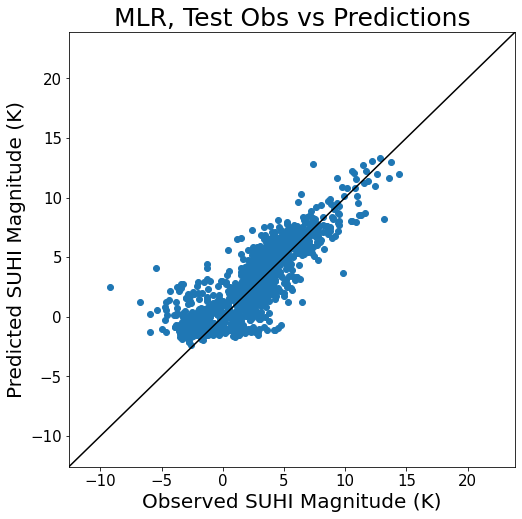

In [25]:
fig, axes = plt.subplots(1,1, figsize = (8, 8))

axes.scatter(y_test, y_test_pred)
axes.set(title = 'MLR, Test Obs vs Predictions', 
         xlabel = 'Observed SUHI Magnitude (K)', ylabel = 'Predicted SUHI Magnitude (K)')
         #xlabel = 'Observed SUHI Mean (K)', ylabel = 'Predicted SUHI Mean (K)')

#axesmin = min(min(y_test), min(y_test_pred)) - 1
#axesmax = max(max(y_test), max(y_test_pred)) + 1

axes.set_xlim([axesmin, axesmax])
axes.set_ylim([axesmin, axesmax])

axes.plot([axesmin, axesmax],[axesmin, axesmax], color = 'k')

#save figure as png
os.chdir(os.path.join(et.io.HOME, 'Documents', 'Python_Scripts', 'PROJECT','Graphs_outputs','pred_modelling'))   
plt.savefig('mlr_test.png', bbox_inches = 'tight')

In [17]:

######################################################
###### Performance Metrics for the training set ######
######################################################
#rmse
train_lin_mse = mean_squared_error(y_train, y_train_pred)
train_lin_rmse = np.sqrt(train_lin_mse)
#r-square
train_lin_r2 = r2_score(y_train, y_train_pred)
#mae
train_lin_mae = mean_absolute_error(y_train, y_train_pred)
print('Training Metrics--', 'RMSE:', train_lin_rmse, 'R-square:', train_lin_r2, 'MAE:', train_lin_mae)

#################################################
###### Performance Metrics for the test set #####
#################################################
#rmse
test_lin_mse = mean_squared_error(y_test, y_test_pred)
test_lin_rmse = np.sqrt(test_lin_mse)
#r-square
test_lin_r2 = r2_score(y_test, y_test_pred)
#mae
test_lin_mae = mean_absolute_error(y_test, y_test_pred)
print('Test Metrics--', 'RMSE:', test_lin_rmse, 'R-square:', test_lin_r2, 'MAE:', test_lin_mae)

Training Metrics-- RMSE: 2.2737410103632043 R-square: 0.6971173652058751 MAE: 1.701932083733465
Test Metrics-- RMSE: 1.874437821197997 R-square: 0.6841087958854347 MAE: 1.4212491593761876


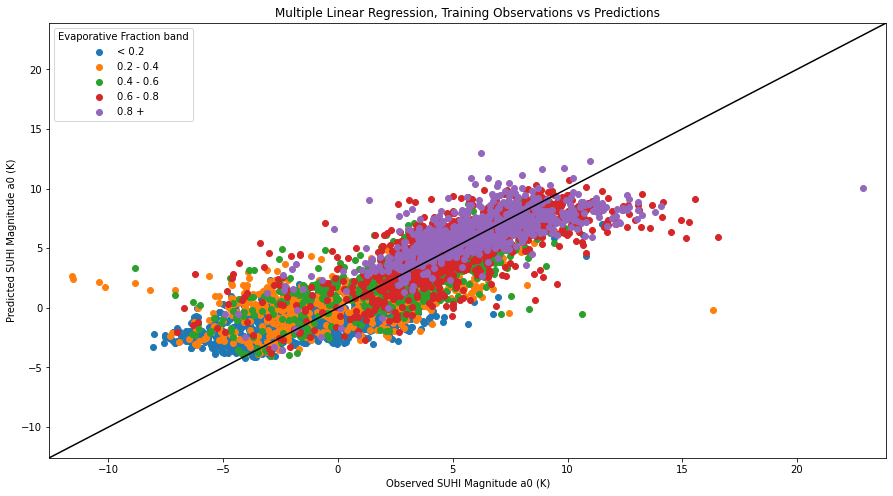

In [146]:
# adding the ef bound to the plots
training_data['ef_bound'] = '< 0.2'
training_data.loc[(training_data['rural_evap_fract'] > 0.2) & (training_data['rural_evap_fract'] < 0.4), 'ef_bound'] = '0.2 - 0.4'
training_data.loc[(training_data['rural_evap_fract'] > 0.4) & (training_data['rural_evap_fract'] < 0.6), 'ef_bound'] = '0.4 - 0.6'
training_data.loc[(training_data['rural_evap_fract'] > 0.6) & (training_data['rural_evap_fract'] < 0.8), 'ef_bound'] = '0.6 - 0.8'
training_data.loc[(training_data['rural_evap_fract'] > 0.8), 'ef_bound'] = '0.8 +'

fig, axes = plt.subplots(1,1, figsize = (15, 8))

ef_bands = ['< 0.2', '0.2 - 0.4','0.4 - 0.6',  '0.6 - 0.8','0.8 +']

for count, ef_bound in enumerate(ef_bands):
    y_train2 = y_train[training_data.ef_bound == ef_bound]
    y_train_pred2 = y_train_pred[training_data.ef_bound == ef_bound]
    axes.scatter(y_train2, y_train_pred2, label = ef_bound )


axes.set(title = 'Multiple Linear Regression, Training Observations vs Predictions', 
         xlabel = 'Observed SUHI Magnitude a0 (K)', ylabel = 'Predicted SUHI Magnitude a0 (K)')
         #xlabel = 'Observed SUHI Mean (K)', ylabel = 'Predicted SUHI Mean (K)')
axes.legend(title = 'Evaporative Fraction band')

axesmin = min(min(y_train), min(y_train_pred)) - 1
axesmax = max(max(y_train), max(y_train_pred)) + 1

axes.set_xlim([axesmin, axesmax])
axes.set_ylim([axesmin, axesmax])

axes.plot([axesmin, axesmax],[axesmin, axesmax], color = 'k')

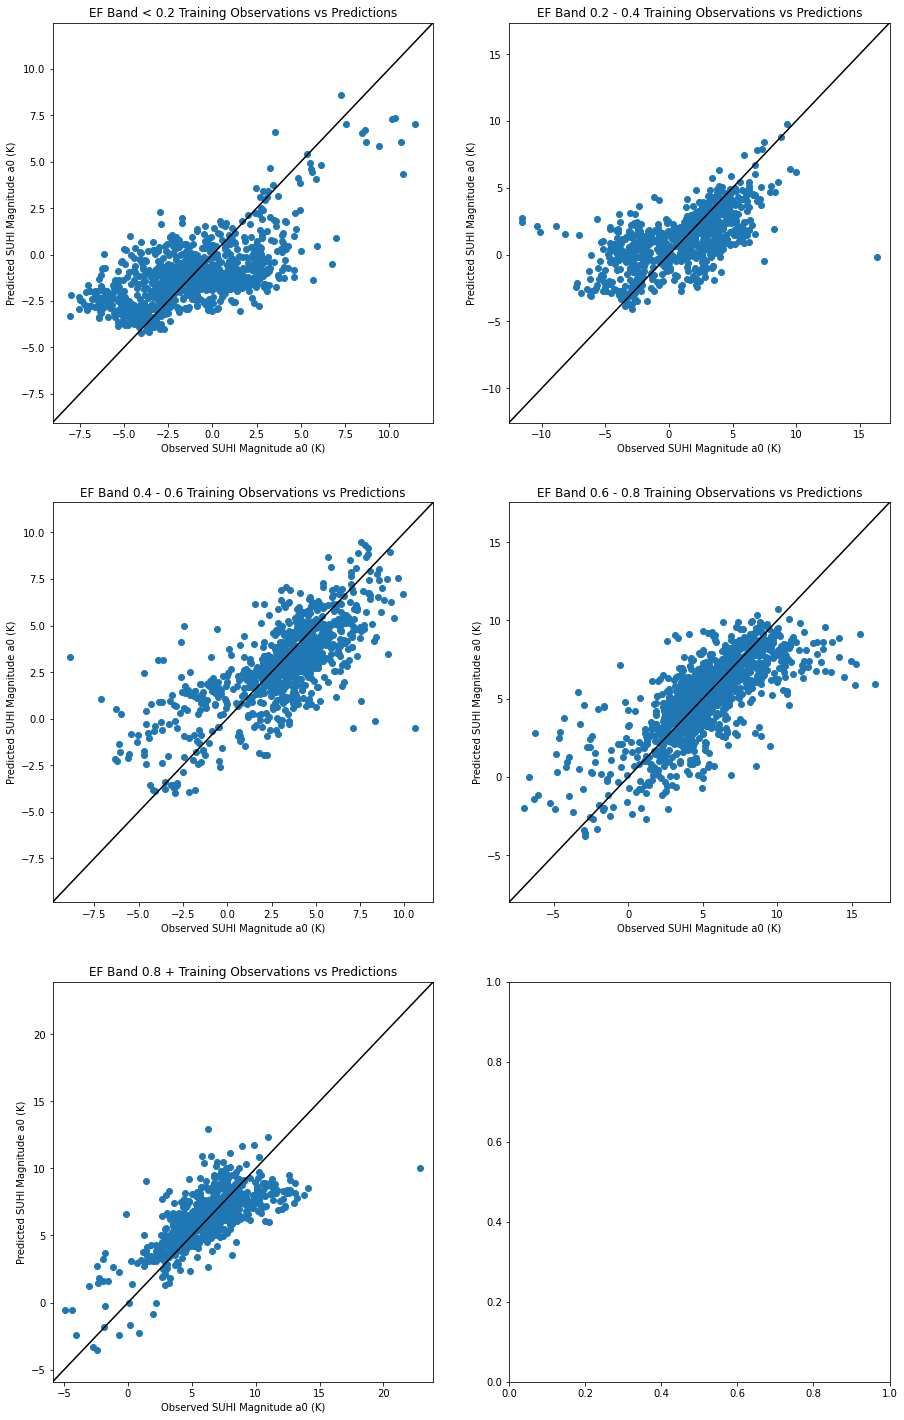

In [147]:
fig, axes = plt.subplots(3,2, figsize = (15, 25))

ef_bands = ['< 0.2', '0.2 - 0.4','0.4 - 0.6',  '0.6 - 0.8','0.8 +']

for count, ef_bound in enumerate(ef_bands):
    y_train2 = y_train[training_data.ef_bound == ef_bound]
    y_train_pred2 = y_train_pred[training_data.ef_bound == ef_bound]
    
    plotrow = int((count - count%2)/2)
    plotcol = int(count%2)
    
    axes[plotrow, plotcol].scatter(y_train2, y_train_pred2, label = ef_bound)

    axes[plotrow, plotcol].set(title = 'EF Band {} Training Observations vs Predictions'.format(ef_bound), 
         xlabel = 'Observed SUHI Magnitude a0 (K)', ylabel = 'Predicted SUHI Magnitude a0 (K)')

    axesmin = min(min(y_train2), min(y_train_pred2)) - 1
    axesmax = max(max(y_train2), max(y_train_pred2)) + 1

    axes[plotrow, plotcol].set_xlim([axesmin, axesmax])
    axes[plotrow, plotcol].set_ylim([axesmin, axesmax])

    axes[plotrow, plotcol].plot([axesmin, axesmax],[axesmin, axesmax], color = 'k')

[Text(0.5, 1.0, 'PDPs for MLR with normalised variables'),
 Text(0.5, 0, 'Partial Dependence (K)')]

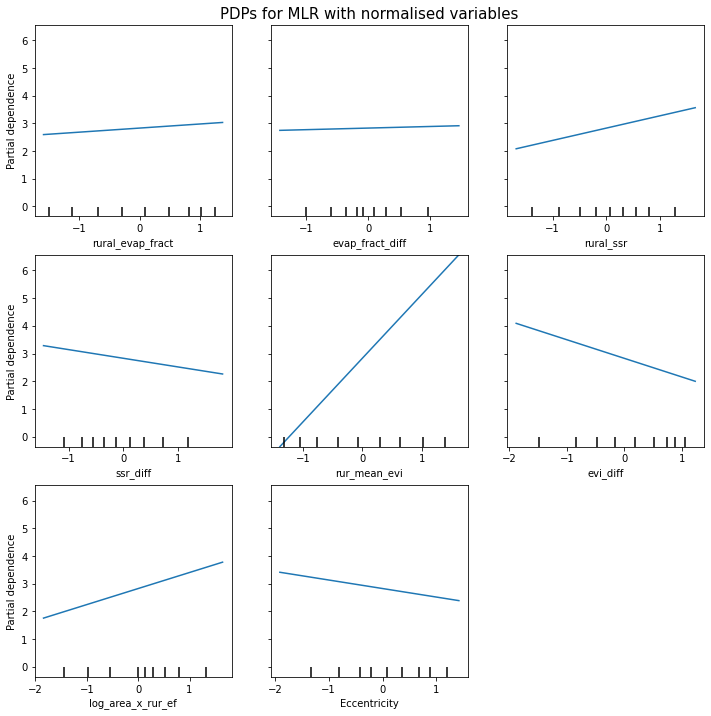

In [18]:
fig, axes = plt.subplots(figsize=(12, 12))

#PartialDependenceDisplay.from_estimator(clf, X, features)
mlr_disp = PartialDependenceDisplay.from_estimator(lin_reg, X_train_norm, ["rural_evap_fract","evap_fract_diff",
                                  'rural_ssr','ssr_diff','rur_mean_evi','evi_diff','log_area_x_rur_ef','Eccentricity'], 
                                   ax=axes)

axes.set(title = 'PDPs for MLR with normalised variables', xlabel = 'Partial Dependence (K)')

In [6]:
X_train_norm

evap_fract_diff  rural_evap_fract  ssr_diff  rural_ssr  rur_mean_evi  \
0            0.934129         -0.123724 -1.769262   0.571057     -0.818865   
1            0.558530         -0.313152 -1.826196   0.737615     -0.838907   
2            0.041506         -0.244026 -1.502811   1.164756     -0.447151   
3           -0.885230          0.809375 -1.506921   1.183329     -0.385253   
4           -0.756623          0.849174 -0.899131   0.650407      0.022577   
...               ...               ...       ...        ...           ...   
4686         0.107511          0.333358 -0.864010   0.198913     -0.599352   
4687         0.646150          0.481818 -1.124306   0.423624     -0.321085   
4688        -0.170378         -0.715467 -0.854564   0.082228     -0.678532   
4689        -0.130778         -1.612713 -1.117612   0.338478     -0.990947   
4690        -0.157018         -1.674028 -0.914119  -0.035536     -1.080189   

      evi_diff  log_area_x_rur_ef  Eccentricity  
0     1.124586           0.667936      1.000223  
1     0.930156           0.667936      1.000223  
2     0.339957           0.667936      1.000223  
3     0.409233           0.667936      1.000223  
4     0.061057           0.667936      1.000223  
...        ...                ...           ...  
4686  0.507234          -1.365156      0.190135  
4687  0.259143          -1.365156      0.190135  
4688  0.432221          -1.365156      0.190135  
4689  0.838004          -1.365156      0.190135  
4690  1.026226          -1.365156      0.190135  

[4691 rows x 8 columns]

In [175]:
###### Ridge Regression #######

#define regression model 
ridge_reg = Ridge(alpha = 500, fit_intercept=True)

#fit the model
ridge_reg.fit(X_train_norm, y_train)

#predict the training 
y_train_pred = lin_reg.predict(X_train_norm)
#predict the test
y_test_pred = lin_reg.predict(X_test_norm)

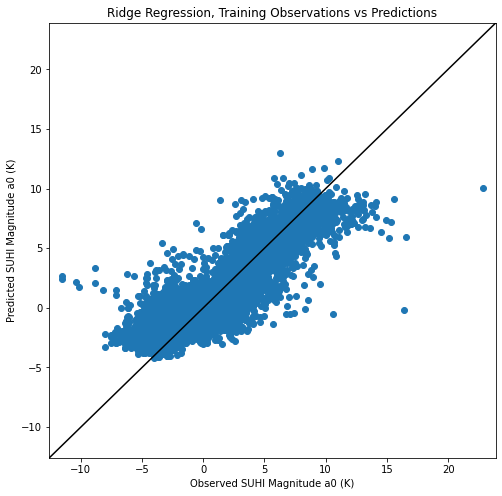

In [176]:
fig, axes = plt.subplots(1,1, figsize = (8, 8))

axes.scatter(y_train, y_train_pred)
axes.set(title = 'Ridge Regression, Training Observations vs Predictions', 
         xlabel = 'Observed SUHI Magnitude a0 (K)', ylabel = 'Predicted SUHI Magnitude a0 (K)')
         #xlabel = 'Observed SUHI Mean (K)', ylabel = 'Predicted SUHI Mean (K)')

axesmin = min(min(y_train), min(y_train_pred)) - 1
axesmax = max(max(y_train), max(y_train_pred)) + 1

axes.set_xlim([axesmin, axesmax])
axes.set_ylim([axesmin, axesmax])

axes.plot([axesmin, axesmax],[axesmin, axesmax], color = 'k')

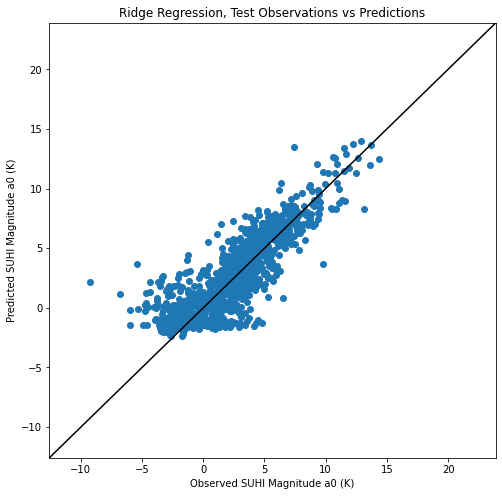

In [177]:
fig, axes = plt.subplots(1,1, figsize = (8, 8))

axes.scatter(y_test, y_test_pred)
axes.set(title = 'Ridge Regression, Test Observations vs Predictions', 
         xlabel = 'Observed SUHI Magnitude a0 (K)', ylabel = 'Predicted SUHI Magnitude a0 (K)')
         #xlabel = 'Observed SUHI Mean (K)', ylabel = 'Predicted SUHI Mean (K)')

#axesmin = min(min(y_test), min(y_test_pred)) - 1
#axesmax = max(max(y_test), max(y_test_pred)) + 1

axes.set_xlim([axesmin, axesmax])
axes.set_ylim([axesmin, axesmax])

axes.plot([axesmin, axesmax],[axesmin, axesmax], color = 'k')

In [27]:
##### Random Forest Regression #######

# The model will have to be run again as due to bagging there is an element of randomness #

forest_reg = RandomForestRegressor()                                  #define the model

#fit the Peak Magnitude a0 model

predictor_variables = predictor_variables_1
#['rur_mean_evi', 'log_area_x_urb_ef','rural_ssr', 'Eccentricity', 'urb_mean_evi', 'urban_t2m']
target_variable = 'a0'

#split the data into training and test

X_train = training_data[predictor_variables]  #predictors
y_train = training_data[target_variable]      #target

X_test = test_data[predictor_variables]       #predictors
y_test = test_data[target_variable]           #target

#create normalised datasets
#the test dataset is normalised using the normalisation parameters from the training data
scaler = StandardScaler()
X_train_norm = pd.DataFrame(scaler.fit_transform(X_train), columns = X_train.columns) #fit and transform
X_test_norm = pd.DataFrame(scaler.transform(X_test), columns = X_test.columns) #transform only
y_train_norm = pd.DataFrame(scaler.fit_transform(y_train.values.reshape(-1,1)), columns = [target_variable]) #fit and transform
y_test_norm = pd.DataFrame(scaler.transform(y_test.values.reshape(-1, 1)), columns = [target_variable]) #transform only

#carry out cross validation
folds = 5                                                             #define the number of folds (K)
#specify the hyperparameters to test
#num_features_for_split = total_input_features/3
hyper_params = {'n_estimators':[5,10,20,40,60,80,100]                 #the number of trees
                ,'max_depth':[10,20,30,40,50,60,70,80,90,100,None]    #the tree depth
                ,'min_samples_leaf':[1,2,4,15]                        #min number of samples required at each leaf node
                ,'min_samples_split':[2,5,10,15] }                    #min number of samples required to split a node

#use cross validation to determine the hyperparameter value
model_target_a0 = GridSearchCV(estimator = forest_reg, 
                        param_grid = hyper_params, 
                        #scoring= 'r2', 
                        cv = folds, 
                        verbose = 1,                                  #verbose- how detailed output is   
                        return_train_score=True) 
#fit the model
model_target_a0.fit(X_train_norm, y_train)

# save the model as pickle to be used later
os.chdir(os.path.join(et.io.HOME, 'Documents', 'Python_Scripts', 'PROJECT','UHI_Project_Pickle_Files','All_cities'))  
filename = 'finalised_model_rfr_a0.sav'
pickle.dump(model_target_a0, open(filename, 'wb'))

Fitting 5 folds for each of 1232 candidates, totalling 6160 fits


In [ ]:
#fit the mean magnitude model

predictor_variables = ['rur_mean_evi', 'urb_mean_evi','rural_ssr','log_area_x_urb_ef']
target_variable = 'method_2_SUHI'

#split the data into training and test

X_train = training_data[predictor_variables]  #predictors
y_train = training_data[target_variable]      #target

X_test = test_data[predictor_variables]       #predictors
y_test = test_data[target_variable]           #target

#create normalised datasets
#the test dataset is normalised using the normalisation parameters from the training data
scaler = StandardScaler()
X_train_norm = pd.DataFrame(scaler.fit_transform(X_train), columns = X_train.columns) #fit and transform
X_test_norm = pd.DataFrame(scaler.transform(X_test), columns = X_test.columns) #transform only
y_train_norm = pd.DataFrame(scaler.fit_transform(y_train.values.reshape(-1,1)), columns = [target_variable]) #fit and transform
y_test_norm = pd.DataFrame(scaler.transform(y_test.values.reshape(-1, 1)), columns = [target_variable]) #transform only

#carry out cross validation
folds = 5                                                             #define the number of folds (K)
#specify the hyperparameters to test
#num_features_for_split = total_input_features/3
hyper_params = {'n_estimators':[5,10,20,40,60,80,100]                 #the number of trees
                ,'max_depth':[10,20,30,40,50,60,70,80,90,100,None]    #the tree depth
                ,'min_samples_leaf':[1,2,4,15]                        #min number of samples required at each leaf node
                ,'min_samples_split':[2,5,10,15] }                    #min number of samples required to split a node

#use cross validation to determine the hyperparameter value
model_target_mean_SUHI = GridSearchCV(estimator = forest_reg, 
                        param_grid = hyper_params, 
                        #scoring= 'r2', 
                        cv = folds, 
                        verbose = 1,                                  #verbose- how detailed output is   
                        return_train_score=True) 
#fit the model
model_target_mean_SUHI.fit(X_train_norm, y_train)

# save the model as pickle to be used later
os.chdir(os.path.join(et.io.HOME, 'Documents', 'Python_Scripts', 'PROJECT','UHI_Project_Pickle_Files','All_cities'))  
filename = 'finalised_model_rfr_mean_SUHI.sav'
pickle.dump(model_target_mean_SUHI, open(filename, 'wb'))


In [12]:
# read in the models
os.chdir(os.path.join(et.io.HOME, 'Documents', 'Python_Scripts', 'PROJECT','UHI_Project_Pickle_Files','All_cities'))   
filename = 'finalised_model_rfr_a0.sav'
model_target_a0 = pickle.load(open(filename, 'rb'))

#filename = 'finalised_model_rfr_mean_SUHI.sav'
#model_target_mean_SUHI = pickle.load(open(filename, 'rb'))

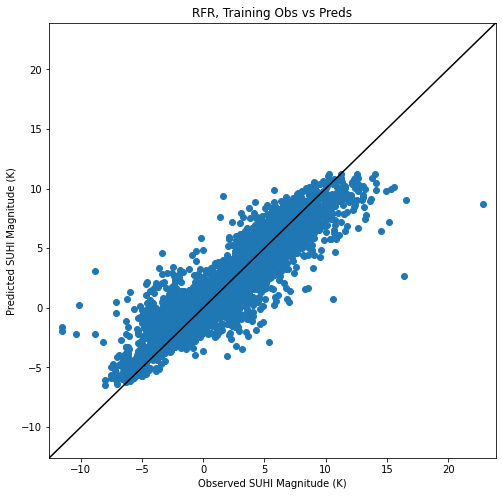

In [14]:
#plots

#use the models to make predictins then plot 
#predict the training 
y_train_pred = model_target_a0.predict(X_train_norm)
#predict the test
y_test_pred = model_target_a0.predict(X_test_norm)

fig, axes = plt.subplots(1,1, figsize = (8, 8))

axes.scatter(y_train, y_train_pred)
axes.set(title = 'RFR, Training Obs vs Preds', 
         xlabel = 'Observed SUHI Magnitude (K)', ylabel = 'Predicted SUHI Magnitude (K)')
         #xlabel = 'Observed SUHI Mean (K)', ylabel = 'Predicted SUHI Mean (K)')

axesmin = min(min(y_train), min(y_train_pred)) - 1
axesmax = max(max(y_train), max(y_train_pred)) + 1

axes.set_xlim([axesmin, axesmax])
axes.set_ylim([axesmin, axesmax])

axes.plot([axesmin, axesmax],[axesmin, axesmax], color = 'k')

#save figure as png
os.chdir(os.path.join(et.io.HOME, 'Documents', 'Python_Scripts', 'PROJECT','Graphs_outputs','pred_modelling'))   
plt.savefig('rfr_training.png', bbox_inches = 'tight')

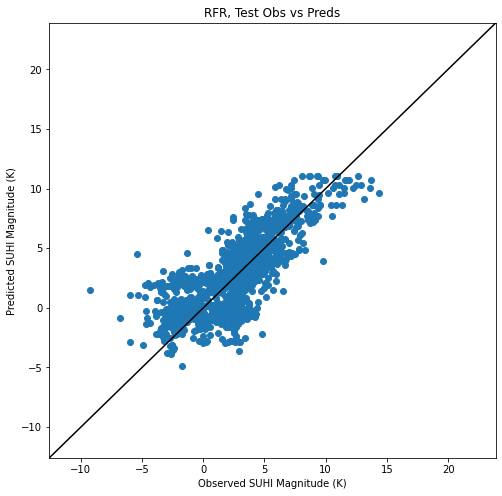

In [15]:
# Plot test

fig, axes = plt.subplots(1,1, figsize = (8, 8))

axes.scatter(y_test, y_test_pred)
axes.set(title = 'RFR, Test Obs vs Preds', 
         xlabel = 'Observed SUHI Magnitude (K)', ylabel = 'Predicted SUHI Magnitude (K)')
         #xlabel = 'Observed SUHI Mean (K)', ylabel = 'Predicted SUHI Mean (K)')

#axesmin = min(min(y_test), min(y_test_pred)) - 1
#axesmax = max(max(y_test), max(y_test_pred)) + 1

axes.set_xlim([axesmin, axesmax])
axes.set_ylim([axesmin, axesmax])

axes.plot([axesmin, axesmax],[axesmin, axesmax], color = 'k')

#save figure as png
os.chdir(os.path.join(et.io.HOME, 'Documents', 'Python_Scripts', 'PROJECT','Graphs_outputs','pred_modelling'))   
plt.savefig('rfr_test.png', bbox_inches = 'tight')

In [13]:
#Performance stats for random forest regression

#####################################################
###### Performance Metrics for the training set ######
######################################################
#rmse
train_forest_mse = mean_squared_error(y_train, y_train_pred)
train_forest_rmse = np.sqrt(train_forest_mse)
#r-square
train_forest_r2 = r2_score(y_train, y_train_pred)
#mae
train_forest_mae = mean_absolute_error(y_train, y_train_pred)
print('Training Metrics--', 'RMSE:', train_forest_rmse, 'R-square:', train_forest_r2, 'MAE:', train_forest_mae)

#################################################
###### Performance Metrics for the test set #####
#################################################
#rmse
test_forest_mse = mean_squared_error(y_test, y_test_pred)
test_forest_rmse = np.sqrt(test_forest_mse)
#r-square
test_forest_r2 = r2_score(y_test, y_test_pred)
#mae
test_forest_mae = mean_absolute_error(y_test, y_test_pred)
print('Test Metrics--', 'RMSE:', test_forest_rmse, 'R-square:', test_forest_r2, 'MAE:', test_forest_mae)


Training Metrics-- RMSE: 4.471192892519324 R-square: -0.1712219340942549 MAE: 3.8159093802940105
Test Metrics-- RMSE: 3.730852179204259 R-square: -0.2514443455153863 MAE: 3.155454514720009


[Text(0.5, 1.0, 'PDPs for RFR with normalised variables'),
 Text(0.5, 0, 'Partial Dependence (K)')]

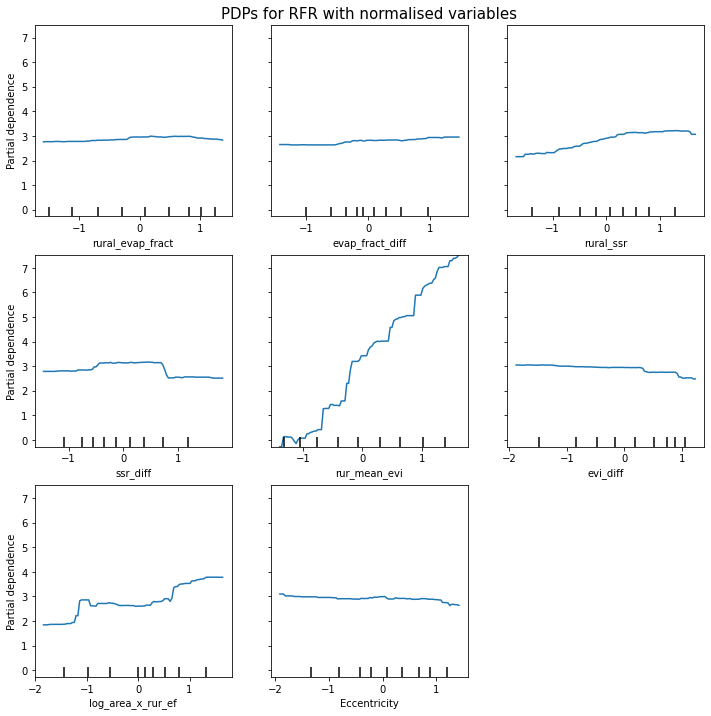

In [15]:
fig, axes = plt.subplots(figsize=(12, 12))
#plt.rc('font', size=15)          # controls default text sizes
plt.rc('axes', titlesize=15)     # fontsize of the axes title
plt.rc('axes', labelsize=10)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=10)    # fontsize of the tick labels
plt.rc('ytick', labelsize=10)    # fontsize of the tick labels
#plt.rc('legend', fontsize=20)    # legend fontsize
plt.rc('figure', titlesize=10)  # fontsize of the figure title
#PartialDependenceDisplay.from_estimator(clf, X, features)
rfr_disp = PartialDependenceDisplay.from_estimator(model_target_a0, X_train_norm, ["rural_evap_fract","evap_fract_diff",
                                  'rural_ssr','ssr_diff','rur_mean_evi','evi_diff','log_area_x_rur_ef','Eccentricity'], 
                                   ax=axes)

axes.set(title = 'PDPs for RFR with normalised variables', xlabel = 'Partial Dependence (K)')

[Text(0.5, 0, 'Normalised Eccentricity')]

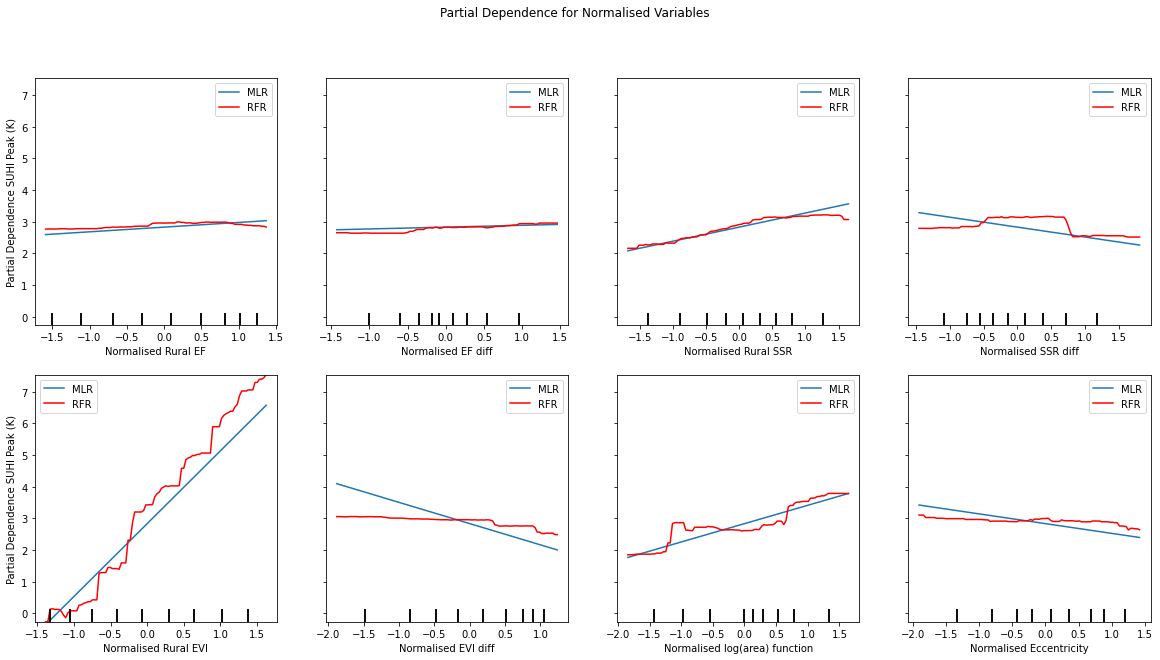

In [32]:
#plot the MLR and RFR models on the same axes
fig, axes = plt.subplots(2, 4, figsize=(20, 10))
fig.suptitle('Partial Dependence for Normalised Variables')

mlr_disp.plot(ax=axes, line_kw={"label": "MLR"})
rfr_disp.plot(
    ax=axes, line_kw={"label": "RFR", "color": "red"})

axes[0,0].set( ylabel = 'Partial Dependence SUHI Peak (K)' , xlabel = 'Normalised Rural EF')
axes[0,1].set( xlabel = 'Normalised EF diff')
axes[0,2].set( xlabel = 'Normalised Rural SSR')
axes[0,3].set( xlabel = 'Normalised SSR diff')
axes[1,0].set( ylabel = 'Partial Dependence SUHI Peak (K)' , xlabel = 'Normalised Rural EVI')
axes[1,1].set( xlabel = 'Normalised EVI diff')
axes[1,2].set( xlabel = 'Normalised log(area) function')
axes[1,3].set( xlabel = 'Normalised Eccentricity')


[Text(0.5, 1.0, 'PDP & ICE for RFR with normalised variables'),
 Text(0.5, 0, 'Partial Dependence (K)')]

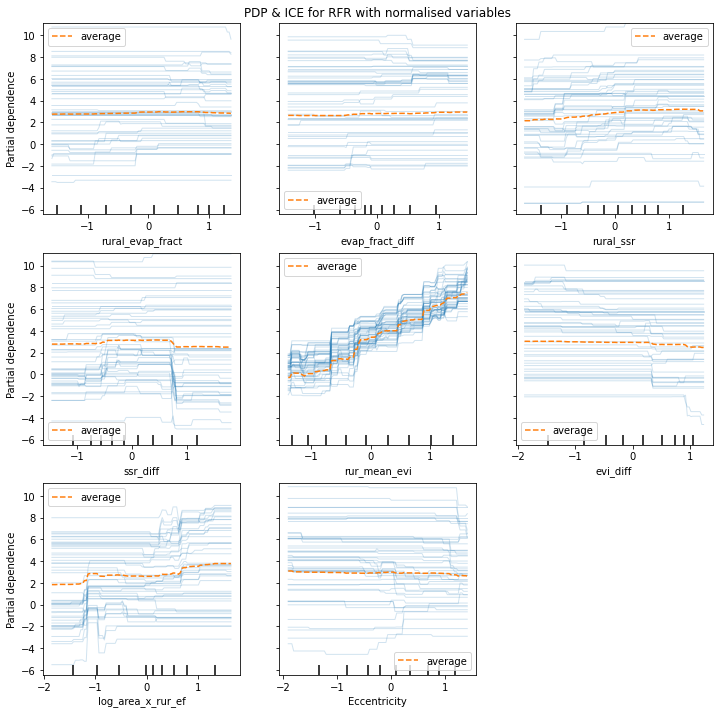

In [40]:
#PDP with ICE plot lines
#RFR
fig, axes = plt.subplots(figsize=(12, 12))

#PartialDependenceDisplay.from_estimator(clf, X, features)
rfr_disp = PartialDependenceDisplay.from_estimator(model_target_a0, X_train_norm, ["rural_evap_fract","evap_fract_diff",
            'rural_ssr','ssr_diff','rur_mean_evi','evi_diff','log_area_x_rur_ef','Eccentricity'], kind = 'both',
            ice_lines_kw={"color": "tab:blue", "alpha": 0.2, "linewidth": 1},
            pd_line_kw={"color": "tab:orange", "linestyle": "--"},
            subsample=50,  ax=axes)

axes.set(title = 'PDP & ICE for RFR with normalised variables', xlabel = 'Partial Dependence (K)')

[Text(0.5, 1.0, 'PDP & ICE for MLR with normalised variables'),
 Text(0.5, 0, 'Partial Dependence (K)')]

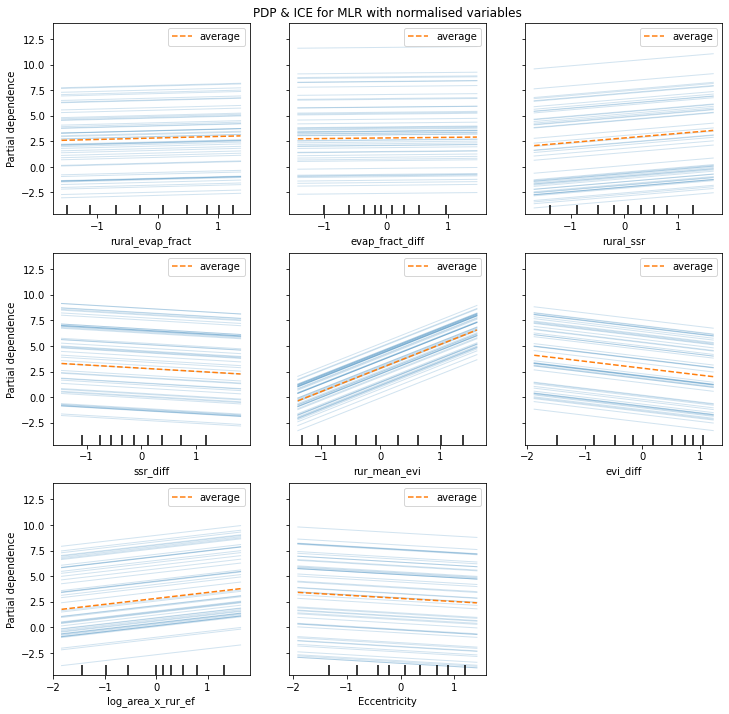

In [42]:
#MLR
fig, axes = plt.subplots(figsize=(12, 12))

#PartialDependenceDisplay.from_estimator(clf, X, features)
rfr_disp = PartialDependenceDisplay.from_estimator(lin_reg, X_train_norm, ["rural_evap_fract","evap_fract_diff",
            'rural_ssr','ssr_diff','rur_mean_evi','evi_diff','log_area_x_rur_ef','Eccentricity'], kind = 'both',
            ice_lines_kw={"color": "tab:blue", "alpha": 0.2, "linewidth": 1},
            pd_line_kw={"color": "tab:orange", "linestyle": "--"},
            subsample=50,  ax=axes)

axes.set(title = 'PDP & ICE for MLR with normalised variables', xlabel = 'Partial Dependence (K)')

In [206]:
#Gaussian Process Regression

#read in the model
os.chdir(os.path.join(et.io.HOME, 'Documents', 'Python_Scripts', 'PROJECT','UHI_Project_Pickle_Files','All_cities'))  
filename = 'finalised_model_gpr_a0.sav'
model_gpr_target_a0 = pickle.load(open(filename, 'rb'))

model_gpr_target_a0.best_params_

{'alpha': 0.001, 'kernel': DotProduct(sigma_0=1), 'n_restarts_optimizer': 20}

In [216]:
# not normalised model
os.chdir(os.path.join(et.io.HOME, 'Documents', 'Python_Scripts', 'PROJECT','UHI_Project_Pickle_Files','All_cities'))  
filename = 'y_not_norm_model_gpr_a0.sav'
model_gpr_target_a0 = pickle.load(open(filename, 'rb'))

model_gpr_target_a0.best_params_

{'alpha': 0.01, 'kernel': DotProduct(sigma_0=1), 'n_restarts_optimizer': 20}

In [207]:
#Performance stats for gaussian porcess regression
# Use model to make predictions
y_train_pred = model_gpr_target_a0.predict(X_train_norm)
y_test_pred = model_gpr_target_a0.predict(X_test_norm)

#####################################################
###### Performance Metrics for the training set ######
######################################################
#rmse
train_gpr_mse = mean_squared_error(y_train_norm, y_train_pred)
train_gpr_rmse = np.sqrt(train_gpr_mse)
#r-square
train_gpr_r2 = r2_score(y_train_norm, y_train_pred)
#mae
train_gpr_mae = mean_absolute_error(y_train_norm, y_train_pred)
print('Training Metrics--', 'RMSE:', train_gpr_rmse, 'R-square:', train_gpr_r2, 'MAE:', train_gpr_mae)

#################################################
###### Performance Metrics for the test set #####
#################################################
#rmse
test_gpr_mse = mean_squared_error(y_test_norm, y_test_pred)
test_gpr_rmse = np.sqrt(test_gpr_mse)
#r-square
test_gpr_r2 = r2_score(y_test_norm, y_test_pred)
#mae
test_gpr_mae = mean_absolute_error(y_test_norm, y_test_pred)
print('Test Metrics--', 'RMSE:', test_gpr_rmse, 'R-square:', test_gpr_r2, 'MAE:', test_gpr_mae)



Training Metrics-- RMSE: 0.5503518860383964 R-square: 0.69711280153398 MAE: 0.41192188184697
Test Metrics-- RMSE: 0.45420661724317285 R-square: 0.6834006741963237 MAE: 0.34439461190952964


In [209]:
#Performance stats for gaussian porcess regression
# Use model to make predictions

# NOT NORMALISED Y #

y_train_pred = model_gpr_target_a0.predict(X_train_norm)
y_test_pred = model_gpr_target_a0.predict(X_test_norm)

#####################################################
###### Performance Metrics for the training set ######
######################################################
#rmse
train_gpr_mse = mean_squared_error(y_train, y_train_pred)
train_gpr_rmse = np.sqrt(train_gpr_mse)
#r-square
train_gpr_r2 = r2_score(y_train, y_train_pred)
#mae
train_gpr_mae = mean_absolute_error(y_train, y_train_pred)
print('Training Metrics--', 'RMSE:', train_gpr_rmse, 'R-square:', train_gpr_r2, 'MAE:', train_gpr_mae)

#################################################
###### Performance Metrics for the test set #####
#################################################
#rmse
test_gpr_mse = mean_squared_error(y_test, y_test_pred)
test_gpr_rmse = np.sqrt(test_gpr_mse)
#r-square
test_gpr_r2 = r2_score(y_test, y_test_pred)
#mae
test_gpr_mae = mean_absolute_error(y_test, y_test_pred)
print('Test Metrics--', 'RMSE:', test_gpr_rmse, 'R-square:', test_gpr_r2, 'MAE:', test_gpr_mae)



Training Metrics-- RMSE: 2.273741010383166 R-square: 0.6971173652005569 MAE: 1.701931815790432
Test Metrics-- RMSE: 1.8744383234190576 R-square: 0.6841086266109622 MAE: 1.4212500316023766


In [7]:
# for normalised y
y_train_pred_2 = scaler.inverse_transform(y_train_pred)
y_test_pred_2 = scaler.inverse_transform(y_test_pred)

In [210]:
# for not normalised y
y_train_pred_2 = y_train_pred
y_test_pred_2 = y_test_pred

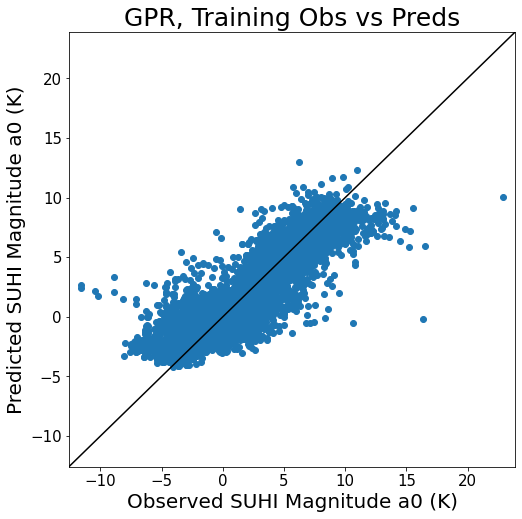

In [211]:
# Look at obs vs preds
# TRAINING #

#plt.rc('font', size=15)          # controls default text sizes
plt.rc('axes', titlesize=25)     # fontsize of the axes title
plt.rc('axes', labelsize=20)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=15)    # fontsize of the tick labels
plt.rc('ytick', labelsize=15)    # fontsize of the tick labels
#plt.rc('legend', fontsize=20)    # legend fontsize
plt.rc('figure', titlesize=20)  # fontsize of the figure title


fig, axes = plt.subplots(1,1, figsize = (8, 8))

axes.scatter(y_train, y_train_pred_2)
axes.set(title = 'GPR, Training Obs vs Preds', 
         xlabel = 'Observed SUHI Magnitude a0 (K)', ylabel = 'Predicted SUHI Magnitude a0 (K)')
         #xlabel = 'Observed SUHI Mean (K)', ylabel = 'Predicted SUHI Mean (K)')

axesmin = min(min(y_train), min(y_train_pred_2)) - 1
axesmax = max(max(y_train), max(y_train_pred_2)) + 1

axes.set_xlim([axesmin, axesmax])
axes.set_ylim([axesmin, axesmax])

axes.plot([axesmin, axesmax],[axesmin, axesmax], color = 'k')

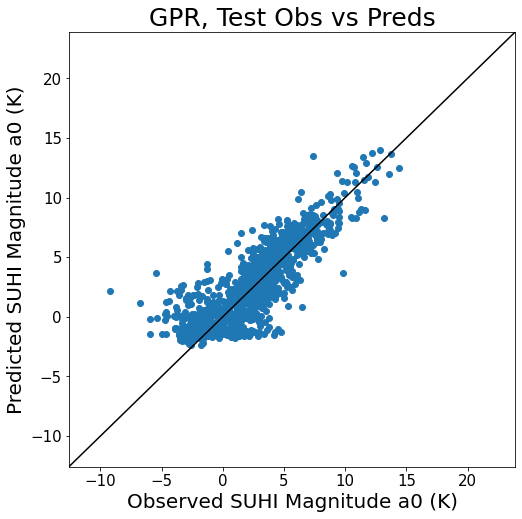

In [212]:
# Look at obs vs preds
# TEST #

fig, axes = plt.subplots(1,1, figsize = (8, 8))

axes.scatter(y_test, y_test_pred_2)
axes.set(title = 'GPR, Test Obs vs Preds', 
         xlabel = 'Observed SUHI Magnitude a0 (K)', ylabel = 'Predicted SUHI Magnitude a0 (K)')
         #xlabel = 'Observed SUHI Mean (K)', ylabel = 'Predicted SUHI Mean (K)')

#axesmin = min(min(y_test), min(y_test_pred_2)) - 1
#axesmax = max(max(y_test), max(y_test_pred_2)) + 1

axes.set_xlim([axesmin, axesmax])
axes.set_ylim([axesmin, axesmax])

axes.plot([axesmin, axesmax],[axesmin, axesmax], color = 'k')

[Text(0.5, 1.0, 'PDPs for GPR with normalised variables'),
 Text(0.5, 0, 'Partial Dependence (K)')]

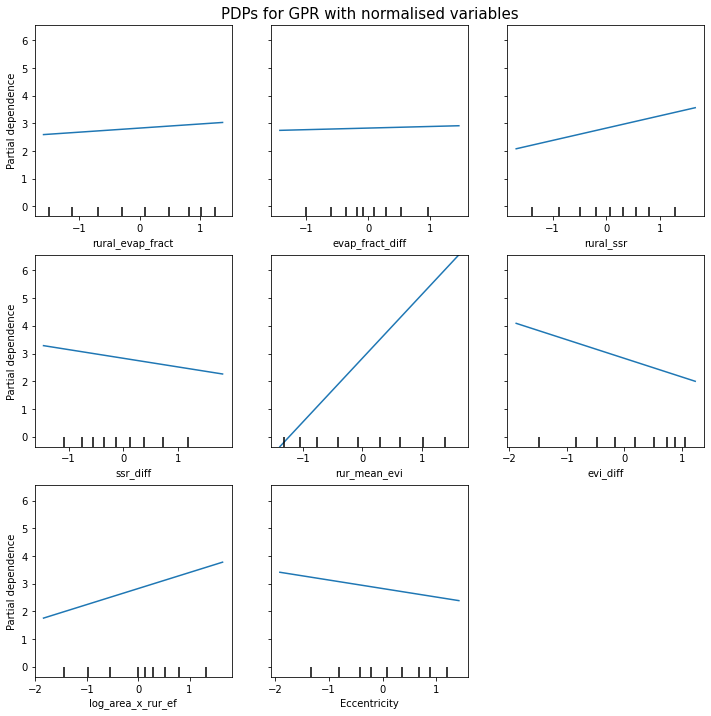

In [213]:
# Partial Dependence Plots
plt.rc('axes', titlesize=15)     # fontsize of the axes title
plt.rc('axes', labelsize=10)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=10)    # fontsize of the tick labels
plt.rc('ytick', labelsize=10)    # fontsize of the tick labels
#plt.rc('legend', fontsize=20)    # legend fontsize
plt.rc('figure', titlesize=10)  # fontsize of the figure title

fig, axes = plt.subplots(figsize=(12, 12))

#PartialDependenceDisplay.from_estimator(clf, X, features)
gpr_disp = PartialDependenceDisplay.from_estimator(model_gpr_target_a0, X_train_norm, ["rural_evap_fract","evap_fract_diff",
                                  'rural_ssr','ssr_diff','rur_mean_evi','evi_diff','log_area_x_rur_ef','Eccentricity'], 
                                   ax=axes)

axes.set(title = 'PDPs for GPR with normalised variables', xlabel = 'Partial Dependence (K)')


## the relationships are linear because the GPR cross validation process chose the rigid dot product kernel

[Text(0.5, 0, 'Normalised Eccentricity')]

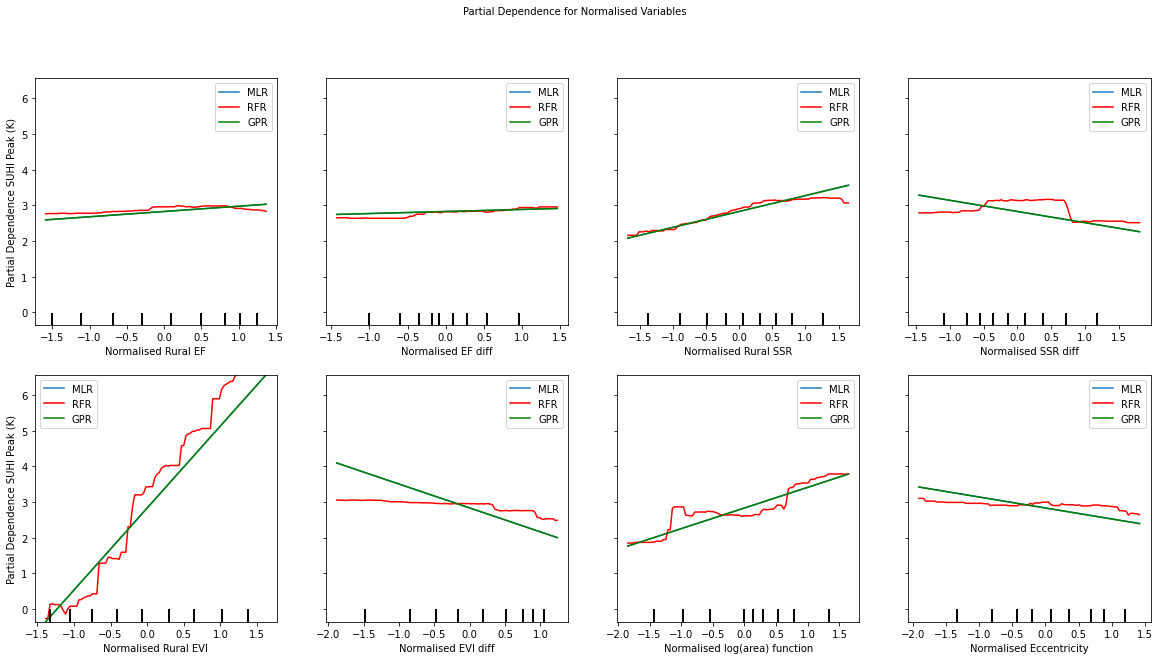

In [214]:
#plot the MLR, RFR and GPR models on the same axes

plt.rc('axes', titlesize=15)     # fontsize of the axes title
plt.rc('axes', labelsize=10)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=10)    # fontsize of the tick labels
plt.rc('ytick', labelsize=10)    # fontsize of the tick labels
#plt.rc('legend', fontsize=20)    # legend fontsize
plt.rc('figure', titlesize=10)  # fontsize of the figure title

fig, axes = plt.subplots(2, 4, figsize=(20, 10))
fig.suptitle('Partial Dependence for Normalised Variables')

mlr_disp.plot(ax=axes, line_kw={"label": "MLR"})
rfr_disp.plot(
    ax=axes, line_kw={"label": "RFR", "color": "red"})
gpr_disp.plot(
    ax=axes, line_kw={"label": "GPR", "color": "green"})


axes[0,0].set( ylabel = 'Partial Dependence SUHI Peak (K)' , xlabel = 'Normalised Rural EF')
axes[0,1].set( xlabel = 'Normalised EF diff')
axes[0,2].set( xlabel = 'Normalised Rural SSR')
axes[0,3].set( xlabel = 'Normalised SSR diff')
axes[1,0].set( ylabel = 'Partial Dependence SUHI Peak (K)' , xlabel = 'Normalised Rural EVI')
axes[1,1].set( xlabel = 'Normalised EVI diff')
axes[1,2].set( xlabel = 'Normalised log(area) function')
axes[1,3].set( xlabel = 'Normalised Eccentricity')

In [20]:
# Linear GAM
# read in the finalised model
#read in the model
os.chdir(os.path.join(et.io.HOME, 'Documents', 'Python_Scripts', 'PROJECT','UHI_Project_Pickle_Files','All_cities'))  
filename = 'finalised_model_gam_a0.sav'
gam_reg = pickle.load(open(filename, 'rb'))

In [22]:
#Performance stats for GAM
y_train_pred = gam_reg.predict(X_train_norm)
y_test_pred = gam_reg.predict(X_test_norm)

#####################################################
###### Performance Metrics for the training set ######
######################################################
#rmse
gam_mse = mean_squared_error(y_train, y_train_pred)
gam_rmse = np.sqrt(gam_mse)
#r-square
gam_r2 = r2_score(y_train, y_train_pred)
#mae
gam_mae = mean_absolute_error(y_train, y_train_pred)
print('Training Metrics--', 'RMSE:', gam_rmse, 'R-square:', gam_r2, 'MAE:', gam_mae)

#################################################
###### Performance Metrics for the test set #####
#################################################
#rmse
test_gam_mse = mean_squared_error(y_test, y_test_pred)
test_gam_rmse = np.sqrt(test_gam_mse)
#r-square
test_gam_r2 = r2_score(y_test, y_test_pred)
#mae
test_gam_mae = mean_absolute_error(y_test, y_test_pred)
print('Test Metrics--', 'RMSE:', test_gam_rmse, 'R-square:', test_gam_r2, 'MAE:', test_gam_mae)

Training Metrics-- RMSE: 2.078548999730211 R-square: 0.7468878932699928 MAE: 1.540243542726449
Test Metrics-- RMSE: 2.1529414975103465 R-square: 0.5832650605341083 MAE: 1.693685173660809


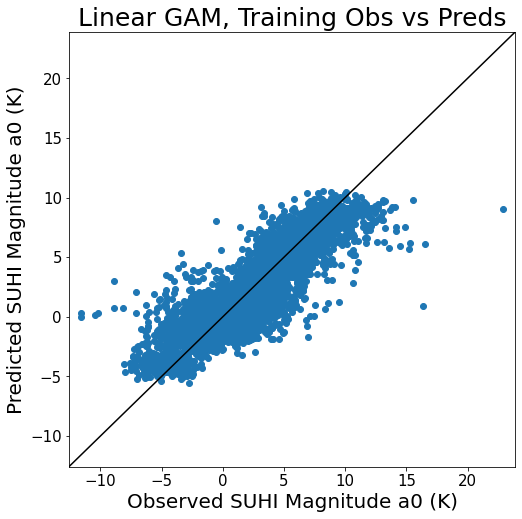

In [23]:
# Plotting 

#plt.rc('font', size=15)          # controls default text sizes
plt.rc('axes', titlesize=25)     # fontsize of the axes title
plt.rc('axes', labelsize=20)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=15)    # fontsize of the tick labels
plt.rc('ytick', labelsize=15)    # fontsize of the tick labels
#plt.rc('legend', fontsize=20)    # legend fontsize
plt.rc('figure', titlesize=20)  # fontsize of the figure title


fig, axes = plt.subplots(1,1, figsize = (8, 8))

axes.scatter(y_train, y_train_pred)
axes.set(title = 'Linear GAM, Training Obs vs Preds', 
         xlabel = 'Observed SUHI Magnitude a0 (K)', ylabel = 'Predicted SUHI Magnitude a0 (K)')
         #xlabel = 'Observed SUHI Mean (K)', ylabel = 'Predicted SUHI Mean (K)')

axesmin = min(min(y_train), min(y_train_pred)) - 1
axesmax = max(max(y_train), max(y_train_pred)) + 1

axes.set_xlim([axesmin, axesmax])
axes.set_ylim([axesmin, axesmax])

axes.plot([axesmin, axesmax],[axesmin, axesmax], color = 'k')

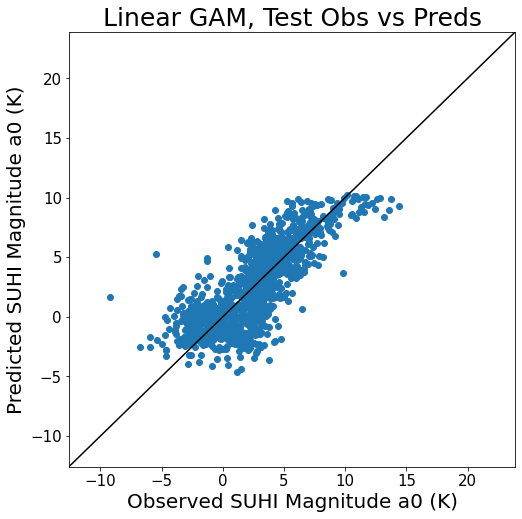

In [24]:
fig, axes = plt.subplots(1,1, figsize = (8, 8))

axes.scatter(y_test, y_test_pred)
axes.set(title = 'Linear GAM, Test Obs vs Preds', 
         xlabel = 'Observed SUHI Magnitude a0 (K)', ylabel = 'Predicted SUHI Magnitude a0 (K)')
         #xlabel = 'Observed SUHI Mean (K)', ylabel = 'Predicted SUHI Mean (K)')

axesmin = min(min(y_train), min(y_train_pred)) - 1
axesmax = max(max(y_train), max(y_train_pred)) + 1

axes.set_xlim([axesmin, axesmax])
axes.set_ylim([axesmin, axesmax])

axes.plot([axesmin, axesmax],[axesmin, axesmax], color = 'k')

[Text(0.5, 1.0, 'PDPs for Linear GAM with normalised variables'),
 Text(0.5, 0, 'Partial Dependence (K)')]

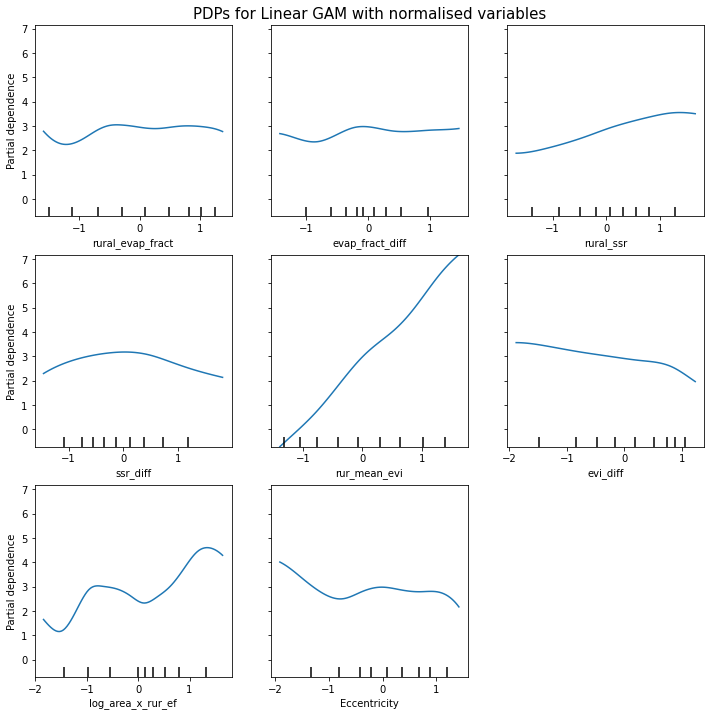

In [35]:
plt.rc('axes', titlesize=15)     # fontsize of the axes title
plt.rc('axes', labelsize=10)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=10)    # fontsize of the tick labels
plt.rc('ytick', labelsize=10)    # fontsize of the tick labels
#plt.rc('legend', fontsize=20)    # legend fontsize
plt.rc('figure', titlesize=10)  # fontsize of the figure title

fig, axes = plt.subplots(figsize=(12, 12))

# at dummy var so non scikit learn model can be used
gam_reg.dummy_ = "dummy"
gam_reg._estimator_type = "regressor"
#PartialDependenceDisplay.from_estimator(clf, X, features)
gam_disp = PartialDependenceDisplay.from_estimator(gam_reg, X_train_norm, ["rural_evap_fract","evap_fract_diff",
                                  'rural_ssr','ssr_diff','rur_mean_evi','evi_diff','log_area_x_rur_ef','Eccentricity'], 
                                   ax=axes)

axes.set(title = 'PDPs for Linear GAM with normalised variables', xlabel = 'Partial Dependence (K)')

[Text(0.5, 0, 'Normalised Eccentricity')]

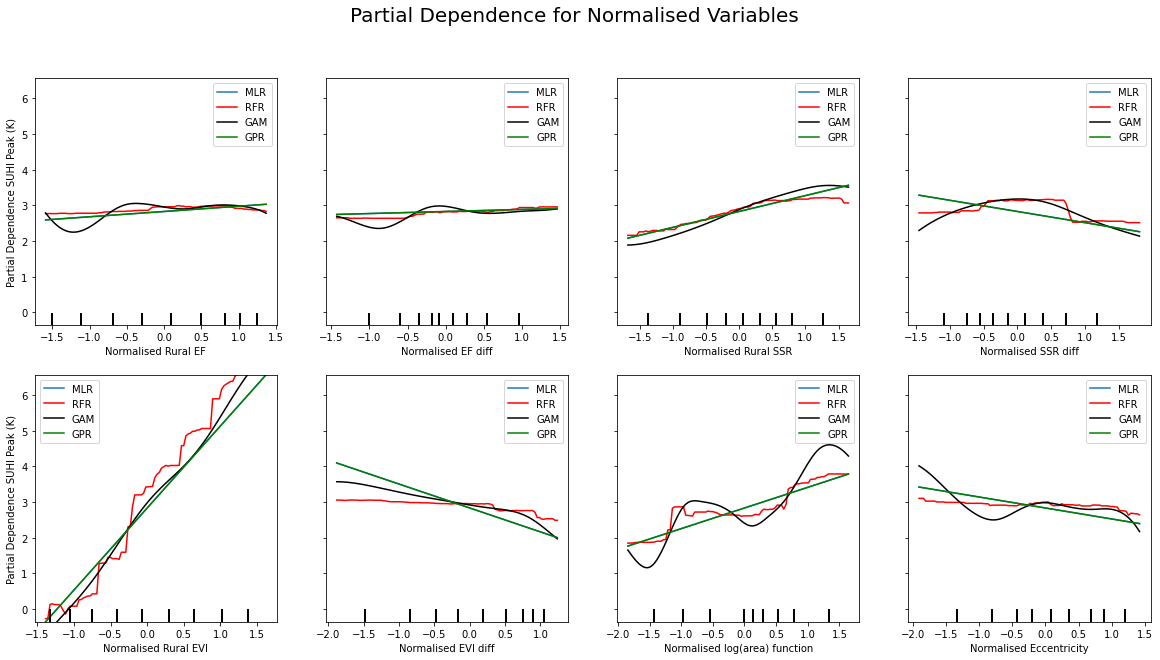

In [215]:
#plot the MLR, RFR and GAM models on the same axes

plt.rc('axes', titlesize=15)     # fontsize of the axes title
plt.rc('axes', labelsize=10)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=10)    # fontsize of the tick labels
plt.rc('ytick', labelsize=10)    # fontsize of the tick labels
#plt.rc('legend', fontsize=20)    # legend fontsize
plt.rc('figure', titlesize=20)  # fontsize of the figure title

fig, axes = plt.subplots(2, 4, figsize=(20, 10))
fig.suptitle('Partial Dependence for Normalised Variables')

mlr_disp.plot(ax=axes, line_kw={"label": "MLR"})
rfr_disp.plot(
    ax=axes, line_kw={"label": "RFR", "color": "red"})
gam_disp.plot(
    ax=axes, line_kw={"label": "GAM", "color": "black"})
gpr_disp.plot(
    ax=axes, line_kw={"label": "GPR", "color": "green"})

axes[0,0].set( ylabel = 'Partial Dependence SUHI Peak (K)' , xlabel = 'Normalised Rural EF')
axes[0,1].set( xlabel = 'Normalised EF diff')
axes[0,2].set( xlabel = 'Normalised Rural SSR')
axes[0,3].set( xlabel = 'Normalised SSR diff')
axes[1,0].set( ylabel = 'Partial Dependence SUHI Peak (K)' , xlabel = 'Normalised Rural EVI')
axes[1,1].set( xlabel = 'Normalised EVI diff')
axes[1,2].set( xlabel = 'Normalised log(area) function')
axes[1,3].set( xlabel = 'Normalised Eccentricity')

In [217]:
###############
## ALE PLOTS ##
###############

mlr_ale = ALE(lin_reg.predict, feature_names = ["rural_evap_fract","evap_fract_diff", 'rural_ssr','ssr_diff','rur_mean_evi', 
                                        'evi_diff','log_area_x_rur_ef','Eccentricity'], target_names = ['a0'])

rfr_ale = ALE(model_target_a0.predict, feature_names = ["rural_evap_fract","evap_fract_diff", 'rural_ssr','ssr_diff','rur_mean_evi', 
                                        'evi_diff','log_area_x_rur_ef','Eccentricity'], target_names = ['a0'])

gpr_ale = ALE(model_gpr_target_a0.predict, feature_names = ["rural_evap_fract","evap_fract_diff", 'rural_ssr','ssr_diff','rur_mean_evi', 
                                        'evi_diff','log_area_x_rur_ef','Eccentricity'], target_names = ['a0'])

gam_ale = ALE(gam_reg.predict, feature_names = ["rural_evap_fract","evap_fract_diff", 'rural_ssr','ssr_diff','rur_mean_evi', 
                                        'evi_diff','log_area_x_rur_ef','Eccentricity'], target_names = ['a0'])



mlr_exp = mlr_ale.explain(np.array(X_train_norm))
rfr_exp = rfr_ale.explain(np.array(X_train_norm))
gam_exp = gam_ale.explain(np.array(X_train_norm))
gpr_exp = gpr_ale.explain(np.array(X_train_norm))

C:\Users\UEA_Laptop\.conda\envs\suhienv\lib\site-packages\sklearn\base.py:450: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(
C:\Users\UEA_Laptop\.conda\envs\suhienv\lib\site-packages\sklearn\base.py:450: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(
C:\Users\UEA_Laptop\.conda\envs\suhienv\lib\site-packages\sklearn\base.py:450: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(
C:\Users\UEA_Laptop\.conda\envs\suhienv\lib\site-packages\sklearn\base.py:450: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(
C:\Users\UEA_Laptop\.conda\envs\suhienv\lib\site-packages\sklearn\base.py:450: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(
C:\Users\UEA_La

[Text(0.5, 0, 'Normalised Eccentricity'), Text(0, 0.5, '')]

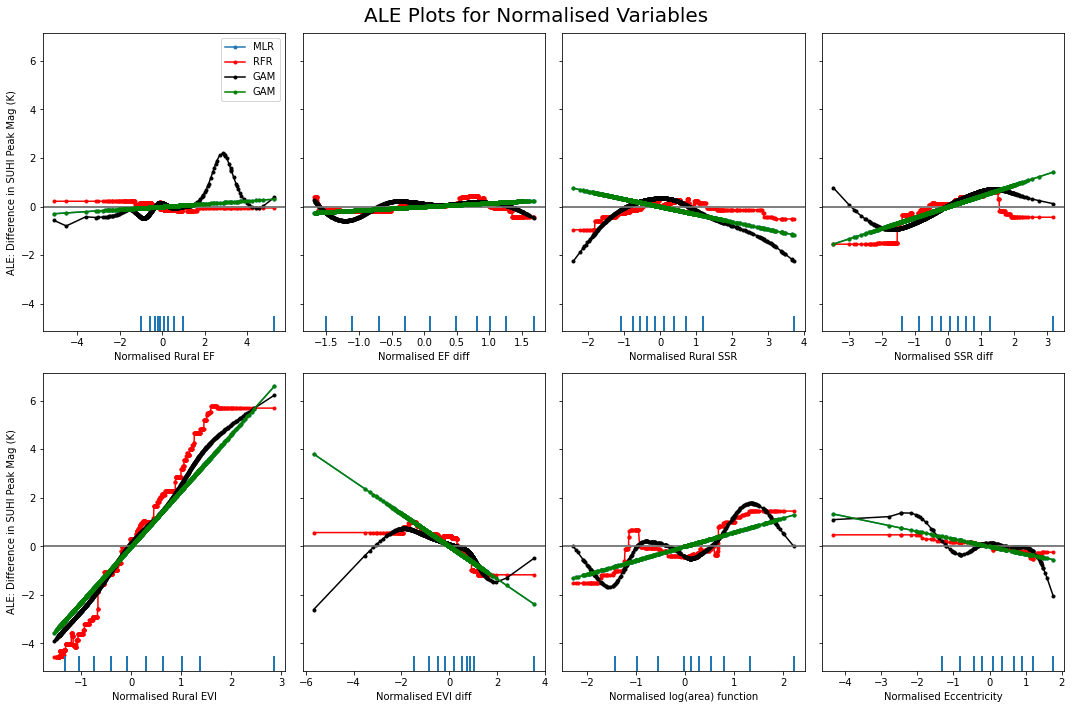

In [221]:
# Plot the ALE

#set the font sizes 
plt.rc('axes', titlesize=15)     # fontsize of the axes title
plt.rc('axes', labelsize=10)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=10)    # fontsize of the tick labels
plt.rc('ytick', labelsize=10)    # fontsize of the tick labels
plt.rc('figure', titlesize=20)  # fontsize of the figure title

fig, axes = plt.subplots(2, 4, sharey='all');

plot_ale(mlr_exp, ax=axes, fig_kw={'figwidth':15, 'figheight': 10},
         line_kw={'label': 'MLR'});
plot_ale(rfr_exp, ax=axes, line_kw={'label': 'RFR',  "color": "red"});
plot_ale(gam_exp, ax=axes, line_kw={'label': 'GAM', "color": "black"});
plot_ale(gpr_exp, ax=axes, line_kw={'label': 'GAM', "color": "green"});

fig.suptitle('ALE Plots for Normalised Variables')
axes[0,0].set( ylabel = 'ALE: Difference in SUHI Peak Mag (K)' , xlabel = 'Normalised Rural EF')
axes[0,1].set( xlabel = 'Normalised EF diff', ylabel = '')
axes[0,2].set( xlabel = 'Normalised Rural SSR', ylabel = '')
axes[0,3].set( xlabel = 'Normalised SSR diff', ylabel = '')
axes[1,0].set( ylabel = 'ALE: Difference in SUHI Peak Mag (K)' , xlabel = 'Normalised Rural EVI')
axes[1,1].set( xlabel = 'Normalised EVI diff', ylabel = '')
axes[1,2].set( xlabel = 'Normalised log(area) function', ylabel = '')
axes[1,3].set( xlabel = 'Normalised Eccentricity', ylabel = '')

[Text(0.5, 0, 'Normalised Eccentricity'), Text(0, 0.5, '')]

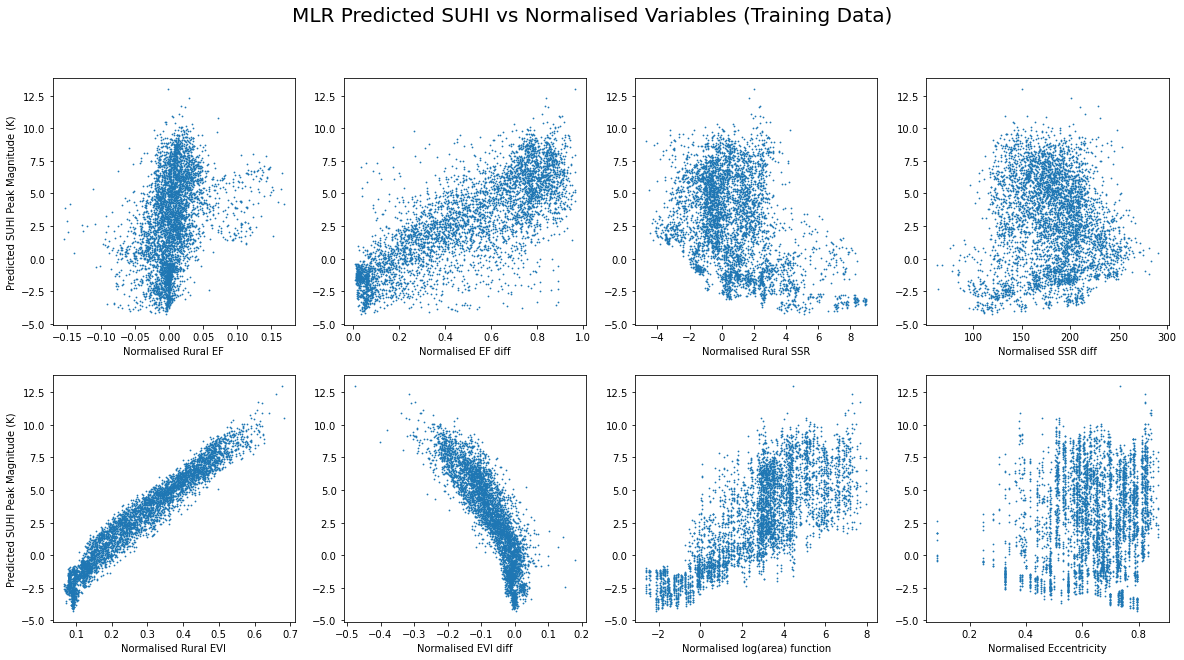

In [193]:
# Scatterplots of model predictions versus the predictor variable

#set the font sizes 
plt.rc('axes', titlesize=15)     # fontsize of the axes title
plt.rc('axes', labelsize=10)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=10)    # fontsize of the tick labels
plt.rc('ytick', labelsize=10)    # fontsize of the tick labels
plt.rc('figure', titlesize=20)  # fontsize of the figure title

fig, axes = plt.subplots(2, 4, figsize=(20, 10))
fig.suptitle('MLR Predicted SUHI vs Normalised Variables (Training Data)')

# Chosen model - MLR
y_train_pred = lin_reg.predict(X_train_norm)
y_test_pred = lin_reg.predict(X_test_norm)

for count, variable_name in enumerate (X_train.columns):

    row_num = int((count - count%4)/4)
    col_num = count%4

    x = X_train[variable_name].values
    y = y_train_pred
    axes[row_num,col_num].scatter(x,y, s = 0.6)

axes[0,0].set( ylabel = 'Predicted SUHI Peak Magnitude (K)' , xlabel = 'Normalised Rural EF')
axes[0,1].set( xlabel = 'Normalised EF diff', ylabel = '')
axes[0,2].set( xlabel = 'Normalised Rural SSR', ylabel = '')
axes[0,3].set( xlabel = 'Normalised SSR diff', ylabel = '')
axes[1,0].set( ylabel = 'Predicted SUHI Peak Magnitude (K)' , xlabel = 'Normalised Rural EVI')
axes[1,1].set( xlabel = 'Normalised EVI diff', ylabel = '')
axes[1,2].set( xlabel = 'Normalised log(area) function', ylabel = '')
axes[1,3].set( xlabel = 'Normalised Eccentricity', ylabel = '')


[Text(0.5, 0, 'Normalised Eccentricity'), Text(0, 0.5, '')]

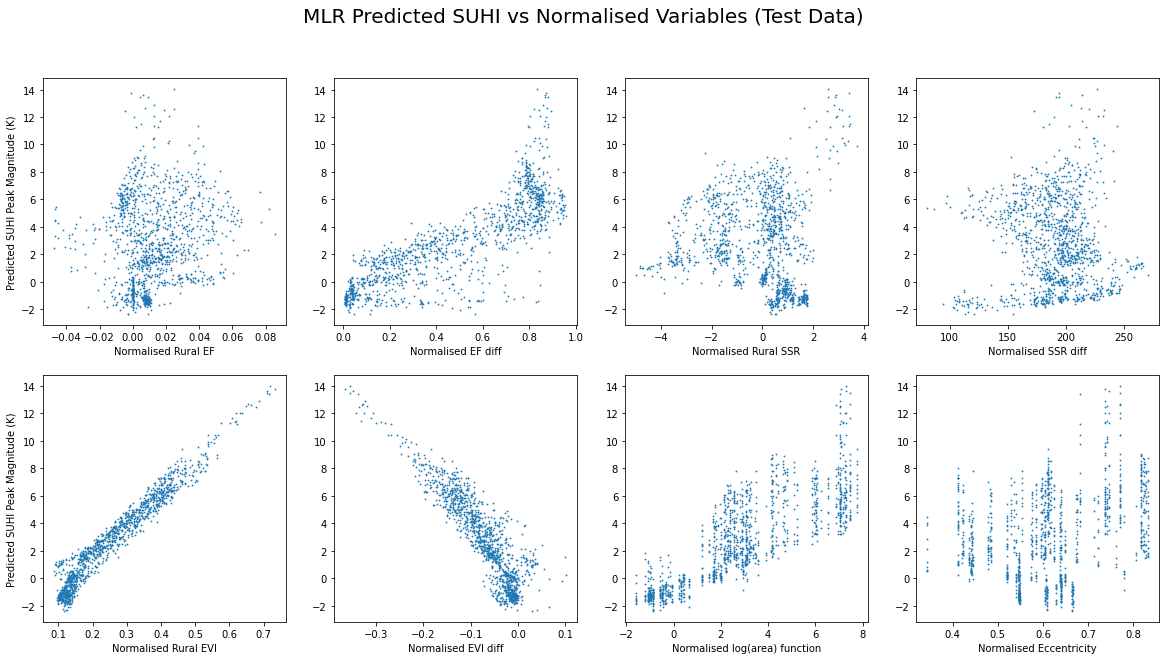

In [194]:
# Scatterplots of model predictions versus the predictor variable

#set the font sizes 
plt.rc('axes', titlesize=15)     # fontsize of the axes title
plt.rc('axes', labelsize=10)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=10)    # fontsize of the tick labels
plt.rc('ytick', labelsize=10)    # fontsize of the tick labels
plt.rc('figure', titlesize=20)  # fontsize of the figure title

fig, axes = plt.subplots(2, 4, figsize=(20, 10))
fig.suptitle('MLR Predicted SUHI vs Normalised Variables (Test Data)')

# Chosen model - MLR
y_test_pred = lin_reg.predict(X_test_norm)

for count, variable_name in enumerate (X_test.columns):

    row_num = int((count - count%4)/4)
    col_num = count%4

    x = X_test[variable_name].values
    y = y_test_pred
    axes[row_num,col_num].scatter(x,y, s = 0.6)

axes[0,0].set( ylabel = 'Predicted SUHI Peak Magnitude (K)' , xlabel = 'Normalised Rural EF')
axes[0,1].set( xlabel = 'Normalised EF diff', ylabel = '')
axes[0,2].set( xlabel = 'Normalised Rural SSR', ylabel = '')
axes[0,3].set( xlabel = 'Normalised SSR diff', ylabel = '')
axes[1,0].set( ylabel = 'Predicted SUHI Peak Magnitude (K)' , xlabel = 'Normalised Rural EVI')
axes[1,1].set( xlabel = 'Normalised EVI diff', ylabel = '')
axes[1,2].set( xlabel = 'Normalised log(area) function', ylabel = '')
axes[1,3].set( xlabel = 'Normalised Eccentricity', ylabel = '')


[Text(0.5, 0, 'Normalised Eccentricity'), Text(0, 0.5, '')]

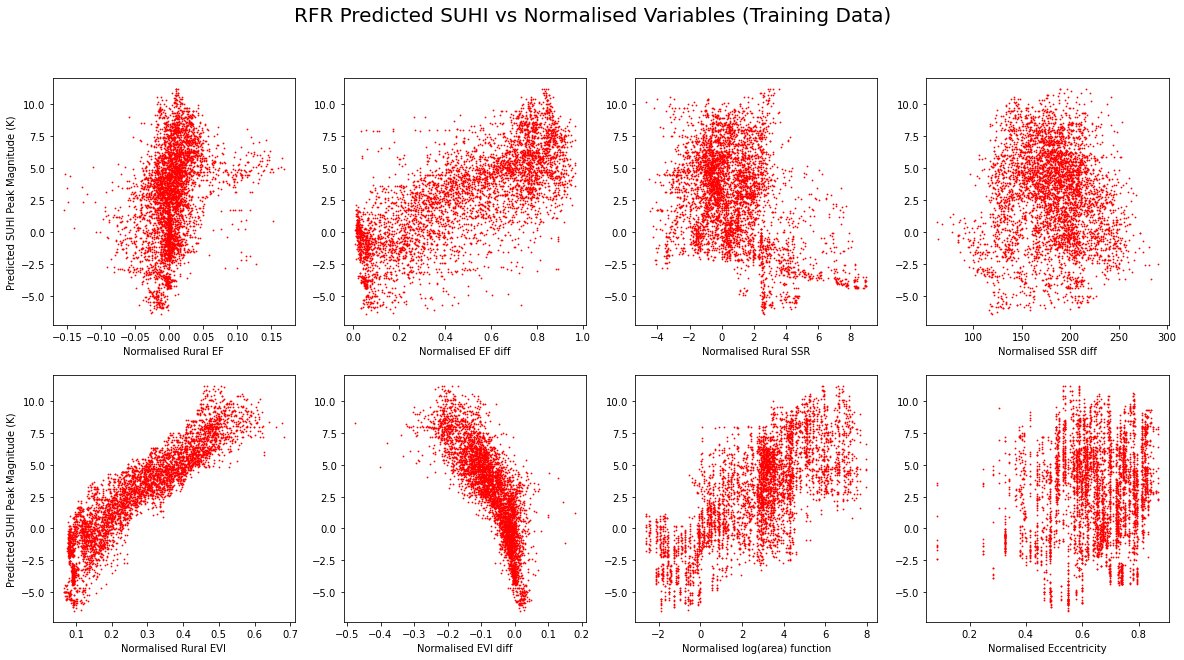

In [227]:
#set the font sizes 
plt.rc('axes', titlesize=15)     # fontsize of the axes title
plt.rc('axes', labelsize=10)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=10)    # fontsize of the tick labels
plt.rc('ytick', labelsize=10)    # fontsize of the tick labels
plt.rc('figure', titlesize=20)  # fontsize of the figure title

fig, axes = plt.subplots(2, 4, figsize=(20, 10))
fig.suptitle('RFR Predicted SUHI vs Normalised Variables (Training Data)')

# Chosen model - RFR
y_train_pred = model_target_a0.predict(X_train_norm)

for count, variable_name in enumerate (X_train.columns):

    row_num = int((count - count%4)/4)
    col_num = count%4

    x = X_train[variable_name].values
    y = y_train_pred
    axes[row_num,col_num].scatter(x,y, s = 0.6, color = 'red')

axes[0,0].set( ylabel = 'Predicted SUHI Peak Magnitude (K)' , xlabel = 'Normalised Rural EF')
axes[0,1].set( xlabel = 'Normalised EF diff', ylabel = '')
axes[0,2].set( xlabel = 'Normalised Rural SSR', ylabel = '')
axes[0,3].set( xlabel = 'Normalised SSR diff', ylabel = '')
axes[1,0].set( ylabel = 'Predicted SUHI Peak Magnitude (K)' , xlabel = 'Normalised Rural EVI')
axes[1,1].set( xlabel = 'Normalised EVI diff', ylabel = '')
axes[1,2].set( xlabel = 'Normalised log(area) function', ylabel = '')
axes[1,3].set( xlabel = 'Normalised Eccentricity', ylabel = '')


[Text(0.5, 0, 'Normalised Eccentricity'), Text(0, 0.5, '')]

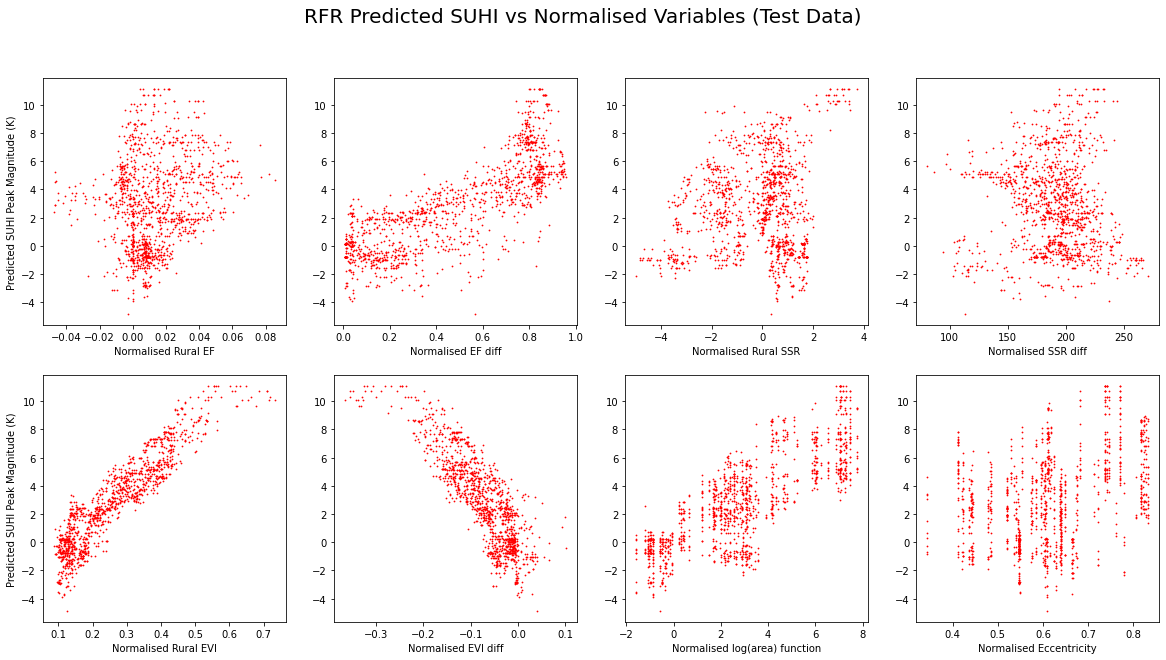

In [226]:
# Scatterplots of model predictions versus the predictor variable

#set the font sizes 
plt.rc('axes', titlesize=15)     # fontsize of the axes title
plt.rc('axes', labelsize=10)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=10)    # fontsize of the tick labels
plt.rc('ytick', labelsize=10)    # fontsize of the tick labels
plt.rc('figure', titlesize=20)  # fontsize of the figure title

fig, axes = plt.subplots(2, 4, figsize=(20, 10))
fig.suptitle('RFR Predicted SUHI vs Normalised Variables (Test Data)')

# Chosen model - RFR
y_test_pred = model_target_a0.predict(X_test_norm)

for count, variable_name in enumerate (X_test.columns):

    row_num = int((count - count%4)/4)
    col_num = count%4

    x = X_test[variable_name].values
    y = y_test_pred
    axes[row_num,col_num].scatter(x,y, s = 0.6, color = 'red')

axes[0,0].set( ylabel = 'Predicted SUHI Peak Magnitude (K)' , xlabel = 'Normalised Rural EF')
axes[0,1].set( xlabel = 'Normalised EF diff', ylabel = '')
axes[0,2].set( xlabel = 'Normalised Rural SSR', ylabel = '')
axes[0,3].set( xlabel = 'Normalised SSR diff', ylabel = '')
axes[1,0].set( ylabel = 'Predicted SUHI Peak Magnitude (K)' , xlabel = 'Normalised Rural EVI')
axes[1,1].set( xlabel = 'Normalised EVI diff', ylabel = '')
axes[1,2].set( xlabel = 'Normalised log(area) function', ylabel = '')
axes[1,3].set( xlabel = 'Normalised Eccentricity', ylabel = '')


[Text(0.5, 0, 'Normalised Eccentricity'), Text(0, 0.5, '')]

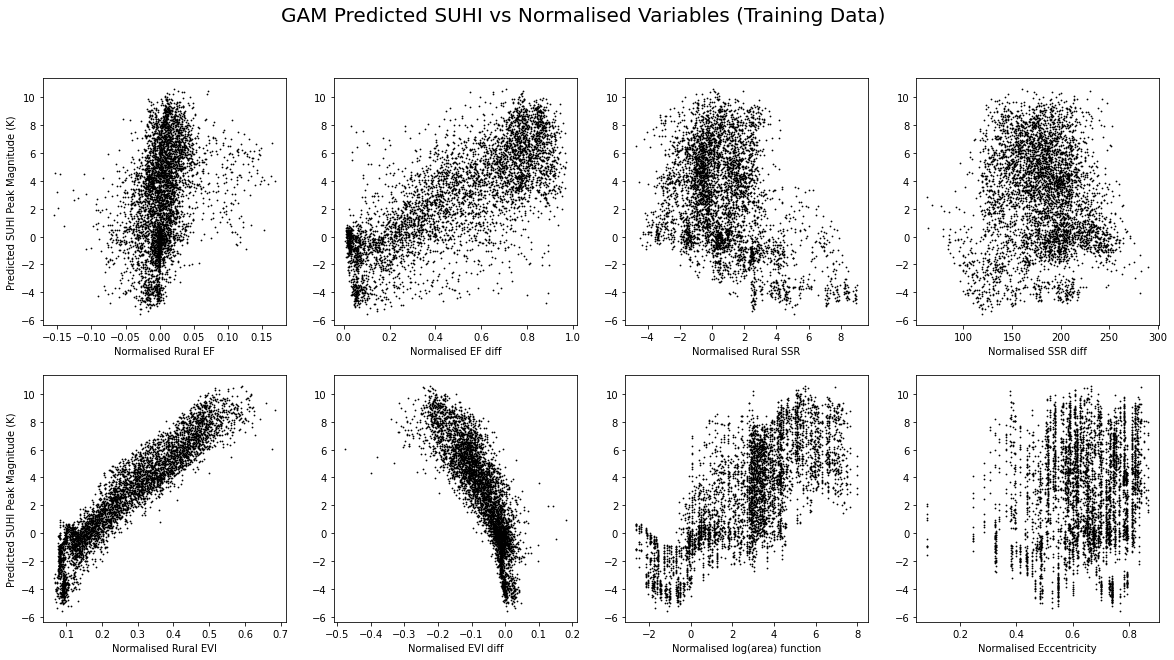

In [222]:
#set the font sizes 
plt.rc('axes', titlesize=15)     # fontsize of the axes title
plt.rc('axes', labelsize=10)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=10)    # fontsize of the tick labels
plt.rc('ytick', labelsize=10)    # fontsize of the tick labels
plt.rc('figure', titlesize=20)  # fontsize of the figure title

fig, axes = plt.subplots(2, 4, figsize=(20, 10))
fig.suptitle('GAM Predicted SUHI vs Normalised Variables (Training Data)')

# Chosen model - GAM
y_train_pred = gam_reg.predict(X_train_norm)

for count, variable_name in enumerate (X_train.columns):

    row_num = int((count - count%4)/4)
    col_num = count%4

    x = X_train[variable_name].values
    y = y_train_pred
    axes[row_num,col_num].scatter(x,y, s = 0.6, color = 'black')

axes[0,0].set( ylabel = 'Predicted SUHI Peak Magnitude (K)' , xlabel = 'Normalised Rural EF')
axes[0,1].set( xlabel = 'Normalised EF diff', ylabel = '')
axes[0,2].set( xlabel = 'Normalised Rural SSR', ylabel = '')
axes[0,3].set( xlabel = 'Normalised SSR diff', ylabel = '')
axes[1,0].set( ylabel = 'Predicted SUHI Peak Magnitude (K)' , xlabel = 'Normalised Rural EVI')
axes[1,1].set( xlabel = 'Normalised EVI diff', ylabel = '')
axes[1,2].set( xlabel = 'Normalised log(area) function', ylabel = '')
axes[1,3].set( xlabel = 'Normalised Eccentricity', ylabel = '')


[Text(0.5, 0, 'Normalised Eccentricity'), Text(0, 0.5, '')]

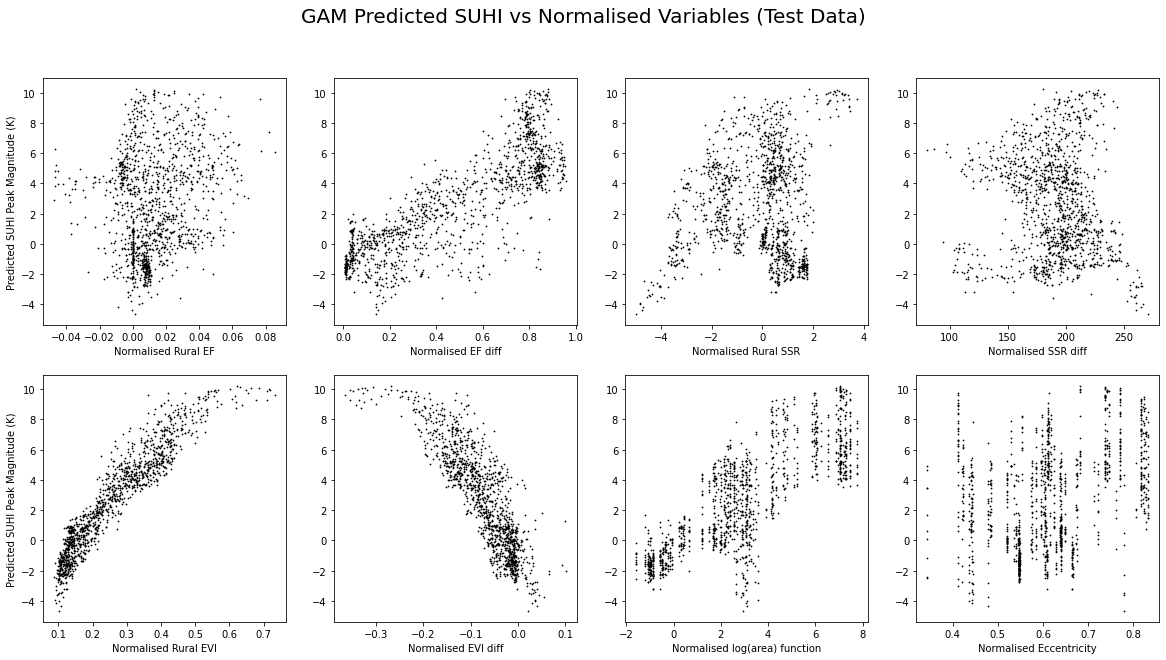

In [199]:
# Scatterplots of model predictions versus the predictor variable

#set the font sizes 
plt.rc('axes', titlesize=15)     # fontsize of the axes title
plt.rc('axes', labelsize=10)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=10)    # fontsize of the tick labels
plt.rc('ytick', labelsize=10)    # fontsize of the tick labels
plt.rc('figure', titlesize=20)  # fontsize of the figure title

fig, axes = plt.subplots(2, 4, figsize=(20, 10))
fig.suptitle('GAM Predicted SUHI vs Normalised Variables (Test Data)')

# Chosen model - GAM
y_test_pred = gam_reg.predict(X_test_norm)

for count, variable_name in enumerate (X_test.columns):

    row_num = int((count - count%4)/4)
    col_num = count%4

    x = X_test[variable_name].values
    y = y_test_pred
    axes[row_num,col_num].scatter(x,y, s = 0.6, color = 'black')

axes[0,0].set( ylabel = 'Predicted SUHI Peak Magnitude (K)' , xlabel = 'Normalised Rural EF')
axes[0,1].set( xlabel = 'Normalised EF diff', ylabel = '')
axes[0,2].set( xlabel = 'Normalised Rural SSR', ylabel = '')
axes[0,3].set( xlabel = 'Normalised SSR diff', ylabel = '')
axes[1,0].set( ylabel = 'Predicted SUHI Peak Magnitude (K)' , xlabel = 'Normalised Rural EVI')
axes[1,1].set( xlabel = 'Normalised EVI diff', ylabel = '')
axes[1,2].set( xlabel = 'Normalised log(area) function', ylabel = '')
axes[1,3].set( xlabel = 'Normalised Eccentricity', ylabel = '')

[Text(0.5, 0, 'Normalised Eccentricity'), Text(0, 0.5, '')]

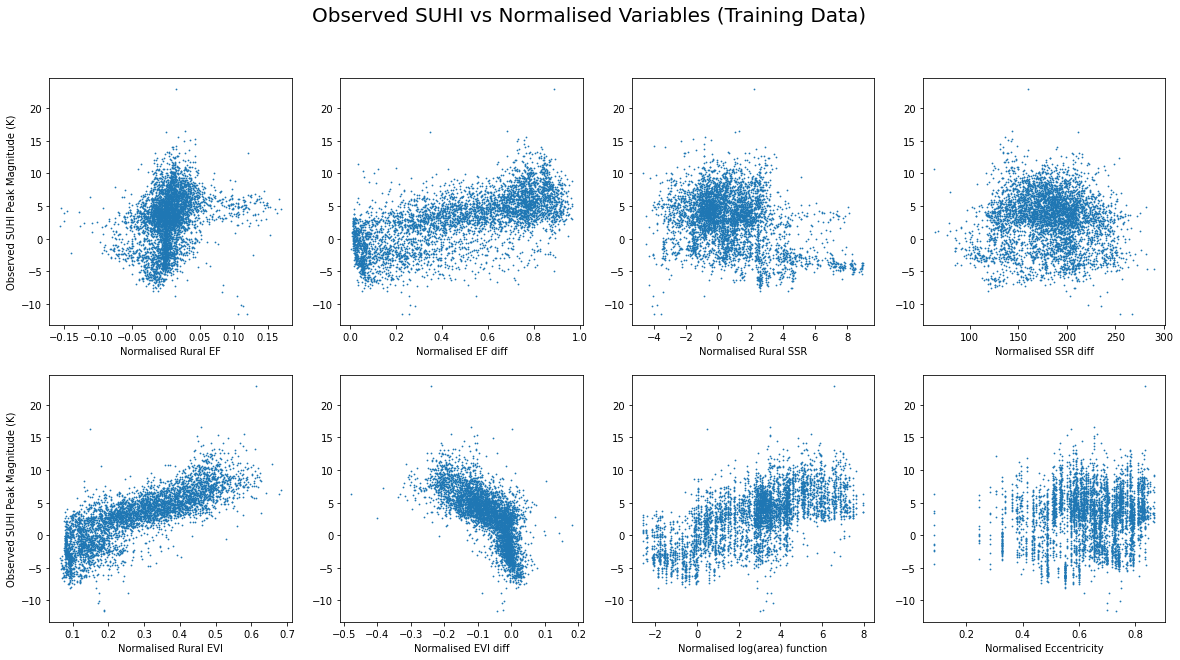

In [202]:
# Scatter plots of the variables versus the observations
#set the font sizes 
plt.rc('axes', titlesize=15)     # fontsize of the axes title
plt.rc('axes', labelsize=10)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=10)    # fontsize of the tick labels
plt.rc('ytick', labelsize=10)    # fontsize of the tick labels
plt.rc('figure', titlesize=20)  # fontsize of the figure title

fig, axes = plt.subplots(2, 4, figsize=(20, 10))
fig.suptitle('Observed SUHI vs Normalised Variables (Training Data)')

for count, variable_name in enumerate (X_train.columns):

    row_num = int((count - count%4)/4)
    col_num = count%4

    x = X_train[variable_name].values
    y = y_train
    axes[row_num,col_num].scatter(x,y, s = 0.6)

axes[0,0].set( ylabel = 'Observed SUHI Peak Magnitude (K)' , xlabel = 'Normalised Rural EF')
axes[0,1].set( xlabel = 'Normalised EF diff', ylabel = '')
axes[0,2].set( xlabel = 'Normalised Rural SSR', ylabel = '')
axes[0,3].set( xlabel = 'Normalised SSR diff', ylabel = '')
axes[1,0].set( ylabel = 'Observed SUHI Peak Magnitude (K)' , xlabel = 'Normalised Rural EVI')
axes[1,1].set( xlabel = 'Normalised EVI diff', ylabel = '')
axes[1,2].set( xlabel = 'Normalised log(area) function', ylabel = '')
axes[1,3].set( xlabel = 'Normalised Eccentricity', ylabel = '')

[Text(0.5, 0, 'Normalised Eccentricity'), Text(0, 0.5, '')]

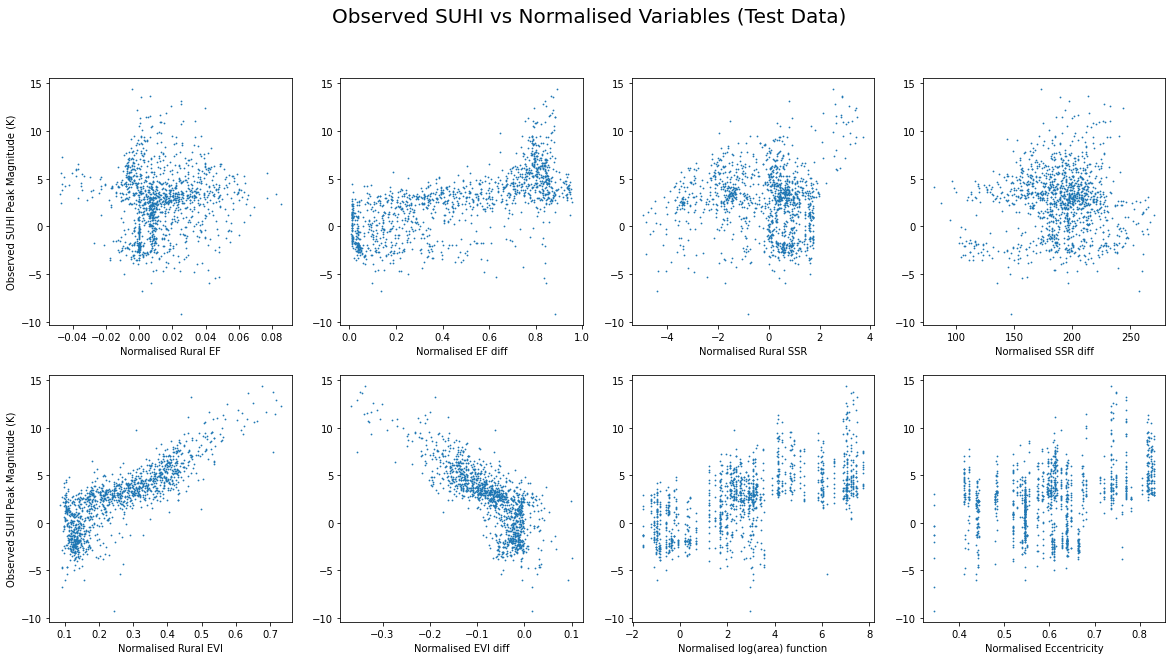

In [200]:
# Scatter plots of the variables versus the observations
#set the font sizes 
plt.rc('axes', titlesize=15)     # fontsize of the axes title
plt.rc('axes', labelsize=10)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=10)    # fontsize of the tick labels
plt.rc('ytick', labelsize=10)    # fontsize of the tick labels
plt.rc('figure', titlesize=20)  # fontsize of the figure title

fig, axes = plt.subplots(2, 4, figsize=(20, 10))
fig.suptitle('Observed SUHI vs Normalised Variables (Test Data)')

for count, variable_name in enumerate (X_test.columns):

    row_num = int((count - count%4)/4)
    col_num = count%4

    x = X_test[variable_name].values
    y = y_test
    axes[row_num,col_num].scatter(x,y, s = 0.6)

axes[0,0].set( ylabel = 'Observed SUHI Peak Magnitude (K)' , xlabel = 'Normalised Rural EF')
axes[0,1].set( xlabel = 'Normalised EF diff', ylabel = '')
axes[0,2].set( xlabel = 'Normalised Rural SSR', ylabel = '')
axes[0,3].set( xlabel = 'Normalised SSR diff', ylabel = '')
axes[1,0].set( ylabel = 'Observed SUHI Peak Magnitude (K)' , xlabel = 'Normalised Rural EVI')
axes[1,1].set( xlabel = 'Normalised EVI diff', ylabel = '')
axes[1,2].set( xlabel = 'Normalised log(area) function', ylabel = '')
axes[1,3].set( xlabel = 'Normalised Eccentricity', ylabel = '')

In [230]:
############################################
########## R SQUARE PLOTS BY CITY ##########
############################################

######## Calculate the score for all models ################

#loop through each city to generate a r-square value based on the model 
cities = CITY_COUNTRY_lat_lon[CITY_COUNTRY_lat_lon['City'] != 'Cascavel'].City.values
#cities = CITY_COUNTRY_lat_lon.City.values
mlr_r2_list = []
rfr_r2_list = []
gam_r2_list = []
gpr_r2_list = []

#set the transformer (transform based on all cities not just one)
X_train_norm = pd.DataFrame(scaler.fit_transform(X_train), columns = X_train.columns)         #fit and transform

for i, city in enumerate(cities):
    data_city = all_monthly_data_df2[((all_monthly_data_df2['City'] == city) 
                                    & (all_monthly_data_df2['Overpass'] == overpass_time))].copy()

    X_data_city = data_city[predictor_variables]                                                  #predictors
    X_data_city_norm = pd.DataFrame(scaler.transform(X_data_city), columns = X_data_city.columns) #transform only
    y_data_city = data_city[target_variable]                                                      #target
    
    mlr_y_city_pred = lin_reg.predict(X_data_city_norm)
    rfr_y_city_pred = model_target_a0.predict(X_data_city_norm)
    gam_y_city_pred = gam_reg.predict(X_data_city_norm)
    gpr_y_city_pred = model_gpr_target_a0.predict(X_data_city_norm)
    
    mlr_r2_score_city = r2_score(y_data_city, mlr_y_city_pred)                                        #predict the r2 score
    rfr_r2_score_city = r2_score(y_data_city, rfr_y_city_pred)
    gam_r2_score_city = r2_score(y_data_city, gam_y_city_pred)
    gpr_r2_score_city = r2_score(y_data_city, gpr_y_city_pred)
    
    mlr_r2_list.append(mlr_r2_score_city)
    rfr_r2_list.append(rfr_r2_score_city)
    gam_r2_list.append(gam_r2_score_city)
    gpr_r2_list.append(gpr_r2_score_city)
        
#create dataframe
#kg = CITY_COUNTRY_lat_lon.koppen_climate.values
#r2_df = pd.DataFrame({'city': cities, 'r2':r2_list, 'Koppen_Geiger':kg})    

r2_df = pd.DataFrame({'city': cities,'mlr_r2':mlr_r2_list,'rfr_r2':rfr_r2_list,'gam_r2':gam_r2_list,'gpr_r2':gpr_r2_list})    

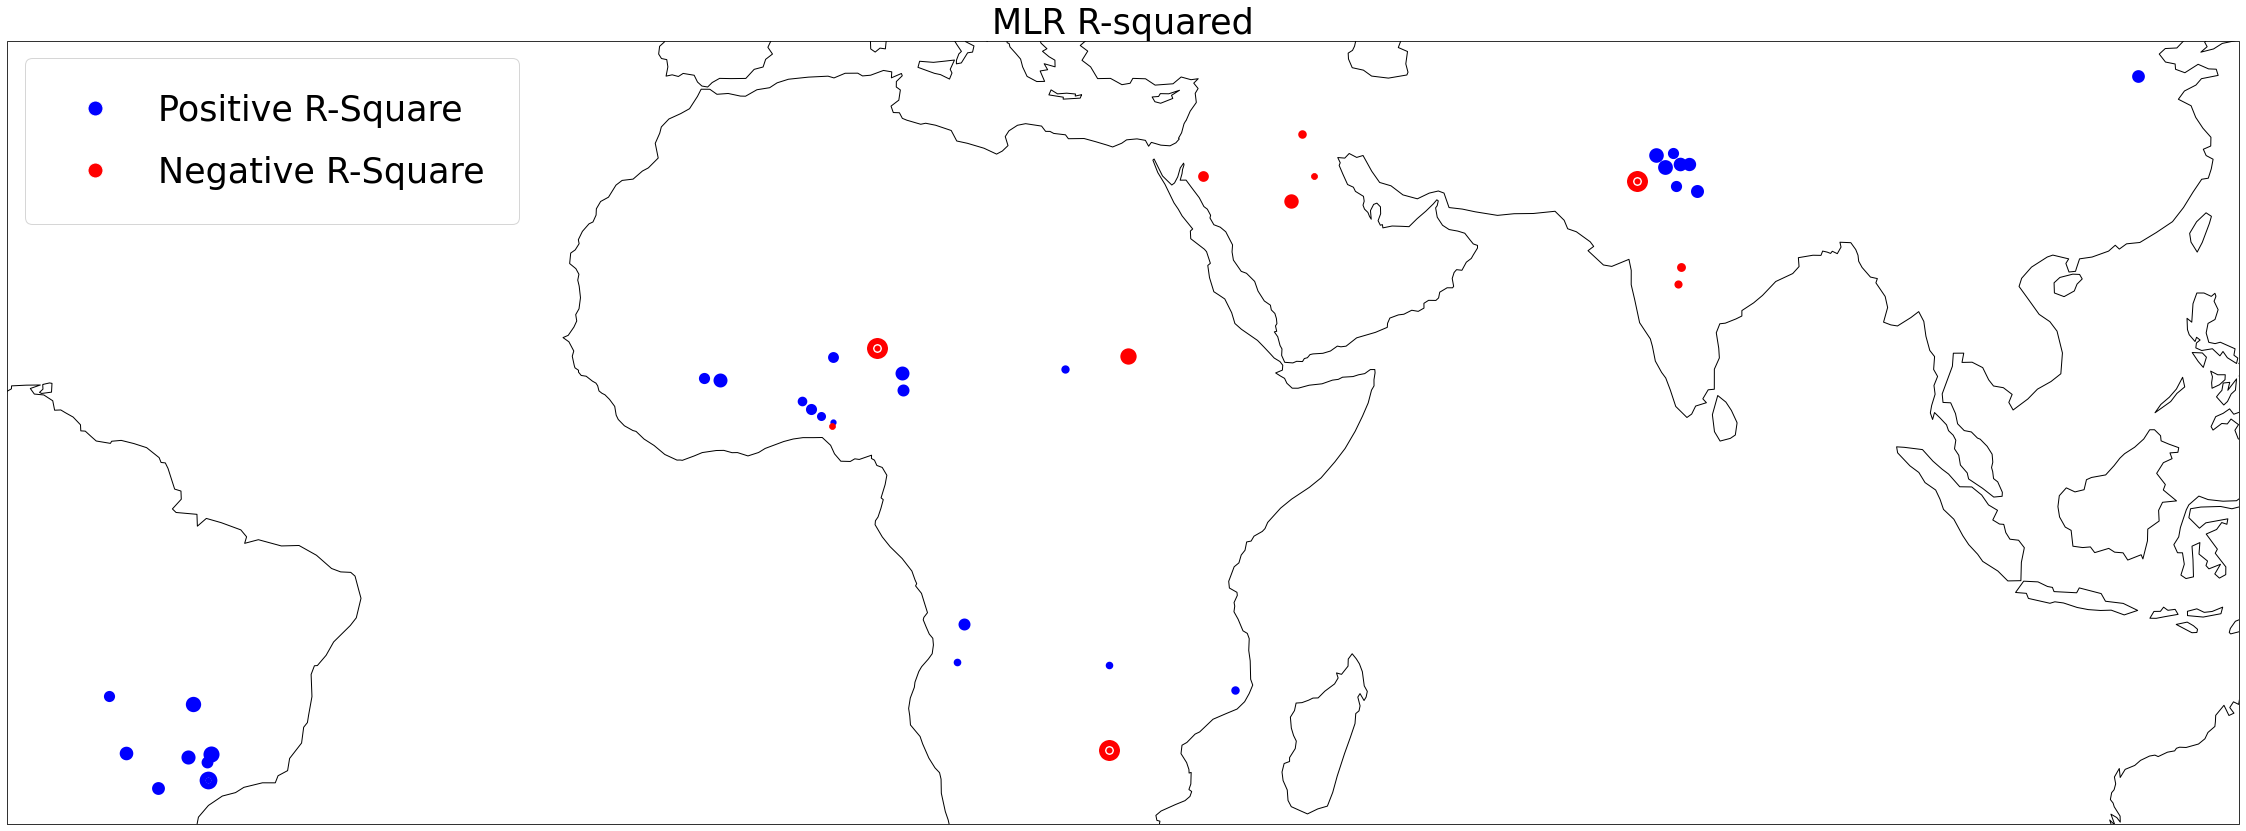

In [233]:
#Display cities with r2 proportional dot
#plot of where the test and training cities are located

################
##### MLR ######
################

plt.rc('axes', titlesize=35)     # fontsize of the axes title
fig = plt.figure(figsize=(40,35))
ax = plt.axes(projection=ccrs.PlateCarree())
ax.coastlines()

for i, city in enumerate(cities):

    lat = CITY_COUNTRY_lat_lon[CITY_COUNTRY_lat_lon['City'] == city]['Lat']
    lon = CITY_COUNTRY_lat_lon[CITY_COUNTRY_lat_lon['City'] == city]['Lon']
    r2 = r2_df.iloc[i].mlr_r2
        
    if r2 > -1:
        point_size = 15*abs(r2)
    else:
        point_size = 15
    
    if r2 < 0:
        point_col = 'red'
    else:
        point_col = 'blue'
    
    ax.scatter(lon, lat, zorder=5,color= point_col, linewidths = point_size)

ax.set(title = 'MLR R-squared')    
    
legend_elements = [Line2D([0],[0],marker='o', color = 'w', markerfacecolor='blue', label = 'Positive R-Square'
                          , markersize=15),Line2D([0],[0],marker='o', color = 'w', markerfacecolor='red'
                          , label = 'Negative R-Square' , markersize=15)]
ax.legend(handles = legend_elements, loc=2, borderpad = 1, fontsize = 35, labelspacing=0.8)       

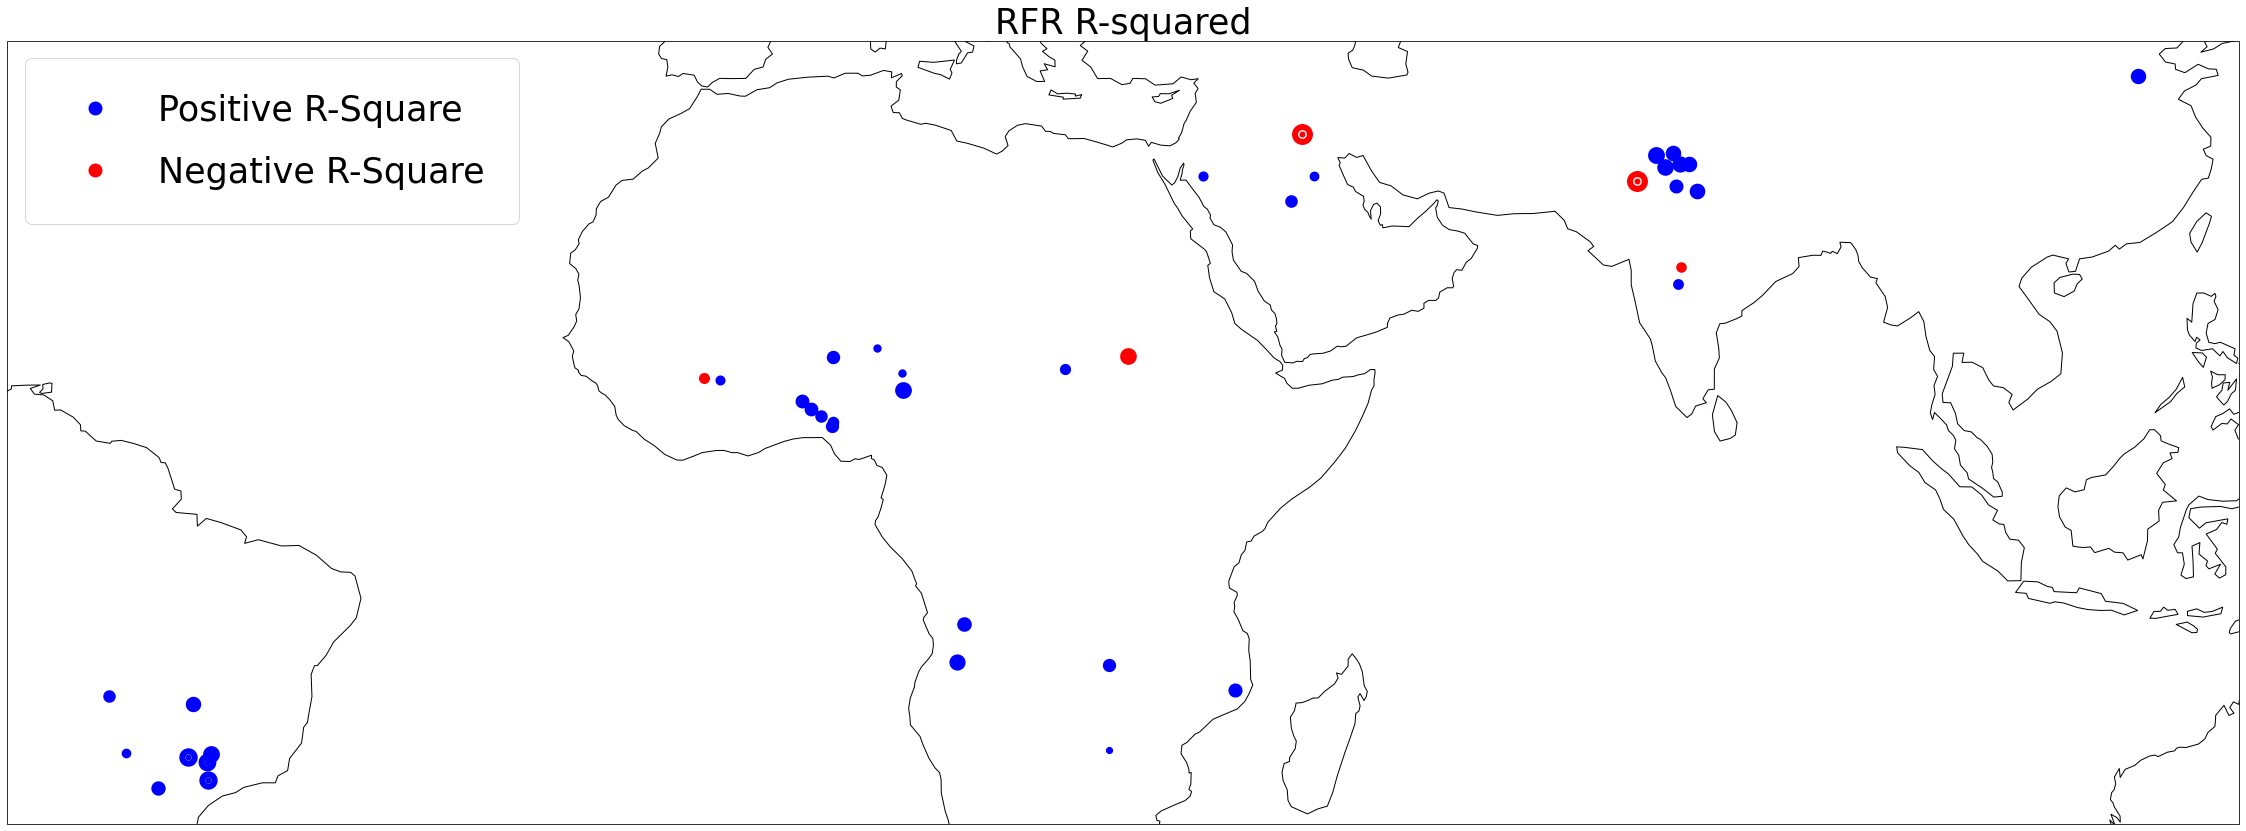

In [234]:
#Display cities with r2 proportional dot
#plot of where the test and training cities are located

################
##### RFR ######
################

plt.rc('axes', titlesize=35)     # fontsize of the axes title
fig = plt.figure(figsize=(40,35))
ax = plt.axes(projection=ccrs.PlateCarree())
ax.coastlines()

for i, city in enumerate(cities):

    lat = CITY_COUNTRY_lat_lon[CITY_COUNTRY_lat_lon['City'] == city]['Lat']
    lon = CITY_COUNTRY_lat_lon[CITY_COUNTRY_lat_lon['City'] == city]['Lon']
    r2 = r2_df.iloc[i].rfr_r2
        
    if r2 > -1:
        point_size = 15*abs(r2)
    else:
        point_size = 15
    
    if r2 < 0:
        point_col = 'red'
    else:
        point_col = 'blue'
    
    ax.scatter(lon, lat, zorder=5,color= point_col, linewidths = point_size)

ax.set(title = 'RFR R-squared')    
    
legend_elements = [Line2D([0],[0],marker='o', color = 'w', markerfacecolor='blue', label = 'Positive R-Square'
                          , markersize=15),Line2D([0],[0],marker='o', color = 'w', markerfacecolor='red'
                          , label = 'Negative R-Square' , markersize=15)]
ax.legend(handles = legend_elements, loc=2, borderpad = 1, fontsize = 35, labelspacing=0.8)       

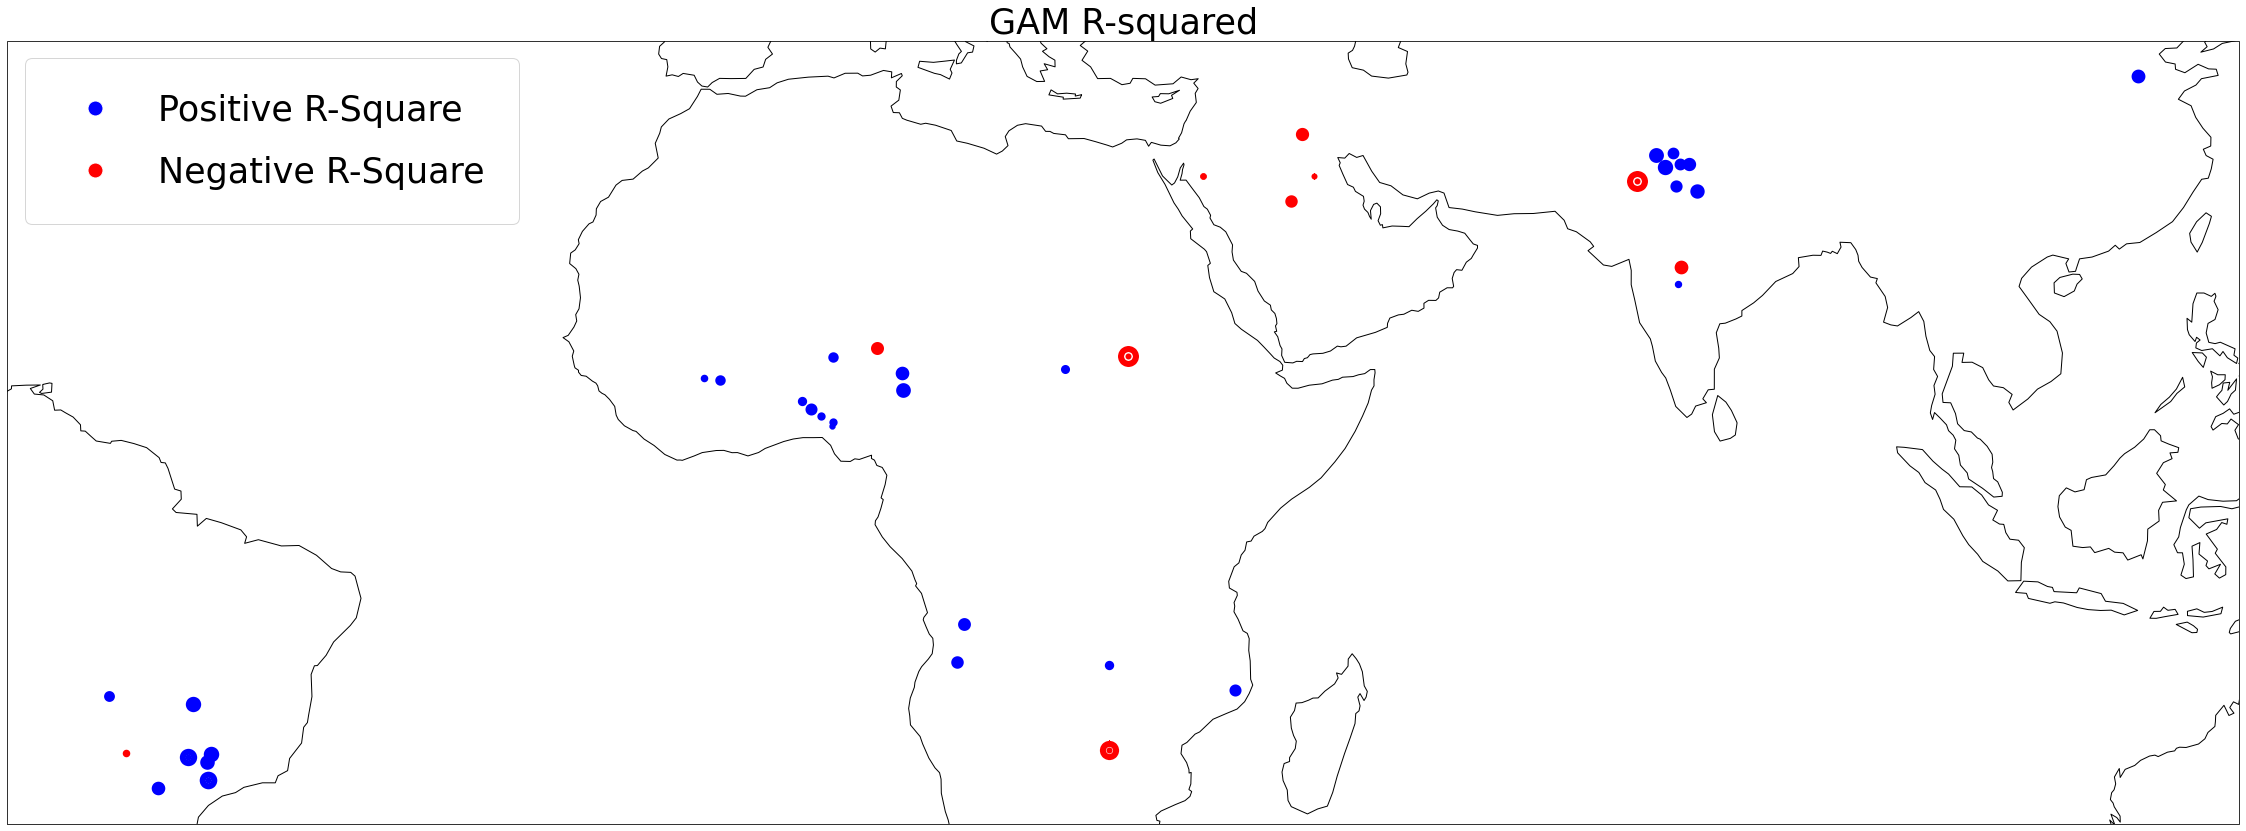

In [235]:
#Display cities with r2 proportional dot
#plot of where the test and training cities are located

################
##### GAM ######
################

plt.rc('axes', titlesize=35)     # fontsize of the axes title
fig = plt.figure(figsize=(40,35))
ax = plt.axes(projection=ccrs.PlateCarree())
ax.coastlines()

for i, city in enumerate(cities):

    lat = CITY_COUNTRY_lat_lon[CITY_COUNTRY_lat_lon['City'] == city]['Lat']
    lon = CITY_COUNTRY_lat_lon[CITY_COUNTRY_lat_lon['City'] == city]['Lon']
    r2 = r2_df.iloc[i].gam_r2
        
    if r2 > -1:
        point_size = 15*abs(r2)
    else:
        point_size = 15
    
    if r2 < 0:
        point_col = 'red'
    else:
        point_col = 'blue'
    
    ax.scatter(lon, lat, zorder=5,color= point_col, linewidths = point_size)

ax.set(title = 'GAM R-squared')    
    
legend_elements = [Line2D([0],[0],marker='o', color = 'w', markerfacecolor='blue', label = 'Positive R-Square'
                          , markersize=15),Line2D([0],[0],marker='o', color = 'w', markerfacecolor='red'
                          , label = 'Negative R-Square' , markersize=15)]
ax.legend(handles = legend_elements, loc=2, borderpad = 1, fontsize = 35, labelspacing=0.8)       

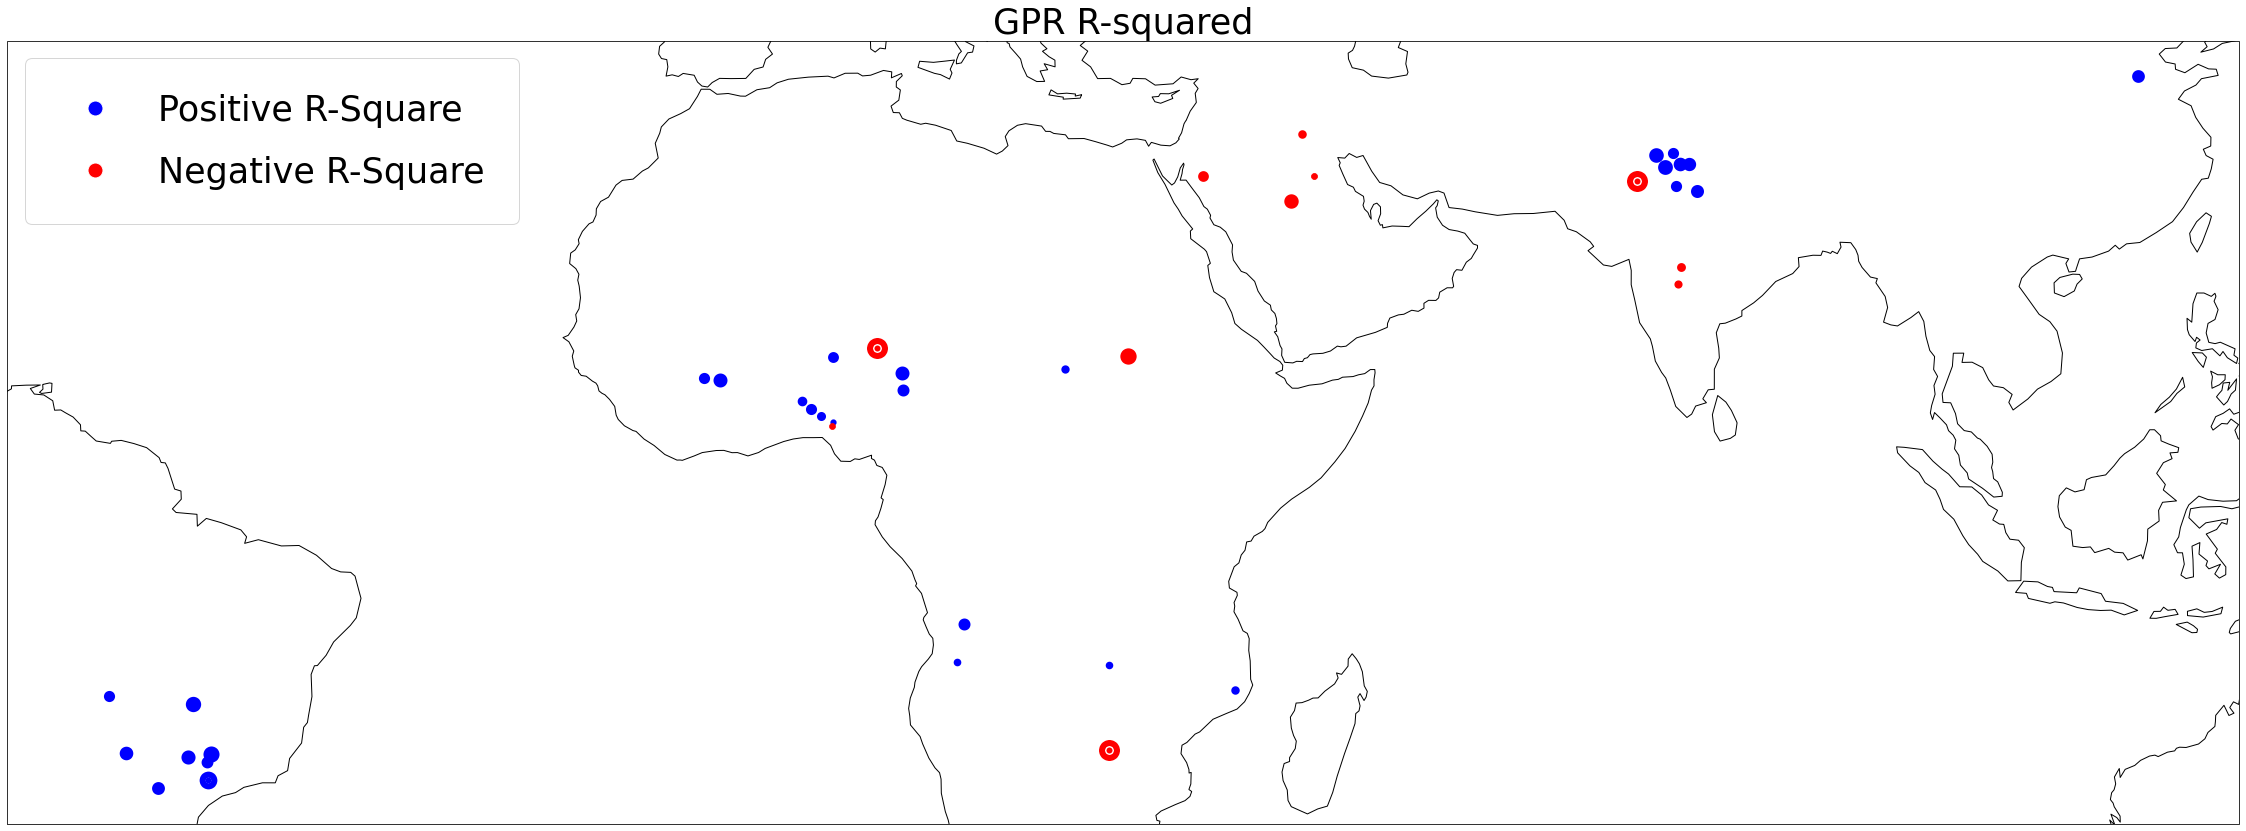

In [236]:
#Display cities with r2 proportional dot
#plot of where the test and training cities are located

################
##### GPR ######
################

plt.rc('axes', titlesize=35)     # fontsize of the axes title
fig = plt.figure(figsize=(40,35))
ax = plt.axes(projection=ccrs.PlateCarree())
ax.coastlines()

for i, city in enumerate(cities):

    lat = CITY_COUNTRY_lat_lon[CITY_COUNTRY_lat_lon['City'] == city]['Lat']
    lon = CITY_COUNTRY_lat_lon[CITY_COUNTRY_lat_lon['City'] == city]['Lon']
    r2 = r2_df.iloc[i].gpr_r2
        
    if r2 > -1:
        point_size = 15*abs(r2)
    else:
        point_size = 15
    
    if r2 < 0:
        point_col = 'red'
    else:
        point_col = 'blue'
    
    ax.scatter(lon, lat, zorder=5,color= point_col, linewidths = point_size)

ax.set(title = 'GPR R-squared')    
    
legend_elements = [Line2D([0],[0],marker='o', color = 'w', markerfacecolor='blue', label = 'Positive R-Square'
                          , markersize=15),Line2D([0],[0],marker='o', color = 'w', markerfacecolor='red'
                          , label = 'Negative R-Square' , markersize=15)]
ax.legend(handles = legend_elements, loc=2, borderpad = 1, fontsize = 35, labelspacing=0.8)       